In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re


In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [118]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [134]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        try:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        except IndexError as err:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=0
            print('bid', err, record)
        #ask
        try:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        except IndexError as err:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=0
            print("ask", err, record)        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [124]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [166]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5), for 5 best bids/asks
    if record.shape!=(2,2,10):
        raise Exception('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [165]:
raise Exception("bad shape")

Exception: bad shape

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [10]:
def index_to_time(index):
    if index<0:
        raise ValueError("Index lower than 0!")
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [136]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [137]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:], k=10)  
                count+=1

ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '124

ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list

ask list index out of range ['BID', '842.0', '254.0', '870.5', '500.0', '991.0', '99.0', '993.5', '412.0', '996.5', '674.0', '998.5', '42.0', '1000.0', '432.0', '1001.0', '83.0', '1002.0', '123.0', '1005.0', '850.0', 'ASK', '979.0', '641.0', '1000.0', '82.0', '1004.0', '209.0', '1006.0', '42.0', '1009.0', '674.0', '1031.0', '92.0', '1057.0', '415.0', '1100.0', '23905.0']
ask list index out of range ['BID', '842.0', '254.0', '870.5', '500.0', '991.0', '99.0', '993.5', '412.0', '996.5', '674.0', '998.5', '42.0', '1000.0', '432.0', '1001.0', '83.0', '1002.0', '123.0', '1005.0', '850.0', 'ASK', '979.0', '641.0', '1000.0', '82.0', '1004.0', '209.0', '1006.0', '42.0', '1009.0', '674.0', '1031.0', '92.0', '1057.0', '415.0', '1100.0', '23905.0']
ask list index out of range ['BID', '842.0', '254.0', '870.5', '500.0', '991.0', '99.0', '993.5', '412.0', '996.5', '674.0', '998.5', '42.0', '1000.0', '432.0', '1001.0', '83.0', '1002.0', '123.0', '1005.0', '850.0', 'ASK', '979.0', '641.0', '1000.0', 

ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '1003.0', '

ask list index out of range ['BID', '497.9', '855.0', '500.0', '500.0', '540.5', '1645.0', '545.0', '977.0', '547.5', '2448.0', '549.0', '2871.0', '549.5', '2183.0', '550.5', '1377.0', '552.0', '1379.0', '552.5', '871.0', '553.0', '670.0', '564.0', '307.0', 'ASK', '536.0', '154.0', '542.0', '2456.0', '553.0', '114.0', '553.5', '3456.0', '554.0', '2032.0', '557.0', '2448.0', '560.0', '977.0', '561.5', '1264.0', '563.0', '345.0']
ask list index out of range ['BID', '497.9', '855.0', '500.0', '500.0', '540.5', '1645.0', '545.0', '977.0', '547.5', '2448.0', '549.0', '2871.0', '549.5', '2183.0', '550.5', '1377.0', '552.0', '1379.0', '552.5', '871.0', '553.0', '670.0', '564.0', '307.0', 'ASK', '536.0', '154.0', '542.0', '2456.0', '553.0', '114.0', '553.5', '3456.0', '554.0', '2032.0', '557.0', '2448.0', '560.0', '977.0', '561.5', '1264.0', '563.0', '345.0']
ask list index out of range ['BID', '2200.0', '104.0', '2420.0', '1000.0', '2430.0', '500.0', '2632.0', '20.0', '2635.0', '200.0', '2639

ask list index out of range ['BID', '1025.0', '75.0', '1110.0', '4000.0', '1133.0', '1041.0', '1170.0', '1017.0', '1175.0', '5372.0', '1183.0', '732.0', '1184.0', '378.0', '1185.0', '983.0', '1186.0', '923.0', '1187.0', '835.0', 'ASK', '1189.0', '5529.0', '1190.0', '1187.0', '1191.0', '519.0', '1192.0', '943.0', '1193.0', '373.0', '1200.0', '500.0', '1201.0', '5256.0', '1205.0', '8128.0', '1240.0', '857.0']
ask list index out of range ['BID', '1025.0', '75.0', '1110.0', '4000.0', '1133.0', '1041.0', '1170.0', '1017.0', '1175.0', '5372.0', '1183.0', '732.0', '1184.0', '378.0', '1185.0', '983.0', '1186.0', '923.0', '1187.0', '835.0', 'ASK', '1189.0', '5529.0', '1190.0', '1187.0', '1191.0', '519.0', '1192.0', '943.0', '1193.0', '373.0', '1200.0', '500.0', '1201.0', '5256.0', '1205.0', '8128.0', '1240.0', '857.0']
ask list index out of range ['BID', '1025.0', '75.0', '1110.0', '4000.0', '1142.0', '1041.0', '1176.0', '1017.0', '1181.0', '5345.0', '1184.0', '500.0', '1185.0', '1775.0', '1186

ask list index out of range ['BID', '290.0', '2000.0', '293.1', '757.0', '293.8', '1000.0', '295.9', '349.0', '298.2', '2734.0', '298.5', '2657.0', '299.4', '3773.0', '300.6', '149.0', '300.7', '10675.0', '300.8', '1794.0', '318.8', '207.0', 'ASK', '292.6', '248.0', '294.8', '1736.0', '300.4', '295.0', '300.9', '10675.0', '302.0', '2701.0', '302.3', '2655.0', '302.8', '149.0', '303.6', '3773.0', '307.7', '349.0']
ask list index out of range ['BID', '290.0', '2000.0', '293.1', '757.0', '293.8', '1000.0', '295.9', '349.0', '298.2', '2734.0', '298.5', '2657.0', '299.4', '3773.0', '300.6', '149.0', '300.7', '10675.0', '300.8', '1794.0', '318.8', '207.0', 'ASK', '292.6', '248.0', '294.8', '1736.0', '300.4', '295.0', '300.9', '10675.0', '302.0', '2701.0', '302.3', '2655.0', '302.8', '149.0', '303.6', '3773.0', '307.7', '349.0']
ask list index out of range ['BID', '290.0', '1243.0', '293.1', '757.0', '293.8', '1000.0', '295.2', '16.0', '296.0', '20000.0', '298.0', '2932.0', '298.4', '21152.0'

ask list index out of range ['BID', '1571.0', '3200.0', '1580.0', '10800.0', '1581.0', '311.0', '1586.0', '3980.0', '1593.0', '631.0', '1597.0', '260.0', '1602.0', '551.0', '1603.0', '1033.0', 'ASK', '1607.0', '1311.0', '1608.0', '421.0', '1610.0', '550.0', '1622.0', '311.0', '1624.0', '3887.0', '1627.0', '10800.0', '1635.0', '3200.0', '1696.0', '188.0', '1719.0', '600.0']
ask list index out of range ['BID', '1571.0', '3200.0', '1580.0', '10800.0', '1581.0', '311.0', '1586.0', '3980.0', '1593.0', '631.0', '1597.0', '260.0', '1602.0', '551.0', '1603.0', '1033.0', 'ASK', '1607.0', '1311.0', '1608.0', '421.0', '1610.0', '550.0', '1622.0', '311.0', '1624.0', '3887.0', '1627.0', '10800.0', '1635.0', '3200.0', '1696.0', '188.0', '1719.0', '600.0']


In [148]:
data[1,0]

array([[[  874. ,   873. ,   872. ,   870. ,   865. ,   862.5,   861. ,
           860. ,   859. ,   858. ],
        [ 5000. ,  1096. , 10000. ,  6000. , 38000. ,   850. ,   555. ,
          5460. , 28555. , 12134. ]],

       [[  804. ,   838. ,   859.5,   864. ,   865. ,   865.5,   866. ,
           866.5,   868. ,   868.5],
        [  137. ,  1042. ,   347. ,   850. ,   702. ,   371. ,   555. ,
          1110. ,  1671. ,   918. ]]])

In [14]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [15]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 5)
(99, 10)


# parameters calculation functions

In [16]:


def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [17]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[1504.,  466., 2115., 8682.,  667.],
       [3396.,  701., 2615., 8682.,  501.],
       [3582.,  701., 2115., 8682., 1001.],
       [3323., 3262., 3146., 9713., 2032.]])

In [18]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [19]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [177]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [126]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip-interval)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+(book_counter-1)*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [167]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    orders_not_filled=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    buys_s2f_price=true_price
                    buys_vol=0
                    empty_buys+=1
                    s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    sells_s2f_price=true_price
                    sells_vol=0
                    empty_sells+=1
                    s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    print('{}% of intervals were set not filled'.format(100*orders_not_filled/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [168]:
s2f_imp,_=get_s2f_impact_and_ordersizes_comp(comp_id=0, time_to_skip=10,
                                   interval=1)
c=0
for day in s2f_imp:
    for i in day:
        if math.isnan(i):
            c+=1
print(c/s2f_imp.size)


37.94% of intervals were SELL empty
35.71% of intervals were BUY empty
0.07% of intervals were set not filled
0.7365


In [42]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [43]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [44]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [45]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [46]:
1e7

10000000.0

# HEATMAP

In [206]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


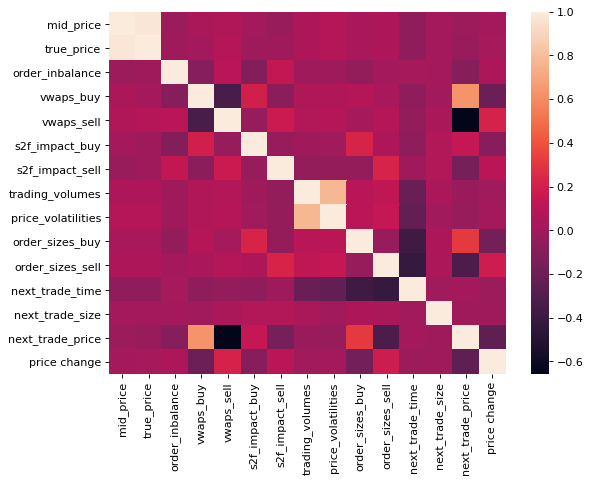

In [207]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [64]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix



In [179]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [180]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [181]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [225]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=1e-3):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (max_val-true_price)/true_price>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=1e-3):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (min_val-true_price)/true_price<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [256]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
      #  y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [232]:
np.unique(get_y())

array([-1,  1])

In [185]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [186]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [187]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [188]:
np.exp(1)

2.718281828459045

In [269]:
def logistic_regr(X, y, split_percent, comp_id, epsilon=2.7e-6, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=20 ,solver='sag', tol=1/np.exp(1))).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=20).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [190]:
def decision_tree(X, y, split_percent, comp_id, epsilon=2.7e-6,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [191]:
def xgb_model(X, y, split_percent, comp_id, epsilon=2.7e-6,
                               use_scaling=False, 
                               check_up_down=False, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    neg_class_count = np.sum(y[:split]==0)
    pos_class_count = np.sum(y[:split]==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), 
                          xgb.XGBClassifier(max_depth=5, scale_pos_weight=neg_class_count/pos_class_count)).fit(X[:split], y[:split])
    else:
        clf = xgb.XGBClassifier().fit(X[:split], y[:split])
    y_predicted=clf.predict(X[split:])

    print("Percent of correct classification:")
    print(np.sum(y_predicted ==  y[split:])/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix( y[split:], y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique( y[split:]).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X[split:], y[split:]), precision, recall
    else:
        return clf.score(X[split:], y[split:]), math.nan, math.nan

In [192]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [243]:
comp_id = 0
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0

In [244]:
names=[         
   # 'mid_price',
    #'true_price', 
 #   'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
 #   'trading_volumes', 
 #   'price_volatilities',
 #   'vwaps_order_sizes_buy', 
 #   'vwaps_order_sizes_sell',
 #   's2f_order_sizes_buy', 
 #   's2f_order_sizes_sell',
  #  'next_trade_time',
  #  'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [257]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, comp_id,epsilon, use_scaling=True, local_names=names))

#print("xgb")
#print("score: ",xgb_model(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))


1055.0947915192266
30.9375% of intervals were SELL empty
17.5% of intervals were BUY empty
0.3645833333333333% of intervals were set not filled
decision_tree
Coefficient impact:
order_inbalance   0.1770943092162343
vwaps_buy   0.08973502791081327
vwaps_sell   0.05663399649993118
s2f_impact_buy   0.05642827849557349
s2f_impact_sell   0.04950094930635175
trading_volumes   0.14910871211815435
price_volatilities   0.0027688766342913473
vwaps_order_sizes_buy   0.020253146262535927
vwaps_order_sizes_sell   0.011446088510946804
s2f_order_sizes_buy   0.04668930177762611
s2f_order_sizes_sell   0.02034663905612625
next_trade_time   0.11955034816446922
next_trade_size   0.13860423446649212
next_trade_price   0.061840091580453845
score:  0.4631578947368421
log reg
Coefficient impact:
order_inbalance   0.634513230671321
vwaps_buy   -1.0668335887089297
vwaps_sell   1.6248879465668176
s2f_impact_buy   -0.46788912797731985
s2f_impact_sell   -0.09167655588458833
trading_volumes   0.27644487826442915
pr

# find best epsilon

In [258]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.concatenate((np.array([0]),np.logspace(-8, -3, num=6)))
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [259]:
epsilons

array([0.e+00, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [260]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    print(np.unique(y))
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, comp_id, epsilons[eps], True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
30.9375% of intervals were SELL empty
17.5% of intervals were BUY empty
0.3645833333333333% of intervals were set not filled
[-6.42199683e+00 -4.66496928e+00 -3.64266790e+00 -3.59119829e+00
 -3.57898643e+00 -3.43810006e+00 -3.16364624e+00 -3.07477521e+00
 -3.06311797e+00 -3.05120313e+00 -2.93592887e+00 -2.79146881e+00
 -2.76476386e+00 -2.71407743e+00 -2.59660158e+00 -2.48294757e+00
 -2.43138548e+00 -2.41472329e+00 -2.40936521e+00 -2.36862730e+00
 -2.31076601e+00 -2.29621046e+00 -2.26596847e+00 -2.26092857e+00
 -2.25824172e+00 -2.25364792e+00 -2.20430280e+00 -2.18667053e+00
 -2.11125083e+00 -2.08195794e+00 -2.01554642e+00 -2.01073378e+00
 -2.00179329e+00 -1.99329446e+00 -1.98226100e+00 -1.95453343e+00
 -1.92526676e+00 -1.87426890e+00 -1.87311655e+00 -1.83910619e+00
 -1.83853571e+00 -1.81165822e+00 -1.80610872e+00 -1.80574773e+00
 -1.80319908e+00 -1.79058149e+00 -1.78826434e+00 -1.75899365e+00
 -1.75312430e+00 -1.71678703e+00 -1.69290586e+00 -1.63035423e+00
 -1.58004338e+00 -1.57713228

1
22.239583333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
1.40625% of intervals were set not filled
[-6.25432181e+00 -6.23504314e+00 -5.12431374e+00 -4.77497496e+00
 -4.66453912e+00 -4.64903801e+00 -4.55717555e+00 -3.98958866e+00
 -3.75567274e+00 -3.64213298e+00 -3.48949918e+00 -3.44447736e+00
 -3.40892385e+00 -3.39472181e+00 -3.37956878e+00 -3.30365544e+00
 -3.29161509e+00 -3.20910605e+00 -3.19324669e+00 -3.18678506e+00
 -3.14186010e+00 -3.10590456e+00 -3.07885727e+00 -2.99187085e+00
 -2.95359270e+00 -2.88908819e+00 -2.84229944e+00 -2.79116821e+00
 -2.75878189e+00 -2.74108824e+00 -2.68569295e+00 -2.63614579e+00
 -2.56834587e+00 -2.53022296e+00 -2.53021035e+00 -2.52926652e+00
 -2.51816820e+00 -2.49708262e+00 -2.48379057e+00 -2.45059560e+00
 -2.42381078e+00 -2.40029687e+00 -2.39672369e+00 -2.34576113e+00
 -2.33515863e+00 -2.27131973e+00 -2.25820108e+00 -2.25290365e+00
 -2.22421845e+00 -2.20494341e+00 -2.20266208e+00 -2.19380264e+00
 -2.19187591e+00 -2.1902

21.71875% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
0.10416666666666667% of intervals were set not filled
[-3.73606079e+00 -2.52991690e+00 -2.40830596e+00 -1.92195407e+00
 -1.89818941e+00 -1.85830668e+00 -1.74295837e+00 -1.66079817e+00
 -1.64438077e+00 -1.55860389e+00 -1.54140729e+00 -1.47320913e+00
 -1.46403131e+00 -1.43372684e+00 -1.39138996e+00 -1.35781069e+00
 -1.34695382e+00 -1.32482553e+00 -1.24456643e+00 -1.23788163e+00
 -1.20862919e+00 -1.19981740e+00 -1.18911903e+00 -1.18908019e+00
 -1.16679266e+00 -1.16111288e+00 -1.14403599e+00 -1.13832555e+00
 -1.13138946e+00 -1.06913377e+00 -1.06499604e+00 -1.06223095e+00
 -1.06058050e+00 -1.02326070e+00 -1.01492852e+00 -1.01425672e+00
 -1.00515433e+00 -1.00175729e+00 -9.96624962e-01 -9.92817950e-01
 -9.89648564e-01 -9.82507565e-01 -9.35056342e-01 -9.32404568e-01
 -9.18192141e-01 -9.09145268e-01 -8.96476499e-01 -8.96234335e-01
 -8.96162319e-01 -8.86098804e-01 -8.57078869e-01 -8.57025404e-01
 -8.54258369e-

30.520833333333332% of intervals were SELL empty
17.34375% of intervals were BUY empty
1.09375% of intervals were set not filled
[-4.32313593e+00 -2.92323504e+00 -2.64961127e+00 -2.51441244e+00
 -2.45446964e+00 -2.35408335e+00 -2.22902423e+00 -2.21052777e+00
 -2.06528874e+00 -1.81758945e+00 -1.80765722e+00 -1.80505817e+00
 -1.64363005e+00 -1.56536022e+00 -1.55146816e+00 -1.54016739e+00
 -1.45669968e+00 -1.39272203e+00 -1.35340873e+00 -1.30760038e+00
 -1.29286556e+00 -1.25892059e+00 -1.25586392e+00 -1.24958701e+00
 -1.24024891e+00 -1.22611953e+00 -1.21250785e+00 -1.19846098e+00
 -1.19737168e+00 -1.18980683e+00 -1.18931770e+00 -1.16696046e+00
 -1.16645757e+00 -1.15201055e+00 -1.14066880e+00 -1.13049545e+00
 -1.12303278e+00 -1.11836247e+00 -1.11699003e+00 -1.09557327e+00
 -1.09028881e+00 -1.07871950e+00 -1.07323219e+00 -1.06102903e+00
 -1.06081808e+00 -1.04241432e+00 -1.03094514e+00 -1.02989206e+00
 -1.02804231e+00 -1.02583137e+00 -1.01917855e+00 -1.01653845e+00
 -1.00411426e+00 -9.881931

21.770833333333332% of intervals were SELL empty
24.84375% of intervals were BUY empty
0.625% of intervals were set not filled
[-1.06064129e+03 -7.48583343e+00 -6.28459229e+00 -6.15616394e+00
 -4.84565872e+00 -4.69495741e+00 -4.50112330e+00 -3.95037586e+00
 -3.91082519e+00 -3.79756539e+00 -3.75516466e+00 -3.65942294e+00
 -3.54546722e+00 -3.45894336e+00 -3.30697746e+00 -3.24587293e+00
 -3.23750543e+00 -3.20223480e+00 -3.14464317e+00 -3.12017544e+00
 -3.09363779e+00 -3.05710250e+00 -3.04365014e+00 -2.97794763e+00
 -2.97367636e+00 -2.94875303e+00 -2.94386474e+00 -2.76572429e+00
 -2.74693740e+00 -2.72621706e+00 -2.71255808e+00 -2.69553041e+00
 -2.67902222e+00 -2.65021086e+00 -2.61691390e+00 -2.59357997e+00
 -2.58034161e+00 -2.45090628e+00 -2.40526397e+00 -2.40124427e+00
 -2.24300737e+00 -2.23751242e+00 -2.17877481e+00 -2.17595795e+00
 -2.16377453e+00 -2.13183153e+00 -2.11303275e+00 -2.09651605e+00
 -2.08935508e+00 -2.06386546e+00 -2.05909285e+00 -2.04985558e+00
 -2.03445475e+00 -2.03299999

21.041666666666668% of intervals were SELL empty
23.125% of intervals were BUY empty
3.6458333333333335% of intervals were set not filled
[-3.82933476e+00 -3.49573926e+00 -2.83517273e+00 -2.00929036e+00
 -1.48878645e+00 -1.45461328e+00 -1.34051144e+00 -1.33299043e+00
 -1.33071894e+00 -1.27060321e+00 -1.16798571e+00 -1.14071533e+00
 -1.07434291e+00 -1.02437626e+00 -1.00890538e+00 -1.00411008e+00
 -9.85824768e-01 -9.68579813e-01 -9.65069295e-01 -9.36264940e-01
 -9.31747760e-01 -9.28937564e-01 -9.18966929e-01 -9.12878578e-01
 -9.10202912e-01 -9.02860617e-01 -8.86692888e-01 -8.86070246e-01
 -8.84647864e-01 -8.79775968e-01 -8.74617281e-01 -8.74205429e-01
 -8.73465573e-01 -8.53001015e-01 -8.31348767e-01 -8.25427649e-01
 -7.98387350e-01 -7.71836631e-01 -7.52197934e-01 -7.42432198e-01
 -7.38322184e-01 -7.32858579e-01 -7.32177014e-01 -7.20886085e-01
 -7.20850618e-01 -7.14810943e-01 -7.14584197e-01 -7.07586860e-01
 -6.99342631e-01 -6.96570349e-01 -6.88764678e-01 -6.85349382e-01
 -6.83443494e-01 

25.833333333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
0.20833333333333334% of intervals were set not filled
[-1.98347108e+01 -1.41668118e+01 -1.23989947e+01 -1.21052581e+01
 -1.14922261e+01 -1.06395440e+01 -9.12464916e+00 -8.86102806e+00
 -8.70152505e+00 -8.49408240e+00 -8.39173504e+00 -8.17775101e+00
 -8.12682148e+00 -7.81357785e+00 -7.50459922e+00 -7.50412681e+00
 -7.22755056e+00 -7.12228214e+00 -7.09209211e+00 -6.97978996e+00
 -6.76328378e+00 -6.51482108e+00 -6.48294593e+00 -6.42310666e+00
 -6.40376740e+00 -6.33880451e+00 -6.21039146e+00 -6.15898949e+00
 -6.12147016e+00 -6.00378502e+00 -5.90285257e+00 -5.84464012e+00
 -5.76351647e+00 -5.73380737e+00 -5.72703731e+00 -5.71356094e+00
 -5.57812590e+00 -5.40406242e+00 -5.38807269e+00 -5.30463365e+00
 -5.11359297e+00 -5.10300442e+00 -5.09922313e+00 -4.98882031e+00
 -4.98135284e+00 -4.92772045e+00 -4.72405902e+00 -4.55695463e+00
 -4.42765525e+00 -4.40921983e+00 -4.38163590e+00 -4.35873633e+00
 -4.

21.71875% of intervals were SELL empty
21.40625% of intervals were BUY empty
2.4479166666666665% of intervals were set not filled
[-4.32516580e+00 -3.01201719e+00 -2.03370362e+00 -1.83924191e+00
 -1.71763398e+00 -1.55310960e+00 -1.50909920e+00 -1.39651944e+00
 -1.38790672e+00 -1.35366483e+00 -1.31554922e+00 -1.28515718e+00
 -1.25245287e+00 -1.23103159e+00 -1.22678586e+00 -1.16395875e+00
 -1.10460159e+00 -1.01632689e+00 -1.00914216e+00 -9.86621402e-01
 -9.73906506e-01 -9.63705347e-01 -9.44886743e-01 -9.29808787e-01
 -9.20864566e-01 -9.12597523e-01 -9.09391749e-01 -8.96447232e-01
 -8.95259329e-01 -8.84658386e-01 -8.78552704e-01 -8.75781449e-01
 -8.54510189e-01 -8.45920802e-01 -8.24594408e-01 -8.13779721e-01
 -8.12825353e-01 -7.96130982e-01 -7.92078928e-01 -7.89703165e-01
 -7.79175019e-01 -7.74001236e-01 -7.60889533e-01 -7.52393202e-01
 -7.38641360e-01 -7.35956243e-01 -7.35704026e-01 -7.32625960e-01
 -7.22910632e-01 -7.22047027e-01 -7.12979991e-01 -7.12410423e-01
 -7.10840541e-01 -7.01882

21.041666666666668% of intervals were SELL empty
25.572916666666668% of intervals were BUY empty
3.5416666666666665% of intervals were set not filled
[-3.37679310e+00 -2.62872407e+00 -2.18617476e+00 -1.92287477e+00
 -1.83368391e+00 -1.77295100e+00 -1.71302001e+00 -1.64506173e+00
 -1.54288736e+00 -1.34736202e+00 -1.29427762e+00 -1.29054038e+00
 -1.27640193e+00 -1.24783250e+00 -1.19652782e+00 -1.18486601e+00
 -1.12578684e+00 -1.11222919e+00 -1.10987256e+00 -1.07257403e+00
 -1.07114677e+00 -1.06821775e+00 -1.05793375e+00 -1.04044557e+00
 -1.01772491e+00 -1.00364638e+00 -9.50595695e-01 -9.35320334e-01
 -9.27091022e-01 -9.21702358e-01 -9.16329593e-01 -9.06131032e-01
 -8.97987958e-01 -8.89736799e-01 -8.71652957e-01 -8.65219199e-01
 -8.54780917e-01 -8.35797924e-01 -8.35675460e-01 -8.26320398e-01
 -8.20228987e-01 -8.17670479e-01 -8.16545749e-01 -8.15970574e-01
 -8.13565063e-01 -8.12755995e-01 -8.09742562e-01 -7.99839919e-01
 -7.96251552e-01 -7.95916459e-01 -7.91642534e-01 -7.86151212e-01
 -7.8

In [254]:
np.unique(get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change'))

array([-1,  1])

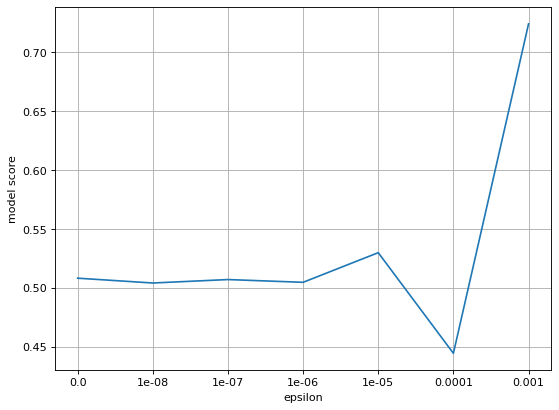

In [261]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.xticks(np.arange(len(epsilons)), epsilons, rotation='0')

plt.grid()

plt.plot(np.sum(comp_eps, axis=0)/9)

## take a look around 1e-6

In [262]:
epsilons=np.arange(start=2e-6,stop=4e-6, step=1e-7)
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [266]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, comp_id,epsilons[eps], True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
30.9375% of intervals were SELL empty
17.5% of intervals were BUY empty
0.3645833333333333% of intervals were set not filled
1
22.239583333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
1.40625% of intervals were set not filled
2
21.71875% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
0.10416666666666667% of intervals were set not filled
3
30.520833333333332% of intervals were SELL empty
17.34375% of intervals were BUY empty
1.09375% of intervals were set not filled
4
21.770833333333332% of intervals were SELL empty
24.84375% of intervals were BUY empty
0.625% of intervals were set not filled
5
21.041666666666668% of intervals were SELL empty
23.125% of intervals were BUY empty
3.6458333333333335% of intervals were set not filled
6
25.833333333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
0.20833333333333334% of intervals were set not filled
7
21.71875% of intervals were SELL empty
21.40

best epsilon:  2.999999999999999e-06


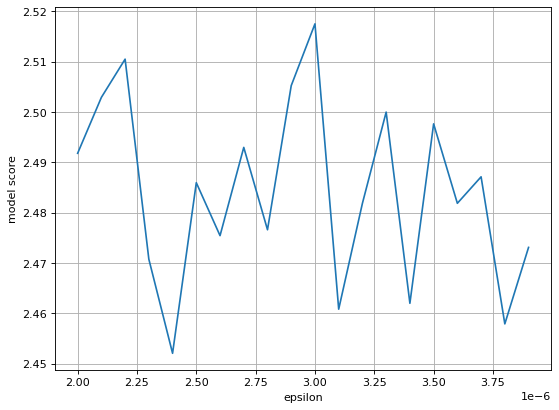

In [267]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
#plt.xticks(np.arange(len(epsilons)), epsilons, rotation='90')

plt.grid()
print("best epsilon: ", epsilons[np.argmax(np.sum(comp_eps, axis=0))])
plt.plot(epsilons, np.sum(comp_eps, axis=0)/9)


In [225]:
2.7e-6

2.7e-06

# try with different features

In [208]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [222]:
comps=np.arange(len(list_of_companies_number)//10)
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back , y_name='true_price', check='change')
    scores[c,0]=logistic_regr(X, np.copy(y),split_percent,  comps[c], epsilon, True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               comps[c], epsilon, True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


30.9375% of intervals were SELL empty
17.5% of intervals were BUY empty
0.3645833333333333% of intervals were set not filled
Coefficient impact:
order_inbalance   0.5192489110717567
vwaps_buy   -0.7575692532238524
vwaps_sell   0.43326946833446756
s2f_impact_buy   -0.5835003049684787
s2f_impact_sell   -0.23198482886235164
trading_volumes   -0.18412374047939287
price_volatilities   0.21537929117005047
vwaps_order_sizes_buy   0.5685568656270883
vwaps_order_sizes_sell   -0.4521391305951212
s2f_order_sizes_buy   0.5685568656270883
s2f_order_sizes_sell   -0.4521391305951212
next_trade_time   -0.12122315337620683
next_trade_size   0.08774380930640095
next_trade_price   -0.011836989690581941
22.239583333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
1.40625% of intervals were set not filled
Coefficient impact:
order_inbalance   0.3795386870022227
vwaps_buy   -0.30619253168477806
vwaps_sell   -0.1661275360562881
s2f_impact_buy   -0.10719478821128098
s2f_impact_sell  

skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.41107183392821245
s2f_order_sizes_buy   -0.1966943381455763
s2f_order_sizes_sell   -0.035550961045540806
next_trade_time   -0.25739329362222013
next_trade_size   -0.1536413310248526
next_trade_price   -0.28882802464466995
order_inbalance   0.4428678783049265
vwaps_buy   0.4210358459557621
vwaps_sell   -0.25177617847361583
s2f_impact_buy   0.4210358459557621
s2f_impact_sell   0.381766837038557
trading_volumes   0.12881083293874732
price_volatilities   -0.03836332762194464
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.43584399238553884
s2f_order_sizes_sell   -0.20718825106429328
next_trade_time   -0.10536675914647207
next_trade_size   -0.20042287953442817
next_trade_price   -0.14271080817506546
order_inbalance   -0.2350197867602649
vwaps_buy   0.4385649808775846
vwaps_sell   -0.08776790980912196
s2f_impact_buy   -0.08776790980912196
s2f_impact_sell   0.42628316606607086
trading_vol

vwaps_order_sizes_buy   -0.4304975759931257
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.2672796295051916
next_trade_time   0.39746935188378585
next_trade_size   -0.002125860014583709
next_trade_price   -0.3358082698984678
order_inbalance   0.1862914289035257
vwaps_buy   0.3318272443842606
vwaps_sell   -0.39434557447030416
s2f_impact_buy   -0.512685387523582
s2f_impact_sell   -0.4058482058939372
trading_volumes   -0.4058482058939372
price_volatilities   -0.345459542401613
vwaps_order_sizes_buy   -0.7190147762163436
vwaps_order_sizes_sell   -0.3726999943574974
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.12997464975563508
next_trade_size   0.05554386834173485
next_trade_price   -0.1996873038368115
order_inbalance   -0.200500603648271
vwaps_buy   0.176757371885676
vwaps_sell   0.23867180255186393
s2f_impact_buy   -0.2900822209488176
s2f_impact_sell   -0.2970315079095534
trading_volumes   -1.181831661623673
price_volatilities   -

price_volatilities   -0.1763598295289012
vwaps_order_sizes_buy   0.0063730667435168194
vwaps_order_sizes_sell   0.5528957430918987
s2f_order_sizes_buy   -0.7328395693107649
s2f_order_sizes_sell   0.43439015072373705
next_trade_time   -0.21423437801950224
next_trade_size   -0.2259003610771519
next_trade_price   -0.21423437801950224
order_inbalance   -0.2259003610771519
vwaps_buy   -0.6548656889833462
vwaps_sell   -0.11526574452429743
s2f_impact_buy   0.08069381711769512
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.3590294831055934
vwaps_order_sizes_buy   -0.2922605204609375
vwaps_order_sizes_sell   0.28018649062122053
s2f_order_sizes_buy   0.2524949329379936
s2f_order_sizes_sell   -0.8279999595523002
next_trade_time   0.5941967328160972
next_trade_size   -0.38961249983727764
next_trade_price   -0.1652455676829731
order_inbalance   -0.38961249983727764
vwaps_buy   -0.1652455676829731
vwaps_sell   -1.0816197318056
s2f_impact_buy   -0.06302142756367816
s2f_impact_s

skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   2.2611800111518487
vwaps_order_sizes_buy   -0.22057032390894568
vwaps_order_sizes_sell   1.1656721314016818
s2f_order_sizes_buy   0.19540833308767147
s2f_order_sizes_sell   -0.07898023754267733
next_trade_time   2.039193822021554e-07
next_trade_size   0.39943830495231947
next_trade_price   0.30055581925087355
order_inbalance   0.39943830495231947
vwaps_buy   0.30055581925087355
vwaps_sell   -0.26232324522947403
s2f_impact_buy   0.47988201628893584
s2f_impact_sell   -0.23767202404551718
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   2.0249029546329003
vwaps_order_sizes_sell   -0.41192322722202024
s2f_order_sizes_buy   0.9292674003506659
s2f_order_sizes_sell   -0.6084995167656669
next_trade_time   0.5350453707042988
next_trade_size   -0.5495960992511867
next_trade_price   0.3767595569912029
order_inbalance   0.47989406319469297
vwaps_buy   0.3767595569912029
vwaps_sell   0.47989406319469297
s2f_im

Coefficient impact:
vwaps_buy   -0.19981693393893332
vwaps_sell   0.5484865208923214
s2f_impact_buy   -0.040149514583910605
s2f_impact_sell   -0.03009017279429382
trading_volumes   -0.6473515630738751
price_volatilities   0.02799809913603969
vwaps_order_sizes_buy   -0.16955470089819547
vwaps_order_sizes_sell   0.6156833204992633
s2f_order_sizes_buy   -0.16955470089819547
s2f_order_sizes_sell   0.6156833204992633
next_trade_time   -0.18316684040242417
next_trade_size   -0.3445884551395851
next_trade_price   0.20514335120422572
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   2.831269736449312
s2f_impact_buy   0.4987277768358599
s2f_impact_sell   -0.1374380380379736
trading_volumes   -0.12147707457435307
price_volatilities   -0.4638498781395662
vwaps_order_sizes_buy   -0.29905762826798593
vwaps_order_sizes_sell   0.07373065751779107
s2f_order_sizes_buy   0.49833948616253104
s2f_order_sizes_sell   0.07373065751779107
next_trade_time   0.49833948616253104
next_trade_size   -0.15

Coefficient impact:
vwaps_order_sizes_sell   -0.11243228782088245
s2f_order_sizes_buy   0.31960030018754804
s2f_order_sizes_sell   0.13350905734402158
next_trade_time   0.2970787820241031
next_trade_size   -0.3227743374755119
next_trade_price   0.34491690366023114
order_inbalance   0.8276863523272388
vwaps_buy   -0.2504960862287982
vwaps_sell   -0.035661819994965795
s2f_impact_buy   -0.2504960862287982
s2f_impact_sell   0.1211336359336061
trading_volumes   -0.4839730679995713
price_volatilities   -0.3499702405135524
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.053566220507668225
s2f_order_sizes_sell   0.34718520540869546
next_trade_time   0.26489211275596586
next_trade_size   0.36158171527855093
next_trade_price   -0.2971388904482637
order_inbalance   0.2759266762157325
vwaps_buy   0.3727698017885739
vwaps_sell   0.012205404362962005
s2f_impact_buy   0.012205404362962005
s2f_impact_sell   -0.19514931578443684
trading_volumes   0.18229582721673535
price_v

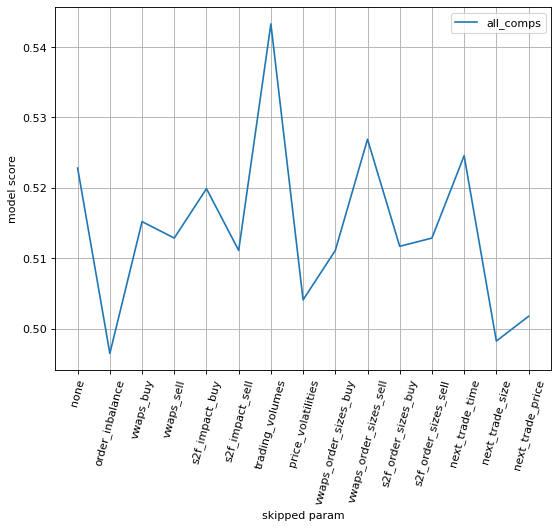

In [224]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
#plt.legend(comps)
 ### LOG REg

In [87]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=decision_tree(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=decision_tree(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


31.770833333333332% of intervals were SELL empty
17.864583333333332% of intervals were BUY empty
49.635416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.1428630148500407
vwaps_buy   0.10662730704147813
vwaps_sell   0.022459627364259518
s2f_impact_buy   0.07416370176336083
s2f_impact_sell   0.08260766363672317
trading_volumes   0.07254595198696018
price_volatilities   0.008240275765665906
vwaps_order_sizes_buy   0.03428030838651118
vwaps_order_sizes_sell   0.009839168467688017
s2f_order_sizes_buy   0.01025544576861561
s2f_order_sizes_sell   0.015342011012621086
next_trade_time   0.12820036262440837
next_trade_size   0.1330174565705566
next_trade_price   0.1595577047611107
26.354166666666668% of intervals were SELL empty
30.260416666666668% of intervals were BUY empty
56.614583333333336% of intervals were set nan
Coefficient impact:
order_inbalance   0.11962691088065787
vwaps_buy   0.09380264359224094
vwaps_sell   0.06082554025000195
s2f_impact_buy   0.03755

33.229166666666664% of intervals were SELL empty
24.6875% of intervals were BUY empty
57.916666666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.1501607846247211
vwaps_buy   0.14219289084204295
vwaps_sell   0.02793555515322692
s2f_impact_buy   0.03872710134978541
s2f_impact_sell   0.04946662071374434
trading_volumes   0.09368705314403222
price_volatilities   0.0
vwaps_order_sizes_buy   0.022764069539967752
vwaps_order_sizes_sell   0.03805778016873338
s2f_order_sizes_buy   0.027901029408870178
s2f_order_sizes_sell   0.022184070270483254
next_trade_time   0.11193365053463135
next_trade_size   0.07664800312838829
next_trade_price   0.1983413911213728
27.239583333333332% of intervals were SELL empty
18.020833333333332% of intervals were BUY empty
45.260416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.11749545892170508
vwaps_buy   0.06461389077413547
vwaps_sell   0.040553215320753774
s2f_impact_buy   0.08720423455227967
s2f_impact_se

27.604166666666668% of intervals were SELL empty
21.09375% of intervals were BUY empty
48.697916666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.1278975379766063
vwaps_buy   0.10628929000567736
vwaps_sell   0.032802722932153625
s2f_impact_buy   0.06245210078271939
s2f_impact_sell   0.02618372068518278
trading_volumes   0.11227254060807139
price_volatilities   0.03752747852092417
vwaps_order_sizes_buy   0.031099653761264986
vwaps_order_sizes_sell   0.023802100504193242
s2f_order_sizes_buy   0.04890274683041946
s2f_order_sizes_sell   0.0416478607837848
next_trade_time   0.11835066848772607
next_trade_size   0.10524648062310314
next_trade_price   0.12552509749817337
36.927083333333336% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
68.07291666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.0751010087807677
vwaps_buy   0.15012174402249545
vwaps_sell   0.0656910267565145
s2f_impact_buy   0.0357489198424311
s

32.447916666666664% of intervals were SELL empty
36.40625% of intervals were BUY empty
68.85416666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.11658389952475112
vwaps_buy   0.13206638829482506
vwaps_sell   0.09742584642743503
s2f_impact_buy   0.02933227861412649
s2f_impact_sell   0.051840491175580275
trading_volumes   0.07023899735241643
price_volatilities   0.003926890935771221
vwaps_order_sizes_buy   0.041455496339301234
vwaps_order_sizes_sell   0.04297452344887016
s2f_order_sizes_buy   0.023197245755511863
s2f_order_sizes_sell   0.018534018575354274
next_trade_time   0.07867916923806005
next_trade_size   0.104711276856988
next_trade_price   0.1890334774610087
18.854166666666668% of intervals were SELL empty
30.78125% of intervals were BUY empty
49.635416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.10709744905195968
vwaps_buy   0.053429587927902575
vwaps_sell   0.0905263196182349
s2f_impact_buy   0.056136896952826594
s2f_im

26.71875% of intervals were SELL empty
22.239583333333332% of intervals were BUY empty
48.958333333333336% of intervals were set nan
Coefficient impact:
order_inbalance   0.11819680719555019
vwaps_buy   0.10526518556370212
vwaps_sell   0.13170355393750613
s2f_impact_buy   0.08426160277207015
s2f_impact_sell   0.04958795621511076
trading_volumes   0.07205064073020685
price_volatilities   0.0040205922879828345
vwaps_order_sizes_buy   0.04504556355398393
vwaps_order_sizes_sell   0.01723538198162559
s2f_order_sizes_buy   0.03892428212002217
s2f_order_sizes_sell   0.0
next_trade_time   0.11373928053882144
next_trade_size   0.06351748451287033
next_trade_price   0.1564516685905476
22.291666666666668% of intervals were SELL empty
29.114583333333332% of intervals were BUY empty
51.40625% of intervals were set nan
Coefficient impact:
order_inbalance   0.13554612773252842
vwaps_buy   0.021015817846975565
vwaps_sell   0.1031699743155363
s2f_impact_buy   0.06138257038465172
s2f_impact_sell   0.038

44.479166666666664% of intervals were SELL empty
44.895833333333336% of intervals were BUY empty
89.375% of intervals were set nan
Coefficient impact:
order_inbalance   0.04892441008575431
vwaps_buy   0.20959010367088907
vwaps_sell   0.1413188852958325
s2f_impact_buy   0.0071165888474575955
s2f_impact_sell   0.008390083693844743
trading_volumes   0.04101205425117909
price_volatilities   0.07971659480885569
vwaps_order_sizes_buy   0.03237430205715014
vwaps_order_sizes_sell   0.005418595718941397
s2f_order_sizes_buy   0.01390084321093822
s2f_order_sizes_sell   0.009612076910414769
next_trade_time   0.0358584708629212
next_trade_size   0.07677609745291814
next_trade_price   0.289990893132903
24.635416666666668% of intervals were SELL empty
22.604166666666668% of intervals were BUY empty
47.239583333333336% of intervals were set nan
Coefficient impact:
order_inbalance   0.09348711979849082
vwaps_buy   0.08568437420143445
vwaps_sell   0.1301108040468236
s2f_impact_buy   0.05559041368733252


29.114583333333332% of intervals were SELL empty
31.302083333333332% of intervals were BUY empty
60.416666666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.14072447918230935
vwaps_buy   0.08869937016655977
vwaps_sell   0.08884241809158266
s2f_impact_buy   0.04200957624743672
s2f_impact_sell   0.039970779968679836
trading_volumes   0.08756511353776571
price_volatilities   0.004835384580881111
vwaps_order_sizes_buy   0.056591800082484045
vwaps_order_sizes_sell   0.027973967317646554
s2f_order_sizes_buy   0.03368823950320302
s2f_order_sizes_sell   0.03642195373596388
next_trade_time   0.10711998026939565
next_trade_size   0.08482309607409269
next_trade_price   0.1607338412419991
35.46875% of intervals were SELL empty
31.354166666666668% of intervals were BUY empty
66.82291666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.13934970787138815
vwaps_buy   0.11062494395305703
vwaps_sell   0.05531347882885575
s2f_impact_buy   0.03694916560456

33.125% of intervals were SELL empty
33.59375% of intervals were BUY empty
66.71875% of intervals were set nan
Coefficient impact:
order_inbalance   0.1499609823935506
vwaps_buy   0.0843579968485208
vwaps_sell   0.08654112497049422
s2f_impact_buy   0.04117579144451233
s2f_impact_sell   0.02856447267052786
trading_volumes   0.05010181020937811
price_volatilities   0.0
vwaps_order_sizes_buy   0.0926735290875469
vwaps_order_sizes_sell   0.041240043205394025
s2f_order_sizes_buy   0.01800513267255106
s2f_order_sizes_sell   0.0205663017448151
next_trade_time   0.07882316449978385
next_trade_size   0.09300939431311103
next_trade_price   0.21498025593981426
25.208333333333332% of intervals were SELL empty
30.260416666666668% of intervals were BUY empty
55.46875% of intervals were set nan
Coefficient impact:
order_inbalance   0.18069098979220102
vwaps_buy   0.02079329966213814
vwaps_sell   0.041769056904241895
s2f_impact_buy   0.04735683163806147
s2f_impact_sell   0.03313488057849507
trading_vo

35.416666666666664% of intervals were SELL empty
40.46875% of intervals were BUY empty
75.88541666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.12320153311700541
vwaps_buy   0.01742906951066226
vwaps_sell   0.07241012420537449
s2f_impact_buy   0.02612567579807918
s2f_impact_sell   0.058176892505874676
trading_volumes   0.16376464818311257
price_volatilities   0.0
vwaps_order_sizes_buy   0.04924777356745511
vwaps_order_sizes_sell   0.03337409303106962
s2f_order_sizes_buy   0.0487590391583601
s2f_order_sizes_sell   0.004164587466324029
next_trade_time   0.13586079323618938
next_trade_size   0.16588453289614494
next_trade_price   0.10160123732434823
31.822916666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
59.0625% of intervals were set nan
Coefficient impact:
order_inbalance   0.14714705434862999
vwaps_buy   0.052919342795507696
vwaps_sell   0.06248054547460705
s2f_impact_buy   0.1149086939820919
s2f_impact_sell   0.02672

Coefficient impact:
price_volatilities   0.1729564311110866
vwaps_order_sizes_buy   0.09712456929774906
vwaps_order_sizes_sell   0.06864262780422245
s2f_order_sizes_buy   0.04158722770096725
s2f_order_sizes_sell   0.0423974843335019
next_trade_time   0.008699844775109936
next_trade_size   0.036491697502004525
next_trade_price   0.020419089072154572
order_inbalance   0.03443342962934152
vwaps_buy   0.0392588134664843
vwaps_sell   0.11074349095179094
s2f_impact_buy   0.14170646027576989
s2f_impact_sell   0.1855388340798171
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.11253996564400259
vwaps_order_sizes_sell   0.09883377170821409
s2f_order_sizes_buy   0.060106517541718175
s2f_order_sizes_sell   0.06247993032940844
next_trade_time   0.04268124322329422
next_trade_size   0.08251842346425775
next_trade_price   0.057553890323338214
order_inbalance   0.026945602885807232
vwaps_buy   0.02885599372718048
vwaps_sell   0.03102196170850087
s2f_impact_buy   0.115214231478

next_trade_time   0.06277925117798286
next_trade_size   0.0777642018455891
next_trade_price   0.06417911855575313
order_inbalance   0.11756845443058005
vwaps_buy   0.004581372758399757
vwaps_sell   0.010558973405073726
s2f_impact_buy   0.03087923124693651
s2f_impact_sell   0.04228794592382436
trading_volumes   0.15215604457884918
price_volatilities   0.11869869163502002
vwaps_order_sizes_buy   0.11749348674346388
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.1489389684853491
next_trade_time   0.06688351630747104
next_trade_size   0.0686216830369724
next_trade_price   0.08626313246564059
order_inbalance   0.0584321780986696
vwaps_buy   0.08868702324099613
vwaps_sell   0.004142654174000412
s2f_impact_buy   0.055368954495900014
s2f_impact_sell   0.018440209809531857
trading_volumes   0.036400565253757816
price_volatilities   0.14687531895385608
vwaps_order_sizes_buy   0.11037980351839907
vwaps_order_sizes_sell   0.1105659921594559
skipped  s2f_order_sizes_

next_trade_size   0.09610409265037696
next_trade_price   0.028276894487663698
order_inbalance   0.03996911073766094
vwaps_buy   0.013042214195190683
vwaps_sell   0.07480514866589612
s2f_impact_buy   0.011751168119950577
s2f_impact_sell   0.01768897887263529
trading_volumes   0.060267954675713206
price_volatilities   0.03902339782618911
vwaps_order_sizes_buy   0.11110049149090216
vwaps_order_sizes_sell   0.17058854668802143
s2f_order_sizes_buy   0.1709789091865378
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.19649003999656908
next_trade_price   0.11652598977538789
order_inbalance   0.0446469865024774
vwaps_buy   0.04949921610254702
vwaps_sell   0.03303181190395308
s2f_impact_buy   0.060081248071900316
s2f_impact_sell   0.00982579761255029
trading_volumes   0.004435619336041008
price_volatilities   0.06005423131578576
vwaps_order_sizes_buy   0.06127037358703505
vwaps_order_sizes_sell   0.042443576502080235
s2f_order_sizes_buy   0.15780434478279323
s2f_order_siz

s2f_order_sizes_buy   0.03417300558834701
s2f_order_sizes_sell   0.03826119153119544
next_trade_time   0.029253080246955606
next_trade_size   0.12025916981333683
next_trade_price   0.10333444150057373
order_inbalance   0.2031779247936614
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.20584595626983196
s2f_impact_sell   0.06241361980689014
trading_volumes   0.028712708440693457
price_volatilities   0.04473393649779475
vwaps_order_sizes_buy   0.07259800319606993
vwaps_order_sizes_sell   0.004187752869502846
s2f_order_sizes_buy   0.04568178343613224
s2f_order_sizes_sell   0.04961547036114533
next_trade_time   0.02504032333574618
next_trade_size   0.032858055904790816
next_trade_price   0.09967738125446245
order_inbalance   0.13163689514809865
vwaps_buy   0.19699811347884127
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.15236297163667797
trading_volumes   0.08752256251921252
price_volatilities   0.10537190683698369
vwaps_order_sizes_buy   0.026357065138764842
v

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.12064223038627242
vwaps_order_sizes_sell   0.10806729712568726
s2f_order_sizes_buy   0.06768087653716838
s2f_order_sizes_sell   0.04482306117371443
next_trade_time   0.06372699551881858
next_trade_size   0.08745649974618415
next_trade_price   0.04188310648647589
order_inbalance   0.019977026080469997
vwaps_buy   0.03804999791286177
vwaps_sell   0.023528670090727937
s2f_impact_buy   0.08307617174044833
s2f_impact_sell   0.12911170569433983
trading_volumes   0.17197636150683118
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.10993757907724212
s2f_order_sizes_buy   0.09930442981409919
s2f_order_sizes_sell   0.07269549920023807
next_trade_time   0.046753014740291504
next_trade_size   0.046619823114019646
next_trade_price   0.0835966883888354
order_inbalance   0.035705368167072614
vwaps_buy   0.017420367963221165
vwaps_sell   0.045579680255103804
s2f_impact_buy   0.04004157088705662
s2f_imp

s2f_order_sizes_sell   0.10420947735864003
next_trade_time   0.10173956798492224
next_trade_size   0.03908019586341837
next_trade_price   0.0391900821229348
order_inbalance   0.0859768497506053
vwaps_buy   0.00719701956545338
vwaps_sell   0.04673914094342983
s2f_impact_buy   0.027146979890838425
s2f_impact_sell   0.04883508282218112
trading_volumes   0.1020526176166717
price_volatilities   0.0810752438004404
vwaps_order_sizes_buy   0.19172030451605862
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.1207434264288151
next_trade_time   0.08607118909249954
next_trade_size   0.10416498670787713
next_trade_price   0.04499723648667609
order_inbalance   0.04777232698151404
vwaps_buy   0.09602432931184854
vwaps_sell   0.00969842270710486
s2f_impact_buy   0.05022314062685729
s2f_impact_sell   0.03588541192345808
trading_volumes   0.01801034812627187
price_volatilities   0.09651964278002755
vwaps_order_sizes_buy   0.10542776950678855
vwaps_order_sizes_sell   0.18446

skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.13137788505864875
next_trade_price   0.04611614729919604
order_inbalance   0.13552785958870867
vwaps_buy   0.03818717602294354
vwaps_sell   0.040600804371209574
s2f_impact_buy   0.07568936809317237
s2f_impact_sell   0.012604108141971493
trading_volumes   0.061616883886609554
price_volatilities   0.052946794449799967
vwaps_order_sizes_buy   0.03475450738622605
vwaps_order_sizes_sell   0.029121946829017066
s2f_order_sizes_buy   0.12099776994935522
s2f_order_sizes_sell   0.22045874892314166
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09555498735748146
order_inbalance   0.0538919367820634
vwaps_buy   0.13072941564632934
vwaps_sell   0.03460224395487769
s2f_impact_buy   0.04663362718932483
s2f_impact_sell   0.10054412320373546
trading_volumes   0.0
price_volatilities   0.06169111213864077
vwaps_order_sizes_buy   0.0529238697832908
vwaps_order_sizes_sell   0.03624614689152351
s2f_order_sizes_buy  

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.15396920728418143
order_inbalance   0.0766200780549372
vwaps_buy   0.11048246056831106
vwaps_sell   0.07507977381698652
s2f_impact_buy   0.040063377113439054
s2f_impact_sell   0.07071035998384911
trading_volumes   0.002807717528839138
price_volatilities   0.07743417386233703
vwaps_order_sizes_buy   0.037813269658826545
vwaps_order_sizes_sell   0.028786275131481076
s2f_order_sizes_buy   0.024587389913977756
s2f_order_sizes_sell   0.10961820049363694
next_trade_time   0.19202771658919712
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.11244729238579267
vwaps_buy   0.10552453461826265
vwaps_sell   0.05020062590990795
s2f_impact_buy   0.10839987658348112
s2f_impact_sell   0.04726878709851289
trading_volumes   0.0977836115129054
price_volatilities   0.04260405147052787
vwaps_order_sizes_buy   0.08554545333911964
vwaps_order_sizes_sell   0.04659153434090544
s2f_order_sizes_buy   0.021205367577041088
s2f_or

Coefficient impact:
vwaps_buy   0.07568335735842102
vwaps_sell   0.07196059534657999
s2f_impact_buy   0.07122269691981062
s2f_impact_sell   0.05898725737881993
trading_volumes   0.1074955787360741
price_volatilities   0.0
vwaps_order_sizes_buy   0.05848017054078908
vwaps_order_sizes_sell   0.03515534056401064
s2f_order_sizes_buy   0.03398428468936944
s2f_order_sizes_sell   0.04167308334803147
next_trade_time   0.1312180263155979
next_trade_size   0.1889438090569364
next_trade_price   0.12519579974555944
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18709266062263105
s2f_impact_buy   0.05750366520500484
s2f_impact_sell   0.06025829605179773
trading_volumes   0.05428656726067411
price_volatilities   0.09952543883042736
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.05745001667742129
s2f_order_sizes_buy   0.035301728095682376
s2f_order_sizes_sell   0.030436781118327844
next_trade_time   0.0191782561036237
next_trade_size   0.11010763754332031
next_trade_price   0.1

next_trade_price   0.033702979502360626
order_inbalance   0.048563860163915326
vwaps_buy   0.03346783768842109
vwaps_sell   0.009865349403675977
s2f_impact_buy   0.0916887155536572
s2f_impact_sell   0.09608556012488818
trading_volumes   0.18649631756206972
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.15200282242876137
s2f_order_sizes_buy   0.13663672605789265
s2f_order_sizes_sell   0.040106688182232654
next_trade_time   0.04191513128965218
next_trade_size   0.05207107295631479
next_trade_price   0.09944448889706609
order_inbalance   0.0
vwaps_buy   0.04242484150476063
vwaps_sell   0.04346409588838105
s2f_impact_buy   0.01188387071981764
s2f_impact_sell   0.09541437190475935
trading_volumes   0.10191858174457058
price_volatilities   0.182717308425791
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.17166985741026464
s2f_order_sizes_sell   0.15472652455124417
next_trade_time   0.053854973427227275
next_trade_size   0.04339098756

Coefficient impact:
next_trade_time   0.14224331137918955
next_trade_size   0.07981270439640681
next_trade_price   0.04051285890919931
order_inbalance   0.06320874617825602
vwaps_buy   0.05902179640101463
vwaps_sell   0.0691132392644354
s2f_impact_buy   0.0
s2f_impact_sell   0.03639067955980017
trading_volumes   0.08991387932871783
price_volatilities   0.03541621328464074
vwaps_order_sizes_buy   0.10566275670538634
vwaps_order_sizes_sell   0.10724547470383984
s2f_order_sizes_buy   0.17145833988911346
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.14533820468611863
next_trade_price   0.07970789114902822
order_inbalance   0.0454642150597803
vwaps_buy   0.06430610145701222
vwaps_sell   0.07541533891908268
s2f_impact_buy   0.08647879729043907
s2f_impact_sell   0.0
trading_volumes   0.04901711641798655
price_volatilities   0.05829779491180866
vwaps_order_sizes_buy   0.04540667712192798
vwaps_order_sizes_sell   0.03650294617951749
s2f_order_sizes_buy   0.134308855760

s2f_impact_sell   0.0573859784361809
trading_volumes   0.05716317214675089
price_volatilities   0.09944469706280842
vwaps_order_sizes_buy   0.0677528292689569
vwaps_order_sizes_sell   0.004089263561221111
s2f_order_sizes_buy   0.03860976888661263
s2f_order_sizes_sell   0.029803807271631597
next_trade_time   0.023305388332664965
next_trade_size   0.029202862844255044
next_trade_price   0.11043695364205505
order_inbalance   0.1615510091720781
vwaps_buy   0.1238645576607838
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.14813479251187608
trading_volumes   0.08274673969315342
price_volatilities   0.070804827906545
vwaps_order_sizes_buy   0.069713432523858
vwaps_order_sizes_sell   0.1008958146605757
s2f_order_sizes_buy   0.01474569590818047
s2f_order_sizes_sell   0.021822844554178576
next_trade_time   0.02854982027106324
next_trade_size   0.027398982364669942
next_trade_price   0.04236059051710144
order_inbalance   0.11965231386039833
vwaps_buy   0.1259996695035526
vwaps_sell

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.1423627978934288
next_trade_size   0.06746379963144733
next_trade_price   0.1268292050400136
order_inbalance   0.06640165966356985
vwaps_buy   0.04375070036484451
vwaps_sell   0.08448847256350363
s2f_impact_buy   0.009385644276128001
s2f_impact_sell   0.012181758640007073
trading_volumes   0.07735532280436959
price_volatilities   0.04101888031616257
vwaps_order_sizes_buy   0.07912557090441848
vwaps_order_sizes_sell   0.08925012412502831
s2f_order_sizes_buy   0.16038606377707823
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.11442708879042494
next_trade_price   0.08369058289370464
order_inbalance   0.13054571715101676
vwaps_buy   0.06614364241702374
vwaps_sell   0.03009677690801201
s2f_impact_buy   0.10001348572801166
s2f_impact_sell   0.0069994635279598625
trading_volumes   0.030467420077361144
price_volatilities   0.03984296676918773
vwaps_order_sizes_buy   0.04741021244649488
vwaps_order_s

Coefficient impact:
s2f_impact_sell   0.09061348540724126
trading_volumes   0.09982094677644078
price_volatilities   0.09438662897620959
vwaps_order_sizes_buy   0.0694993687332685
vwaps_order_sizes_sell   0.06826177839024149
s2f_order_sizes_buy   0.013401439851927493
s2f_order_sizes_sell   0.00818045213901818
next_trade_time   0.040647718919182965
next_trade_size   0.05631582763729373
next_trade_price   0.03449346195944069
order_inbalance   0.14543441735711543
vwaps_buy   0.13362990917096867
vwaps_sell   0.14531456468165124
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.11566153954739772
price_volatilities   0.07067610052436352
vwaps_order_sizes_buy   0.11668768254560205
vwaps_order_sizes_sell   0.022898239235312295
s2f_order_sizes_buy   0.07873196144610542
s2f_order_sizes_sell   0.010752761784794153
next_trade_time   0.039320086457531
next_trade_size   0.05948163788642146
next_trade_price   0.031653588104110196
order_inbalance   0.023889793734595238
vwaps_buy   0.14

Coefficient impact:
next_trade_time   0.14822109294709998
next_trade_size   0.05865893901199254
next_trade_price   0.07761681662300951
order_inbalance   0.021350921033562984
vwaps_buy   0.053009688585020566
vwaps_sell   0.0682733455741264
s2f_impact_buy   0.007243696608593441
s2f_impact_sell   0.039126577404981856
trading_volumes   0.0868424871248842
price_volatilities   0.021585999519434063
vwaps_order_sizes_buy   0.1368009119144009
vwaps_order_sizes_sell   0.12147479860621666
s2f_order_sizes_buy   0.15979472504667686
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.1989619552438082
next_trade_price   0.06881627597513748
order_inbalance   0.10846729622895561
vwaps_buy   0.02875899838378932
vwaps_sell   0.05930637527363228
s2f_impact_buy   0.10519446344658961
s2f_impact_sell   0.00390699969840704
trading_volumes   0.04032878646791934
price_volatilities   0.03545883131466629
vwaps_order_sizes_buy   0.019499030736434032
vwaps_order_sizes_sell   0.0488612823714279
s

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18383316252943374
s2f_impact_buy   0.09033861805206568
s2f_impact_sell   0.033434373557074924
trading_volumes   0.05110151001069326
price_volatilities   0.0258095859846919
vwaps_order_sizes_buy   0.00608026405718191
vwaps_order_sizes_sell   0.061972453662591055
s2f_order_sizes_buy   0.035659879093663145
s2f_order_sizes_sell   0.010177499331477286
next_trade_time   0.03398239928817138
next_trade_size   0.09752256485321152
next_trade_price   0.1946434699369027
order_inbalance   0.17544421964284151
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.13052486342522548
s2f_impact_sell   0.07185968674454465
trading_volumes   0.04719263232287723
price_volatilities   0.035880796346965144
vwaps_order_sizes_buy   0.08377072135790918
vwaps_order_sizes_sell   0.022928895298209625
s2f_order_sizes_buy   0.04818552292854451
s2f_order_sizes_sell   0.028873018763189668
next_trade_time   0.004690489415540333
next_trade_size   0.038922

skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.22554416370538796
price_volatilities   0.08735691251026774
vwaps_order_sizes_buy   0.07639509017270069
vwaps_order_sizes_sell   0.0328770043409389
s2f_order_sizes_buy   0.09498289277911888
s2f_order_sizes_sell   0.005470332443749968
next_trade_time   0.07024714615100609
next_trade_size   0.020897084354249394
next_trade_price   0.02784832470226193
order_inbalance   0.029591135770782453
vwaps_buy   0.09221616063139575
vwaps_sell   0.11216802221127714
s2f_impact_buy   0.12440573022686305
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.1741299390486682
vwaps_order_sizes_buy   0.11851122535890468
vwaps_order_sizes_sell   0.06952992492926252
s2f_order_sizes_buy   0.058690516950334115
s2f_order_sizes_sell   0.01272846899070731
next_trade_time   0.0060919611305397334
next_trade_size   0.040361559469476505
next_trade_price   0.053865828300567915
order_inbalance   0.021813976202134946
vwaps_buy   0.0214035566

vwaps_sell   0.007073166841937175
s2f_impact_buy   0.05111373002203804
s2f_impact_sell   0.03390016541417327
trading_volumes   0.016585644273676956
price_volatilities   0.12009686187546918
vwaps_order_sizes_buy   0.13729469139076747
vwaps_order_sizes_sell   0.11156811397762409
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.18388386875864773
next_trade_size   0.05168536966982217
next_trade_price   0.027276328831237335
order_inbalance   0.057515116150371574
vwaps_buy   0.05847749924840905
vwaps_sell   0.13584079151733608
s2f_impact_buy   0.004446481097237205
s2f_impact_sell   0.05706117134264154
trading_volumes   0.02800471518718
price_volatilities   0.026828202553478873
vwaps_order_sizes_buy   0.08636957839184535
vwaps_order_sizes_sell   0.1484268357373531
s2f_order_sizes_buy   0.13418404151444
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.19727768695366443
next_trade_price   0.051391216158143925
order_inbalance   0.03712125000965692
vwa

Coefficient impact:
vwaps_buy   0.15695905937817917
vwaps_sell   0.06390961259759093
s2f_impact_buy   0.048569239717729425
s2f_impact_sell   0.023821066939912844
trading_volumes   0.04941427244272232
price_volatilities   0.010500892490143424
vwaps_order_sizes_buy   0.05863272042027198
vwaps_order_sizes_sell   0.03440559681101241
s2f_order_sizes_buy   0.02345713553858216
s2f_order_sizes_sell   0.010421860662300322
next_trade_time   0.0977322771455
next_trade_size   0.14557851684193582
next_trade_price   0.2765977490141191
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.14371191143657502
s2f_impact_buy   0.05708365140555283
s2f_impact_sell   0.0902710854567973
trading_volumes   0.01935720019361964
price_volatilities   0.11157967249132172
vwaps_order_sizes_buy   0.011132835620428242
vwaps_order_sizes_sell   0.05598811451221638
s2f_order_sizes_buy   0.022032618374374712
s2f_order_sizes_sell   0.04794631293006276
next_trade_time   0.013407507491928533
next_trade_size   0.11078

s2f_impact_sell   0.19309955832028158
trading_volumes   0.04744545107127893
price_volatilities   0.06362663084592537
vwaps_order_sizes_buy   0.07460191188002126
vwaps_order_sizes_sell   0.06989260391225337
s2f_order_sizes_buy   0.020195743383559017
s2f_order_sizes_sell   0.025226697842256434
next_trade_time   0.044476587448624476
next_trade_size   0.026652893080350678
next_trade_price   0.039046401550588986
order_inbalance   0.13781064880204455
vwaps_buy   0.17104171423865527
vwaps_sell   0.08688315762416003
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.16513221644473824
price_volatilities   0.04140645348713107
vwaps_order_sizes_buy   0.07657011523562143
vwaps_order_sizes_sell   0.041097576221855926
s2f_order_sizes_buy   0.08153669617890477
s2f_order_sizes_sell   0.025202732544406446
next_trade_time   0.03115350925790638
next_trade_size   0.059612701111928276
next_trade_price   0.03132736910758011
order_inbalance   0.04089296614953877
vwaps_buy   0.15155372538638318

Coefficient impact:
trading_volumes   0.12751579736631422
price_volatilities   0.08173823878034762
vwaps_order_sizes_buy   0.06042087059005199
vwaps_order_sizes_sell   0.07318460161107009
s2f_order_sizes_buy   0.06366054527350849
s2f_order_sizes_sell   0.041046991064554145
next_trade_time   0.02215679001619647
next_trade_size   0.008464504398730147
next_trade_price   0.036172945210006725
order_inbalance   0.016065773516038172
vwaps_buy   0.09602046649290905
vwaps_sell   0.1585373805803638
s2f_impact_buy   0.21501509509990904
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.10761572879137633
vwaps_order_sizes_buy   0.0845750542743348
vwaps_order_sizes_sell   0.026432253734728524
s2f_order_sizes_buy   0.07835763699198174
s2f_order_sizes_sell   0.01608414245561176
next_trade_time   0.09985801709734775
next_trade_size   0.033759896728504164
next_trade_price   0.017245843992414897
order_inbalance   0.04163474607234895
vwaps_buy   0.009728819712909636
vwaps_sell   0.1206

Coefficient impact:
s2f_order_sizes_sell   0.1382795995714633
next_trade_time   0.08851088526043405
next_trade_size   0.09635442913359579
next_trade_price   0.05232547335846637
order_inbalance   0.06841421824742247
vwaps_buy   0.0652250063754478
vwaps_sell   0.0038505028990149857
s2f_impact_buy   0.03289271250572544
s2f_impact_sell   0.007048058566302309
trading_volumes   0.04095701099244438
price_volatilities   0.11683736033495248
vwaps_order_sizes_buy   0.12464675740084
vwaps_order_sizes_sell   0.16465798535389065
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.11044198232273736
next_trade_size   0.09163149249486273
next_trade_price   0.10878493769609916
order_inbalance   0.05201397836535819
vwaps_buy   0.06498906604691375
vwaps_sell   0.07132642806606587
s2f_impact_buy   0.003493385550254189
s2f_impact_sell   0.026900570745555148
trading_volumes   0.022199834758265282
price_volatilities   0.02217151982891033
vwaps_order_sizes_buy   0.09733747308867179
vwaps_or

Coefficient impact:
order_inbalance   0.18093647814034555
vwaps_buy   0.0895022777046006
vwaps_sell   0.07848901093386833
s2f_impact_buy   0.02301514282080411
s2f_impact_sell   0.05548343783101726
trading_volumes   0.08208670018489476
price_volatilities   0.0
vwaps_order_sizes_buy   0.07849071370196027
vwaps_order_sizes_sell   0.0642643246228828
s2f_order_sizes_buy   0.03664871081414707
s2f_order_sizes_sell   0.03109010389490332
next_trade_time   0.14151111016670692
next_trade_size   0.13848198918386898
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.0930136151795582
vwaps_sell   0.0769443102846767
s2f_impact_buy   0.085005106912135
s2f_impact_sell   0.06218343079941518
trading_volumes   0.08261969612973832
price_volatilities   0.0
vwaps_order_sizes_buy   0.036169151263273185
vwaps_order_sizes_sell   0.04456034605402105
s2f_order_sizes_buy   0.051115551790752445
s2f_order_sizes_sell   0.029690356806472043
next_trade_time   0.14209549787015852
next_trade_size   0.135334028

Coefficient impact:
price_volatilities   0.11565085524686242
vwaps_order_sizes_buy   0.11651981144707982
vwaps_order_sizes_sell   0.11373547083160526
s2f_order_sizes_buy   0.07089719336567717
s2f_order_sizes_sell   0.06316167856254833
next_trade_time   0.0
next_trade_size   0.03636706972201604
next_trade_price   0.07427709919727553
order_inbalance   0.02018402452063281
vwaps_buy   0.014480561336870505
vwaps_sell   0.0627237901889777
s2f_impact_buy   0.10793110853878045
s2f_impact_sell   0.2040713370416739
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.05391413188277594
vwaps_order_sizes_sell   0.059046081068751546
s2f_order_sizes_buy   0.06274161893374128
s2f_order_sizes_sell   0.08585460966438527
next_trade_time   0.094479179374122
next_trade_size   0.10995716240922922
next_trade_price   0.053040900822320804
order_inbalance   0.02151117112084594
vwaps_buy   0.04656216677554578
vwaps_sell   0.023776727386540186
s2f_impact_buy   0.09171362068742807
s2f_impact_s

Coefficient impact:
vwaps_order_sizes_sell   0.12335614604005081
s2f_order_sizes_buy   0.030659314856061787
s2f_order_sizes_sell   0.1109284083568742
next_trade_time   0.019258110378699754
next_trade_size   0.07317130207553735
next_trade_price   0.03990622437379886
order_inbalance   0.01713267742969571
vwaps_buy   0.07478410307617758
vwaps_sell   0.010889604958410033
s2f_impact_buy   0.0430684000772798
s2f_impact_sell   0.14843480284170374
trading_volumes   0.12461230220834972
price_volatilities   0.18379860332736073
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.12788962038339347
s2f_order_sizes_sell   0.02991761230809114
next_trade_time   0.1087014216409516
next_trade_size   0.012844653608287486
next_trade_price   0.06412425716796522
order_inbalance   0.055614373190812076
vwaps_buy   0.010890680765810162
vwaps_sell   0.022341253781829933
s2f_impact_buy   0.01949632124824152
s2f_impact_sell   0.059488898474586875
trading_volumes   0.16005007129725674
pric

Coefficient impact:
s2f_order_sizes_buy   0.1486628449169235
s2f_order_sizes_sell   0.060314437372880475
next_trade_time   0.1183947393510001
next_trade_size   0.05089384440746814
next_trade_price   0.02664259669765464
order_inbalance   0.08575161442689663
vwaps_buy   0.06804150754238945
vwaps_sell   0.013686546741851203
s2f_impact_buy   0.04284144903372559
s2f_impact_sell   0.044140294803161124
trading_volumes   0.0908892030377141
price_volatilities   0.11216928970165677
vwaps_order_sizes_buy   0.13757163196667826
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.0962245797768386
next_trade_time   0.07393665311647622
next_trade_size   0.13165436884762724
next_trade_price   0.03833441030557594
order_inbalance   0.05590738965669928
vwaps_buy   0.09147325506658323
vwaps_sell   0.07250955406545308
s2f_impact_buy   0.020143302361558053
s2f_impact_sell   0.021694469553784276
trading_volumes   0.04930163771291366
price_volatilities   0.05705285064621807
vwaps_ord

Coefficient impact:
next_trade_price   0.15302626789955381
order_inbalance   0.10242216559006276
vwaps_buy   0.0639717969101589
vwaps_sell   0.06254987900929931
s2f_impact_buy   0.05347786360142431
s2f_impact_sell   0.030326170457175106
trading_volumes   0.01964728324550787
price_volatilities   0.04652632058924639
vwaps_order_sizes_buy   0.03764468727684137
vwaps_order_sizes_sell   0.06512408635782044
s2f_order_sizes_buy   0.02736667532176755
s2f_order_sizes_sell   0.19178524001155361
next_trade_time   0.14613156372958874
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.2096186959758214
vwaps_buy   0.04489024676268956
vwaps_sell   0.04931850688327311
s2f_impact_buy   0.10965331665864289
s2f_impact_sell   0.07654088796773396
trading_volumes   0.02369230852110774
price_volatilities   0.039578524714132236
vwaps_order_sizes_buy   0.021282350071443894
vwaps_order_sizes_sell   0.03339656857567814
s2f_order_sizes_buy   0.03613279934084274
s2f_order_sizes_sell   0.01873574976

Coefficient impact:
vwaps_sell   0.13662102526343944
s2f_impact_buy   0.10919764297377511
s2f_impact_sell   0.019959026002021905
trading_volumes   0.03969503085608161
price_volatilities   0.07836316436421557
vwaps_order_sizes_buy   0.004169842521443932
vwaps_order_sizes_sell   0.036257909394530746
s2f_order_sizes_buy   0.028426191127994854
s2f_order_sizes_sell   0.04068086249361839
next_trade_time   0.029161556742798606
next_trade_size   0.16081503736833608
next_trade_price   0.1507091548416427
order_inbalance   0.16594355605010105
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.16563048964400126
s2f_impact_sell   0.1274626358658028
trading_volumes   0.024505217694050535
price_volatilities   0.02527404249116957
vwaps_order_sizes_buy   0.06773844090797482
vwaps_order_sizes_sell   0.0
s2f_order_sizes_buy   0.03757931749963509
s2f_order_sizes_sell   0.07344880788122547
next_trade_time   0.032273319170593104
next_trade_size   0.014561228914359748
next_trade_price   0.0891991848

vwaps_order_sizes_buy   0.11702212204234497
vwaps_order_sizes_sell   0.07738142557082359
s2f_order_sizes_buy   0.06254036930544592
s2f_order_sizes_sell   0.01305289761748334
next_trade_time   0.011590633680703509
next_trade_size   0.0975296008213641
next_trade_price   0.03358872484810311
order_inbalance   0.06201821564733614
vwaps_buy   0.09614540625016355
vwaps_sell   0.09390818857475859
s2f_impact_buy   0.18016339603443954
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.11496728138792867
vwaps_order_sizes_buy   0.04056710587440591
vwaps_order_sizes_sell   0.07735422253955672
s2f_order_sizes_buy   0.014603056088224604
s2f_order_sizes_sell   0.09201487043158456
next_trade_time   0.012979258781409016
next_trade_size   0.07033855302792896
next_trade_price   0.06525649565475701
order_inbalance   0.03150705518059919
vwaps_buy   0.06840898665030094
vwaps_sell   0.12634348275414886
s2f_impact_buy   0.14001953869153683
s2f_impact_sell   0.1456400929376187
skipped  tradin

Coefficient impact:
vwaps_order_sizes_sell   0.10865960055873752
s2f_order_sizes_buy   0.061363861229310146
s2f_order_sizes_sell   0.046901123225793595
next_trade_time   0.06335098778583398
next_trade_size   0.015212053531154311
next_trade_price   0.09506580268170015
order_inbalance   0.02277401656185207
vwaps_buy   0.06594974481827091
vwaps_sell   0.07433350503607797
s2f_impact_buy   0.021467278848232293
s2f_impact_sell   0.1553123135048169
trading_volumes   0.15612472958889806
price_volatilities   0.11348498262932201
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.12159625309907827
s2f_order_sizes_sell   0.048106470826533375
next_trade_time   0.0417985618438018
next_trade_size   0.047174444552622215
next_trade_price   0.03936383822740426
order_inbalance   0.08381514384250252
vwaps_buy   0.03282664790632118
vwaps_sell   0.03584512473887057
s2f_impact_buy   0.054871102637685576
s2f_impact_sell   0.058227937927532725
trading_volumes   0.14986427779195755
pri

s2f_order_sizes_sell   0.04899010935765411
next_trade_time   0.0897659901310223
next_trade_size   0.03435280028919049
next_trade_price   0.059308421645473626
order_inbalance   0.031726010946959364
vwaps_buy   0.043991993184280834
vwaps_sell   0.03579043655619849
s2f_impact_buy   0.05203487338383111
s2f_impact_sell   0.04736621339224282
trading_volumes   0.1259905698802308
price_volatilities   0.09746071651484618
vwaps_order_sizes_buy   0.17893820258730095
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.12096629824146518
next_trade_time   0.08135159363001841
next_trade_size   0.08360102403596414
next_trade_price   0.043333767789382464
order_inbalance   0.05246882494529861
vwaps_buy   0.07387084360353977
vwaps_sell   0.03159583171382124
s2f_impact_buy   0.04234762926892874
s2f_impact_sell   0.027313501265806346
trading_volumes   0.03628797463126791
price_volatilities   0.11212595599479651
vwaps_order_sizes_buy   0.12126586775590129
vwaps_order_sizes_sell   

Coefficient impact:
vwaps_buy   0.06929206466097185
vwaps_sell   0.04419460563405091
s2f_impact_buy   0.03264245647846262
s2f_impact_sell   0.07792439120132513
trading_volumes   0.13390125370199296
price_volatilities   0.0
vwaps_order_sizes_buy   0.06474771885073356
vwaps_order_sizes_sell   0.056114721141724846
s2f_order_sizes_buy   0.020151426018518933
s2f_order_sizes_sell   0.02616210957998033
next_trade_time   0.10337520755412544
next_trade_size   0.19136220068951534
next_trade_price   0.18013184448859818
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18033234585852906
s2f_impact_buy   0.04465012604001773
s2f_impact_sell   0.033241777622750636
trading_volumes   0.062470024819992837
price_volatilities   0.11893787708744522
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.03948808938801554
s2f_order_sizes_buy   0.054575267209773015
s2f_order_sizes_sell   0.022988248754569045
next_trade_time   0.01800803917419251
next_trade_size   0.1619920102818802
next_trade_pric

Coefficient impact:
vwaps_order_sizes_buy   0.13938231337650606
vwaps_order_sizes_sell   0.10107216849907359
s2f_order_sizes_buy   0.03283970004909782
s2f_order_sizes_sell   0.0635252327839423
next_trade_time   0.028051876577226305
next_trade_size   0.05956734074676882
next_trade_price   0.03076526519363688
order_inbalance   0.01976805956916144
vwaps_buy   0.027909916237982026
vwaps_sell   0.027116950533801424
s2f_impact_buy   0.11366999683527762
s2f_impact_sell   0.19212002070198095
trading_volumes   0.16421115889554466
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.1475936308549017
s2f_order_sizes_buy   0.09501051307992642
s2f_order_sizes_sell   0.04386879594218476
next_trade_time   0.06332031863958038
next_trade_size   0.03293539188576167
next_trade_price   0.07023283061100052
order_inbalance   0.016547132144960775
vwaps_buy   0.005877171580438653
vwaps_sell   0.03739098374288605
s2f_impact_buy   0.03397174033655921
s2f_impact_sell   0.12957266370074047

Coefficient impact:
next_trade_size   0.08661212875914492
next_trade_price   0.1013765314812404
order_inbalance   0.17598933690306642
vwaps_buy   0.01909449598616214
vwaps_sell   0.020524332347632478
s2f_impact_buy   0.03505276110463703
s2f_impact_sell   0.072380986061833
trading_volumes   0.02881551508670901
price_volatilities   0.013056231970531792
vwaps_order_sizes_buy   0.011171534556759235
vwaps_order_sizes_sell   0.03310306909795539
s2f_order_sizes_buy   0.13448910586581936
s2f_order_sizes_sell   0.26833397077850885
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09703698442568713
order_inbalance   0.08435482761512146
vwaps_buy   0.1957919839103405
vwaps_sell   0.03405232236513558
s2f_impact_buy   0.029035830224415943
s2f_impact_sell   0.021928489720279422
trading_volumes   0.03385329688202504
price_volatilities   0.05150620744133112
vwaps_order_sizes_buy   0.03695978934663861
vwaps_order_sizes_sell   0.03212271988080978
s2f_order_sizes_buy   0.033062113415162

vwaps_order_sizes_buy   0.0501147664393261
vwaps_order_sizes_sell   0.08859360062263875
s2f_order_sizes_buy   0.0034466416785144975
s2f_order_sizes_sell   0.0650404933893577
next_trade_time   0.06336041969503697
next_trade_size   0.01772558577521742
next_trade_price   0.03320423237855896
order_inbalance   0.1165403282093736
vwaps_buy   0.11443984494073678
vwaps_sell   0.1825364730425189
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.12034677721269904
price_volatilities   0.04501775684224262
vwaps_order_sizes_buy   0.0999756978553317
vwaps_order_sizes_sell   0.04148793460327425
s2f_order_sizes_buy   0.07839873747308365
s2f_order_sizes_sell   0.0
next_trade_time   0.049828747974165116
next_trade_size   0.06770400600718152
next_trade_price   0.04378968841313586
order_inbalance   0.03375280226773053
vwaps_buy   0.08908357535271987
vwaps_sell   0.11659243906851581
s2f_impact_buy   0.2140218369299201
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.125

skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.1565099599307542
s2f_order_sizes_sell   0.05611691354426942
next_trade_time   0.07110787415294827
next_trade_size   0.020237852816316487
next_trade_price   0.03180870305017615
order_inbalance   0.09474048240428415
vwaps_buy   0.028803862149449105
vwaps_sell   0.054728159848446124
s2f_impact_buy   0.015655742684491793
s2f_impact_sell   0.04994946288770353
trading_volumes   0.1554057456705334
price_volatilities   0.061770550992012896
vwaps_order_sizes_buy   0.20316468986861447
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.09924082262397742
next_trade_time   0.09584023718728392
next_trade_size   0.1293484488276666
next_trade_price   0.01910301709157267
order_inbalance   0.024259144402526172
vwaps_buy   0.04083619317558371
vwaps_sell   0.025155556417172348
s2f_impact_buy   0.03379817895312091
s2f_impact_sell   0.06848935065706362
trading_volumes   0.03100456814316029
price_volatili

Coefficient impact:
next_trade_price   0.23352097923684056
order_inbalance   0.043101569274965626
vwaps_buy   0.18386780669539296
vwaps_sell   0.05608623246810194
s2f_impact_buy   0.07896709520857512
s2f_impact_sell   0.06641034879581038
trading_volumes   0.013373485890383343
price_volatilities   0.009602519758944265
vwaps_order_sizes_buy   0.06638796208568716
vwaps_order_sizes_sell   0.0248285562781654
s2f_order_sizes_buy   0.03442090609324718
s2f_order_sizes_sell   0.0779134082861682
next_trade_time   0.11151912992771766
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.16410176988359673
vwaps_buy   0.06908084743608392
vwaps_sell   0.1266002394238498
s2f_impact_buy   0.05319027360131448
s2f_impact_sell   0.06548006029188824
trading_volumes   0.08510845632533415
price_volatilities   0.0
vwaps_order_sizes_buy   0.053746454540238235
vwaps_order_sizes_sell   0.04736318404380942
s2f_order_sizes_buy   0.02278804596173332
s2f_order_sizes_sell   0.05493315022727585
next_trad

price_volatilities   0.11034296304528265
vwaps_order_sizes_buy   0.04766256973476629
vwaps_order_sizes_sell   0.05925170336249814
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.05248662207613868
next_trade_time   0.03150731105085585
next_trade_size   0.07012723033537772
next_trade_price   0.014116831940414838
order_inbalance   0.10141789965267843
vwaps_buy   0.14321505721839312
vwaps_sell   0.16621946127025952
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.14074676331672734
price_volatilities   0.023697985353032334
vwaps_order_sizes_buy   0.12433697669169426
vwaps_order_sizes_sell   0.06577633648874001
s2f_order_sizes_buy   0.052457161564236195
s2f_order_sizes_sell   0.0
next_trade_time   0.04736875027555423
next_trade_size   0.025055667447301276
next_trade_price   0.06347266502562957
order_inbalance   0.016192406159062703
vwaps_buy   0.11694521151920545
vwaps_sell   0.1711690107046227
s2f_impact_buy   0.15278106545419384
skipped  s2f_impact_sell 

Coefficient im

s2f_impact_buy   0.054509446993231715
s2f_impact_sell   0.1296255872512295
trading_volumes   0.1350173164644633
price_volatilities   0.11668512916994656
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.1472059315607251
s2f_order_sizes_sell   0.03302101598864003
next_trade_time   0.09795237120503676
next_trade_size   0.03732929990905256
next_trade_price   0.05492436225903407
order_inbalance   0.08973912266099492
vwaps_buy   0.04616827760851946
vwaps_sell   0.01633274829841635
s2f_impact_buy   0.03134145565203389
s2f_impact_sell   0.04931309495536667
trading_volumes   0.13387473129455119
price_volatilities   0.10699212486185296
vwaps_order_sizes_buy   0.15580546374577614
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.18784039314340972
next_trade_time   0.04406816005366763
next_trade_size   0.10214844129827834
next_trade_price   0.029379981160308592
order_inbalance   0.031130404040954643
vwaps_buy   0.06959055452275972
vwaps_sell

trading_volumes   0.07585598721789381
price_volatilities   0.02043921934244796
vwaps_order_sizes_buy   0.024626388126292593
vwaps_order_sizes_sell   0.03758589062615531
s2f_order_sizes_buy   0.058167493689732376
s2f_order_sizes_sell   0.05131864997715449
next_trade_time   0.1507777462747678
next_trade_size   0.1716399227556374
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.09844129845315076
vwaps_sell   0.10596391060494798
s2f_impact_buy   0.07583173859338883
s2f_impact_sell   0.034345319852801974
trading_volumes   0.06378372966696713
price_volatilities   0.008874023071669263
vwaps_order_sizes_buy   0.05260109772507801
vwaps_order_sizes_sell   0.02550797157438546
s2f_order_sizes_buy   0.03939407025246978
s2f_order_sizes_sell   0.02349877306108016
next_trade_time   0.17824234733964703
next_trade_size   0.10084971081144276
next_trade_price   0.19266600899297084
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.1291281505672314
s2f_impact_buy   0.084883834648394

Coefficient impact:
trading_volumes   0.09367963517473185
price_volatilities   0.2081433634125973
vwaps_order_sizes_buy   0.07654602068248434
vwaps_order_sizes_sell   0.008534892284609245
s2f_order_sizes_buy   0.06553538053621964
s2f_order_sizes_sell   0.05628842466449701
next_trade_time   0.03298947305699103
next_trade_size   0.04940666883691217
next_trade_price   0.030092657654560703
order_inbalance   0.01135239594465988
vwaps_buy   0.05617915707184881
vwaps_sell   0.08111450409260963
s2f_impact_buy   0.23013742658727854
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.10710389314783605
vwaps_order_sizes_buy   0.20116052403223486
vwaps_order_sizes_sell   0.06874357008574612
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.006850353277870968
next_trade_time   0.08402324852547982
next_trade_size   0.06078453597991953
next_trade_price   0.0703423021295269
order_inbalance   0.0332287453390534
vwaps_buy   0.013096892072653372
vwaps_sell   0.05301100162312748
s2f_imp

vwaps_buy   0.0034840889451233058
vwaps_sell   0.00240402137213508
s2f_impact_buy   0.0360198952625873
s2f_impact_sell   0.08716544574568265
trading_volumes   0.03319319206669807
price_volatilities   0.07846192476059678
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.028900686826719903
s2f_order_sizes_buy   0.09680011424517068
s2f_order_sizes_sell   0.21160757672857544
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.126723232362922
order_inbalance   0.05903260515607132
vwaps_buy   0.22945209455391322
vwaps_sell   0.0026130667088424793
s2f_impact_buy   0.00240402137213508
s2f_impact_sell   0.04819867628948727
trading_volumes   0.10772406495788486
price_volatilities   0.03579541668057146
vwaps_order_sizes_buy   0.04975987570624719
vwaps_order_sizes_sell   0.0034840889451233058
s2f_order_sizes_buy   0.02362153466421785
s2f_order_sizes_sell   0.06744351586605503
next_trade_time   0.24374780673652888
skipped  next_trade_size 

Coefficient impact:
order_inbalance  

next_trade_time   0.020613509840330765
next_trade_size   0.071246700673077
next_trade_price   0.014624194586082067
order_inbalance   0.016479596119485324
vwaps_buy   0.06965263380647091
vwaps_sell   0.08971918404429509
s2f_impact_buy   0.27600268965954483
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.052789238891271
vwaps_order_sizes_buy   0.1080605386630122
vwaps_order_sizes_sell   0.15428893800618398
s2f_order_sizes_buy   0.008576998050682258
s2f_order_sizes_sell   0.0341095091095091
next_trade_time   0.059203806678272776
next_trade_size   0.046835354691916735
next_trade_price   0.09673884180824407
order_inbalance   0.020939984059766274
vwaps_buy   0.021216438224748477
vwaps_sell   0.05231158499149174
s2f_impact_buy   0.0700876705222406
s2f_impact_sell   0.2748410963026607
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.037484767726253775
vwaps_order_sizes_sell   0.08270654809779626
s2f_order_sizes_buy   0.16497928567021586
s2f_order_s

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.13688828788087776
order_inbalance   0.14632661768566252
vwaps_buy   0.08897323277691234
vwaps_sell   0.003497436747015674
s2f_impact_buy   0.007443868752094174
s2f_impact_sell   0.06290725146234988
trading_volumes   0.10090826856265883
price_volatilities   0.06983991217715814
vwaps_order_sizes_buy   0.025932268946599234
vwaps_order_sizes_sell   0.007694360843434483
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.07573890297850772
next_trade_time   0.2738495911867292
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.18725796960836127
vwaps_buy   0.05583084153013821
vwaps_sell   0.050173412464276854
s2f_impact_buy   0.018890566967599363
s2f_impact_sell   0.01733593267490342
trading_volumes   0.1540039327329477
price_volatilities   0.12223827617564635
vwaps_order_sizes_buy   0.1072716180751174
vwaps_order_sizes_sell   0.03309320203376173
s2f_order_sizes_buy   0.0026230775602617555
s2f_order_sizes_sell 

vwaps_buy   0.21368820089500049
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.08490029949615474
trading_volumes   0.10683841300561914
price_volatilities   0.15852584604846728
vwaps_order_sizes_buy   0.008327151605067567
vwaps_order_sizes_sell   0.07997563553168187
s2f_order_sizes_buy   0.051643736232037545
s2f_order_sizes_sell   0.03371280724337408
next_trade_time   0.011902286768876946
next_trade_size   0.008644030112808749
next_trade_price   0.04586880655096996
order_inbalance   0.07320135117386704
vwaps_buy   0.06350245465348124
vwaps_sell   0.2729571815775937
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.09614196783333707
price_volatilities   0.09414438277002588
vwaps_order_sizes_buy   0.1389587837215074
vwaps_order_sizes_sell   0.006218091373216393
s2f_order_sizes_buy   0.06164092348561246
s2f_order_sizes_sell   0.0776574882359335
next_trade_time   0.03472970944811671
next_trade_size   0.027412476941776412
next_trade_price   0.003989552359757884

Coefficient impact:
vwaps_order_sizes_sell   0.06640375111459755
s2f_order_sizes_buy   0.21899149209568836
s2f_order_sizes_sell   0.13427573905773985
next_trade_time   0.0
next_trade_size   0.001966425865744862
next_trade_price   0.06131704269400152
order_inbalance   0.07690362795560816
vwaps_buy   0.0
vwaps_sell   0.016522744365264706
s2f_impact_buy   0.01882150471498654
s2f_impact_sell   0.046404730274680756
trading_volumes   0.0774767399462592
price_volatilities   0.2809162019154286
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.058569217105900295
s2f_order_sizes_sell   0.21562776916927573
next_trade_time   0.1386135600138684
next_trade_size   0.0
next_trade_price   0.0045883270200713444
order_inbalance   0.047853967739612015
vwaps_buy   0.08590548858546244
vwaps_sell   0.036523538201392605
s2f_impact_buy   0.018395530904069337
s2f_impact_sell   0.01071082052639049
trading_volumes   0.0454085471886801
price_volatilities   0.07577935883948772
vwaps_order

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09525977137558433
order_inbalance   0.10271975671260457
vwaps_buy   0.1501542534923347
vwaps_sell   0.07696005226545163
s2f_impact_buy   0.04876743599533902
s2f_impact_sell   0.06477742924932935
trading_volumes   0.015759949966667356
price_volatilities   0.02692507303518348
vwaps_order_sizes_buy   0.02363546247499176
vwaps_order_sizes_sell   0.01601417077386644
s2f_order_sizes_buy   0.041081434546913244
s2f_order_sizes_sell   0.09306100099672825
next_trade_time   0.24488420911500572
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.12665820430153693
vwaps_buy   0.11120985584498906
vwaps_sell   0.07236198783891638
s2f_impact_buy   0.06150488534356906
s2f_impact_sell   0.08768746442238143
trading_volumes   0.10691879877393885
price_volatilities   0.011317063336609322
vwaps_order_sizes_buy   0.034791524194307595
vwaps_order_sizes_sell   0.024711853097221667
s2f_order_sizes_buy   0.019102208005529583
s2f_o

Coefficient impact:
price_volatilities   0.0785665050893804
vwaps_order_sizes_buy   0.07074894604525972
vwaps_order_sizes_sell   0.11980017408254166
s2f_order_sizes_buy   0.05265812633614949
s2f_order_sizes_sell   0.03679465364737339
next_trade_time   0.029638255585747248
next_trade_size   0.07765237432194995
next_trade_price   0.05204005068171482
order_inbalance   0.014742202868235176
vwaps_buy   0.013922387683119332
vwaps_sell   0.10289183778246191
s2f_impact_buy   0.11368725874816327
s2f_impact_sell   0.2368572271279035
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.08058593631033963
vwaps_order_sizes_sell   0.08489867791119256
s2f_order_sizes_buy   0.13750039405118844
s2f_order_sizes_sell   0.03240022666409486
next_trade_time   0.027516534596983888
next_trade_size   0.06539179980753249
next_trade_price   0.06370047682501422
order_inbalance   0.03912024109536795
vwaps_buy   0.017722422790180464
vwaps_sell   0.0036342364198308167
s2f_impact_buy   0.087395784

Coefficient impact:
next_trade_size   0.11307319837142832
next_trade_price   0.09488864516837407
order_inbalance   0.11759977090345176
vwaps_buy   0.0
vwaps_sell   0.003976858035168401
s2f_impact_buy   0.05593613634600807
s2f_impact_sell   0.11869468228495957
trading_volumes   0.034916282396636814
price_volatilities   0.03660923613678539
vwaps_order_sizes_buy   0.02039597324475611
vwaps_order_sizes_sell   0.037939555695845985
s2f_order_sizes_buy   0.11848661355662576
s2f_order_sizes_sell   0.24748304785995956
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.15728331766496267
order_inbalance   0.049556421711416804
vwaps_buy   0.11406381263997256
vwaps_sell   0.014581812795617474
s2f_impact_buy   0.015446195881511707
s2f_impact_sell   0.08827497991072196
trading_volumes   0.09797900552920469
price_volatilities   0.05203128045730514
vwaps_order_sizes_buy   0.05433562952625671
vwaps_order_sizes_sell   0.021302780691076096
s2f_order_sizes_buy   0.039625636465170505
s2f_or

Coefficient impact:
s2f_impact_sell   0.10280433572965324
trading_volumes   0.15073227086137658
price_volatilities   0.027755123074487326
vwaps_order_sizes_buy   0.0067939734429904464
vwaps_order_sizes_sell   0.08796354388709905
s2f_order_sizes_buy   0.06870636973323543
s2f_order_sizes_sell   0.03610420305847848
next_trade_time   0.0331084478135368
next_trade_size   0.027240560574352337
next_trade_price   0.04579370991195416
order_inbalance   0.07566085156585765
vwaps_buy   0.164846242663674
vwaps_sell   0.17249036768330436
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.10279624705785986
price_volatilities   0.14911465813685504
vwaps_order_sizes_buy   0.03385227872845311
vwaps_order_sizes_sell   0.011323289071650746
s2f_order_sizes_buy   0.07233710413237453
s2f_order_sizes_sell   0.06064387553208413
next_trade_time   0.03026356610148829
next_trade_size   0.027511253310092125
next_trade_price   0.03610464032818131
order_inbalance   0.04338516587408388
vwaps_buy   0.08

s2f_order_sizes_buy   0.10598393418608926
s2f_order_sizes_sell   0.2142597483484228
next_trade_time   0.02049079914287834
next_trade_size   0.017586844534026
next_trade_price   0.09621678041502976
order_inbalance   0.04102224186512189
vwaps_buy   0.013689592643726925
vwaps_sell   0.010445802093283761
s2f_impact_buy   0.0026114505233209404
s2f_impact_sell   0.06574005602746087
trading_volumes   0.06358429395339776
price_volatilities   0.2678129980716804
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.07622260270649209
s2f_order_sizes_sell   0.12330289849705464
next_trade_time   0.21406723757266513
next_trade_size   0.024360494009253907
next_trade_price   0.01571195697882122
order_inbalance   0.05786185069618784
vwaps_buy   0.03907608945131366
vwaps_sell   0.03953213957369639
s2f_impact_buy   0.006963868062189172
s2f_impact_sell   0.008953544651386078
trading_volumes   0.0676459813109531
price_volatilities   0.056935458017831404
vwaps_order_sizes_buy   0.2693

Coefficient impact:
s2f_order_sizes_sell   0.12175346668105533
next_trade_time   0.08459007053595685
next_trade_size   0.06268267726517592
next_trade_price   0.033071263891942204
order_inbalance   0.04957102059331291
vwaps_buy   0.11679346213198742
vwaps_sell   0.08807734578434638
s2f_impact_buy   0.034842576768160674
s2f_impact_sell   0.05090590324634261
trading_volumes   0.004835402069163724
price_volatilities   0.11811567041653628
vwaps_order_sizes_buy   0.07768277414515225
vwaps_order_sizes_sell   0.15707836647086748
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.13895371634547415
next_trade_size   0.08823042408823155
next_trade_price   0.05050427947907487
order_inbalance   0.05141687214854663
vwaps_buy   0.055407938639143464
vwaps_sell   0.13351696260799492
s2f_impact_buy   0.09457207299078388
s2f_impact_sell   0.018641670581396385
trading_volumes   0.03334433247227356
price_volatilities   0.014214225539185606
vwaps_order_sizes_buy   0.09248532354854994
vwa

skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.13353539053151126
vwaps_buy   0.04242581182075626
vwaps_sell   0.09665496025416068
s2f_impact_buy   0.04164610233000685
s2f_impact_sell   0.08376543243281502
trading_volumes   0.08687385556572726
price_volatilities   0.009979302809756348
vwaps_order_sizes_buy   0.05888951809393404
vwaps_order_sizes_sell   0.06901320985838028
s2f_order_sizes_buy   0.03560637913909188
s2f_order_sizes_sell   0.027934173775678996
next_trade_time   0.13559003888665358
next_trade_size   0.1780858245015275
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.11497555047353734
vwaps_sell   0.14002752252677386
s2f_impact_buy   0.024701980621490274
s2f_impact_sell   0.04680146749118595
trading_volumes   0.06033002055338477
price_volatilities   0.011599998278692578
vwaps_order_sizes_buy   0.025123237392111527
vwaps_order_sizes_sell   0.0347207286567994
s2f_order_sizes_buy   0.026305723202428122
s2f_order_sizes_sell   0.02708121622963704
n

trading_volumes   0.06651470357417123
price_volatilities   0.03776315536235646
vwaps_order_sizes_buy   0.06408160921393719
vwaps_order_sizes_sell   0.014161806444053484
s2f_order_sizes_buy   0.024016812470497546
s2f_order_sizes_sell   0.03425772796624134
next_trade_time   0.053360297881131134
next_trade_size   0.032399835477920906
next_trade_price   0.15522227438983696
order_inbalance   0.17467501411395106
vwaps_buy   0.1185518235946333
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.15799418283314565
trading_volumes   0.09295800813692025
price_volatilities   0.044764410070079225
vwaps_order_sizes_buy   0.05894062858802097
vwaps_order_sizes_sell   0.08073892748857597
s2f_order_sizes_buy   0.00819335767692575
s2f_order_sizes_sell   0.06139701976281173
next_trade_time   0.03169596761912342
next_trade_size   0.03763922997099834
next_trade_price   0.03732657334399411
order_inbalance   0.13256191359247554
vwaps_buy   0.12064181387096111
vwaps_sell   0.135147967045968
skipped  

Coefficient impact:
trading_volumes   0.1472113963040027
price_volatilities   0.07708206465288593
vwaps_order_sizes_buy   0.09294008532558218
vwaps_order_sizes_sell   0.03501585182181685
s2f_order_sizes_buy   0.10305144062733992
s2f_order_sizes_sell   0.004835384580881111
next_trade_time   0.040714445615280107
next_trade_size   0.05369937072484973
next_trade_price   0.04018079359542608
order_inbalance   0.02605998166406247
vwaps_buy   0.1238384475825596
vwaps_sell   0.0810639879472644
s2f_impact_buy   0.17430674955804906
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.13577825459433904
vwaps_order_sizes_buy   0.08814022391527908
vwaps_order_sizes_sell   0.0780868389148345
s2f_order_sizes_buy   0.0429267078734499
s2f_order_sizes_sell   0.03980896071585376
next_trade_time   0.0
next_trade_size   0.10985748445151117
next_trade_price   0.06618509442430742
order_inbalance   0.025421739971459887
vwaps_buy   0.032631787386399276
vwaps_sell   0.09922109292051924
s2f_impac

trading_volumes   0.04470532828996773
price_volatilities   0.01570960658400099
vwaps_order_sizes_buy   0.02037127317571813
vwaps_order_sizes_sell   0.025297680620416003
s2f_order_sizes_buy   0.151744121343319
s2f_order_sizes_sell   0.24504070760025362
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.17844039991289273
order_inbalance   0.10025429822561559
vwaps_buy   0.05016239767265135
vwaps_sell   0.039780835530566806
s2f_impact_buy   0.028412078647339814
s2f_impact_sell   0.0922925139359465
trading_volumes   0.011757441173421108
price_volatilities   0.052797081846295627
vwaps_order_sizes_buy   0.04225319886094306
vwaps_order_sizes_sell   0.03246506234705726
s2f_order_sizes_buy   0.022938927559499105
s2f_order_sizes_sell   0.1049370215089976
next_trade_time   0.24350874277877343
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.18152948612318354
vwaps_buy   0.0902119218905624
vwaps_sell   0.05907911586353149
s2f_impact_buy   0.03056304814518328
s2f_

price_volatilities   0.02136095620565452
vwaps_order_sizes_buy   0.05074574670795277
vwaps_order_sizes_sell   0.03654832212217133
s2f_order_sizes_buy   0.10568495227573341
s2f_order_sizes_sell   0.022770701263428773
next_trade_time   0.16536348148681132
next_trade_size   0.07731108421272942
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.11423523320558099
vwaps_sell   0.09608132235751339
s2f_impact_buy   0.0031030818263963877
s2f_impact_sell   0.02239340091317569
trading_volumes   0.09217420090051111
price_volatilities   0.0863662768323103
vwaps_order_sizes_buy   0.09523041834020228
vwaps_order_sizes_sell   0.07325332608277728
s2f_order_sizes_buy   0.006864573963393546
s2f_order_sizes_sell   0.009892933392576546
next_trade_time   0.09512455040275909
next_trade_size   0.12603389578076457
next_trade_price   0.179246786002039
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.1787260749286348
s2f_impact_buy   0.0595646991651719
s2f_impact_sell   0.0090733191954810

Coefficient impact:
price_volatilities   0.2172511980391343
vwaps_order_sizes_buy   0.03314372653189136
vwaps_order_sizes_sell   0.04064419599350878
s2f_order_sizes_buy   0.046016009941340814
s2f_order_sizes_sell   0.030737248393213845
next_trade_time   0.02300524885837385
next_trade_size   0.05200782355016342
next_trade_price   0.09044206055530622
order_inbalance   0.04671681891731275
vwaps_buy   0.04572600105273865
vwaps_sell   0.15628702990258567
s2f_impact_buy   0.1343062419483224
s2f_impact_sell   0.08371639631610793
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.18910275591648446
vwaps_order_sizes_sell   0.054396127770735055
s2f_order_sizes_buy   0.057548687294647724
s2f_order_sizes_sell   0.046222850973829
next_trade_time   0.030899881446096795
next_trade_size   0.0802706462639548
next_trade_price   0.049748988829820213
order_inbalance   0.05419358010475475
vwaps_buy   0.04120619483696504
vwaps_sell   0.04444474884658521
s2f_impact_buy   0.1125268524487

Coefficient impact:
next_trade_size   0.1177115823204094
next_trade_price   0.09176054830430193
order_inbalance   0.12453281496889174
vwaps_buy   0.05293094851696006
vwaps_sell   0.05206723788377104
s2f_impact_buy   0.04527022789298271
s2f_impact_sell   0.005416846277885355
trading_volumes   0.0637284876634006
price_volatilities   0.025598624201600507
vwaps_order_sizes_buy   0.031444926690274974
vwaps_order_sizes_sell   0.0382257137698577
s2f_order_sizes_buy   0.16793516491360821
s2f_order_sizes_sell   0.18337687659605598
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.12460061316678867
order_inbalance   0.08832580238072607
vwaps_buy   0.12089211858391154
vwaps_sell   0.062398259471109795
s2f_impact_buy   0.05387034322572713
s2f_impact_sell   0.0599746808314726
trading_volumes   0.0
price_volatilities   0.058970651740373616
vwaps_order_sizes_buy   0.02076988060470671
vwaps_order_sizes_sell   0.022158153627318364
s2f_order_sizes_buy   0.05780860564211781
s2f_order_si

vwaps_order_sizes_sell   0.0588861051943173
s2f_order_sizes_buy   0.07826308146983162
s2f_order_sizes_sell   0.030797559774124794
next_trade_time   0.10574957985027328
next_trade_size   0.1946952782868386
next_trade_price   0.17143052041051499
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.17213055851688935
s2f_impact_buy   0.05590216028890926
s2f_impact_sell   0.03447517275323164
trading_volumes   0.0814874104058723
price_volatilities   0.11604762730806842
vwaps_order_sizes_buy   0.012569324689311254
vwaps_order_sizes_sell   0.014880690874466711
s2f_order_sizes_buy   0.029297046920271793
s2f_order_sizes_sell   0.06008510955557551
next_trade_time   0.029573867967822978
next_trade_size   0.15957654927815831
next_trade_price   0.11262499670580028
order_inbalance   0.12134948473562207
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.1869381808429952
s2f_impact_sell   0.05010551416705527
trading_volumes   0.07656808243743687
price_volatilities   0.0774141625698135

vwaps_order_sizes_buy   0.12548660015404303
vwaps_order_sizes_sell   0.06697279323627747
s2f_order_sizes_buy   0.05586133723302025
s2f_order_sizes_sell   0.05017245032967939
next_trade_time   0.01715448531315998
next_trade_size   0.038537503227852835
next_trade_price   0.038309037707577785
order_inbalance   0.08161158216237106
vwaps_buy   0.03068956321841769
vwaps_sell   0.1146754929523465
s2f_impact_buy   0.09911677908449186
s2f_impact_sell   0.18285401538828758
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.12486023332366804
vwaps_order_sizes_sell   0.12559598490511786
s2f_order_sizes_buy   0.06018127871759387
s2f_order_sizes_sell   0.034171903734178735
next_trade_time   0.04930503011303026
next_trade_size   0.08161920559832077
next_trade_price   0.03496869329123176
order_inbalance   0.01317764530595829
vwaps_buy   0.049275819789007295
vwaps_sell   0.025644757645661233
s2f_impact_buy   0.09908982831861367
s2f_impact_sell   0.11492336606885394
trading_volumes

Coefficient impact:
next_trade_time   0.08856007586450276
next_trade_size   0.03236232306948458
next_trade_price   0.16561672840943295
order_inbalance   0.015253637674970958
vwaps_buy   0.07813512658651
vwaps_sell   0.09851471770589335
s2f_impact_buy   0.009579919943061977
s2f_impact_sell   0.023365264855770056
trading_volumes   0.043325823737903675
price_volatilities   0.04679077537434459
vwaps_order_sizes_buy   0.10616711491599168
vwaps_order_sizes_sell   0.10506122648306007
s2f_order_sizes_buy   0.1872672653790735
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.10081752191880113
next_trade_price   0.04207697278555324
order_inbalance   0.22454507911190286
vwaps_buy   0.0
vwaps_sell   0.024481822017858187
s2f_impact_buy   0.03781776664969928
s2f_impact_sell   0.005510421975108891
trading_volumes   0.06308863974355873
price_volatilities   0.06595414952453078
vwaps_order_sizes_buy   0.03303738940835567
vwaps_order_sizes_sell   0.035421146474005454
s2f_order_sizes

next_trade_price   0.13231559908817403
order_inbalance   0.04852834589121793
vwaps_buy   0.07852693299956827
vwaps_sell   0.05641888125080064
s2f_impact_buy   0.06498575845104175
s2f_impact_sell   0.0813801850338082
trading_volumes   0.0
price_volatilities   0.03741265931577993
vwaps_order_sizes_buy   0.055582563594621805
vwaps_order_sizes_sell   0.04214175780707103
s2f_order_sizes_buy   0.04087798345943566
s2f_order_sizes_sell   0.24261281862392917
next_trade_time   0.11921651448455153
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.10660701999851038
vwaps_buy   0.06167730229079504
vwaps_sell   0.08863487832178994
s2f_impact_buy   0.053390851968569825
s2f_impact_sell   0.08987584667175741
trading_volumes   0.07545533862798401
price_volatilities   0.002607400901611785
vwaps_order_sizes_buy   0.02286724453062907
vwaps_order_sizes_sell   0.03844290479328708
s2f_order_sizes_buy   0.039329554042603417
s2f_order_sizes_sell   0.03319723144203894
next_trade_time   0.2181662

Coefficient impact:
trading_volumes   0.16280097474557173
price_volatilities   0.07334846243300754
vwaps_order_sizes_buy   0.07843838239319481
vwaps_order_sizes_sell   0.04632874250848292
s2f_order_sizes_buy   0.05895687618242672
s2f_order_sizes_sell   0.0
next_trade_time   0.05988588883595601
next_trade_size   0.042027605122917526
next_trade_price   0.017348478128400985
order_inbalance   0.01654629075873185
vwaps_buy   0.10356292047558262
vwaps_sell   0.1124639039693194
s2f_impact_buy   0.22829147444640788
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.13531627025965617
vwaps_order_sizes_buy   0.07495605917455911
vwaps_order_sizes_sell   0.06515829187143037
s2f_order_sizes_buy   0.041289347283890186
s2f_order_sizes_sell   0.040434126962253084
next_trade_time   0.0038992619980961593
next_trade_size   0.11531896626940609
next_trade_price   0.0348713986773295
order_inbalance   0.03054315398878806
vwaps_buy   0.028145792955434807
vwaps_sell   0.10184751119479316
s2f

skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.16478878207293227
next_trade_time   0.054712868715050204
next_trade_size   0.03262626028138973
next_trade_price   0.04333230692173021
order_inbalance   0.03785938792427512
vwaps_buy   0.1121684895920902
vwaps_sell   0.01906493471249525
s2f_impact_buy   0.035185516381385715
s2f_impact_sell   0.03740989213772208
trading_volumes   0.06249967913562533
price_volatilities   0.1307585033987496
vwaps_order_sizes_buy   0.16133976787006593
vwaps_order_sizes_sell   0.10825361085648838
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.12913514531467832
next_trade_size   0.061882552836366705
next_trade_price   0.05048569142599796
order_inbalance   0.05381388403872486
vwaps_buy   0.055804890054535206
vwaps_sell   0.051576681270198696
s2f_impact_buy   0.020721577567808097
s2f_impact_sell   0.05646715397268764
trading_volumes   0.04567931181833489
price_volatilities   0.05180507723787444
vwaps_order_siz

Coefficient impact:
order_inbalance   0.16928105476660843
vwaps_buy   0.08530638591259002
vwaps_sell   0.06054271711294309
s2f_impact_buy   0.10397318037373443
s2f_impact_sell   0.0391555924663937
trading_volumes   0.11059812844321666
price_volatilities   0.00680790837092799
vwaps_order_sizes_buy   0.05924790833468954
vwaps_order_sizes_sell   0.04170631659467235
s2f_order_sizes_buy   0.021892173879849198
s2f_order_sizes_sell   0.047280589148838585
next_trade_time   0.12973675031380744
next_trade_size   0.12447129428172846
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.10909719792791552
vwaps_sell   0.057300090689870985
s2f_impact_buy   0.034946216794768246
s2f_impact_sell   0.024977450563856245
trading_volumes   0.12878487705017053
price_volatilities   0.09913389314690127
vwaps_order_sizes_buy   0.09037920167041182
vwaps_order_sizes_sell   0.04515766388466621
s2f_order_sizes_buy   0.010545564253323847
s2f_order_sizes_sell   0.012939726143675376
next_trade_time   0.125708

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.13261219985740036
vwaps_order_sizes_sell   0.09092174701477235
s2f_order_sizes_buy   0.051287901441756954
s2f_order_sizes_sell   0.048008239368400416
next_trade_time   0.06747486444635101
next_trade_size   0.03631064753551328
next_trade_price   0.010208817540720505
order_inbalance   0.022613255041518534
vwaps_buy   0.036778087130686386
vwaps_sell   0.015289456862644098
s2f_impact_buy   0.11090956290008852
s2f_impact_sell   0.22430267191422204
trading_volumes   0.1532825489459257
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.14021400709445114
s2f_order_sizes_buy   0.07636760417289207
s2f_order_sizes_sell   0.04774434120106916
next_trade_time   0.05073533793055778
next_trade_size   0.06696171145765566
next_trade_price   0.041867612134998275
order_inbalance   0.0026048271560085825
vwaps_buy   0.009973111379718045
vwaps_sell   0.05349897256142835
s2f_impact_buy   0.02738477049459302
s2f_

Coefficient impact:
next_trade_price   0.16563824680776307
order_inbalance   0.08779535534202888
vwaps_buy   0.03492522454376613
vwaps_sell   0.08599612075644024
s2f_impact_buy   0.06525616604221303
s2f_impact_sell   0.055383856277419555
trading_volumes   0.027484871616317123
price_volatilities   0.03747184098445927
vwaps_order_sizes_buy   0.04211983325713944
vwaps_order_sizes_sell   0.04772614232513957
s2f_order_sizes_buy   0.05282429312974768
s2f_order_sizes_sell   0.14751057617508284
next_trade_time   0.1498674727424832
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.21480935085649733
vwaps_buy   0.06216348793127976
vwaps_sell   0.03844174877234695
s2f_impact_buy   0.09497847820370255
s2f_impact_sell   0.05292917562709485
trading_volumes   0.16773158826434237
price_volatilities   0.0035631917318642713
vwaps_order_sizes_buy   0.011810213252140845
vwaps_order_sizes_sell   0.020333834156109353
s2f_order_sizes_buy   0.043455699662264174
s2f_order_sizes_sell   0.031523

vwaps_order_sizes_sell   0.03281482595391001
s2f_order_sizes_buy   0.09202210933265878
s2f_order_sizes_sell   0.0052712253518196125
next_trade_time   0.07023340258856758
next_trade_size   0.042348669901919676
next_trade_price   0.014586100641485347
order_inbalance   0.012888607794679095
vwaps_buy   0.10507870734071065
vwaps_sell   0.12010852318411744
s2f_impact_buy   0.16060443125916818
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.15700226917541388
vwaps_order_sizes_buy   0.13330533001660136
vwaps_order_sizes_sell   0.04703329597139705
s2f_order_sizes_buy   0.05760085206641223
s2f_order_sizes_sell   0.010410670069843734
next_trade_time   0.0
next_trade_size   0.059720527252328987
next_trade_price   0.08424568130074656
order_inbalance   0.03998741769560151
vwaps_buy   0.007397748053200332
vwaps_sell   0.09690122825554041
s2f_impact_buy   0.14345782960611775
s2f_impact_sell   0.16293715053679622
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.1432909281681674
order_inbalance   0.08857920515827826
vwaps_buy   0.11230551901943832
vwaps_sell   0.03906041085979019
s2f_impact_buy   0.038983019950976104
s2f_impact_sell   0.09656849954621448
trading_volumes   0.03663042238401523
price_volatilities   0.05367298265788829
vwaps_order_sizes_buy   0.029130181322662905
vwaps_order_sizes_sell   0.014994927075491745
s2f_order_sizes_buy   0.0410738590037716
s2f_order_sizes_sell   0.12661166716615618
next_trade_time   0.17909837768714928
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.09215748851515619
vwaps_buy   0.07472577710927879
vwaps_sell   0.057927765376781876
s2f_impact_buy   0.048349402101420975
s2f_impact_sell   0.08030698042988589
trading_volumes   0.14304546076245492
price_volatilities   0.025671360904344135
vwaps_order_sizes_buy   0.033535831568449234
vwaps_order_sizes_sell   0.03311328987855785
s2f_order_sizes_buy   0.04256964003020247
s2f_o

skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.1558859178500678
price_volatilities   0.034697067452616234
vwaps_order_sizes_buy   0.03247460559624396
vwaps_order_sizes_sell   0.05137174223809934
s2f_order_sizes_buy   0.08186130367667943
s2f_order_sizes_sell   0.003768717659887324
next_trade_time   0.04220055688437385
next_trade_size   0.06290505002836919
next_trade_price   0.030454220549236452
order_inbalance   0.029466475541104854
vwaps_buy   0.19772227185777103
vwaps_sell   0.1557706357377475
s2f_impact_buy   0.12142143492780305
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.22118074371011132
vwaps_order_sizes_buy   0.059705055862870955
vwaps_order_sizes_sell   0.043150629190044476
s2f_order_sizes_buy   0.04993646118200287
s2f_order_sizes_sell   0.07140421289231803
next_trade_time   0.010972576365217788
next_trade_size   0.05415254627360789
next_trade_price   0.058395673028366145
order_inbalance   0.03831875075085705
vwaps_buy   0.03345935637

vwaps_buy   0.08316253769182687
vwaps_sell   0.03244320190716272
s2f_impact_buy   0.08262319347632172
s2f_impact_sell   0.04141834529805626
trading_volumes   0.024956493148925566
price_volatilities   0.09386465541296922
vwaps_order_sizes_buy   0.15935648699165378
vwaps_order_sizes_sell   0.1798701437666735
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.11831933868689856
next_trade_size   0.0761544556901443
next_trade_price   0.09246927618264991
order_inbalance   0.024651783993172093
vwaps_buy   0.03694028339668754
vwaps_sell   0.0780950902824376
s2f_impact_buy   0.01388477615801488
s2f_impact_sell   0.0719709745393611
trading_volumes   0.04344084630115036
price_volatilities   0.03758795086253729
vwaps_order_sizes_buy   0.06998677243824254
vwaps_order_sizes_sell   0.15286505573219492
s2f_order_sizes_buy   0.18363339573650894
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.11856514121381154
next_trade_price   0.09812027179593842
order_inbal

Coefficient impact:
s2f_impact_buy   0.19108219591271086
s2f_impact_sell   0.04488217453249768
trading_volumes   0.09159129216578063
price_volatilities   0.06513574668624111
vwaps_order_sizes_buy   0.08065051398601426
vwaps_order_sizes_sell   0.0
s2f_order_sizes_buy   0.02497716610554907
s2f_order_sizes_sell   0.02863527021486728
next_trade_time   0.01727602839284985
next_trade_size   0.027437984399164596
next_trade_price   0.1464992018157887
order_inbalance   0.15533984352915128
vwaps_buy   0.12649258225938467
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.1566540618777991
trading_volumes   0.07586456158928345
price_volatilities   0.06088814845011304
vwaps_order_sizes_buy   0.058601419120420904
vwaps_order_sizes_sell   0.11292721852484931
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.04829414736190351
next_trade_time   0.01700138572534397
next_trade_size   0.04209780724673598
next_trade_price   0.027287917281493827
order_inbalance   0.12625074518603577
vwaps_buy   

skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.19597679130475362
next_trade_price   0.08470800680548686
order_inbalance   0.08051912200628694
vwaps_buy   0.040500037643636994
vwaps_sell   0.056932668716192854
s2f_impact_buy   0.05165784170535317
s2f_impact_sell   0.007333067019557631
trading_volumes   0.025077687406251735
price_volatilities   0.059960930986574935
vwaps_order_sizes_buy   0.04074487789979226
vwaps_order_sizes_sell   0.039459090543397954
s2f_order_sizes_buy   0.08592402365133779
s2f_order_sizes_sell   0.2312058543113773
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.13124983683975439
order_inbalance   0.12795972183523338
vwaps_buy   0.06577874990412434
vwaps_sell   0.04250599735173042
s2f_impact_buy   0.0755459910780995
s2f_impact_sell   0.050525571393577634
trading_volumes   0.002094341832411319
price_volatilities   0.06332016124650588
vwaps_order_sizes_buy   0.04879613834591413
vwaps_order_sizes_sell   0.04039431244839011
s2

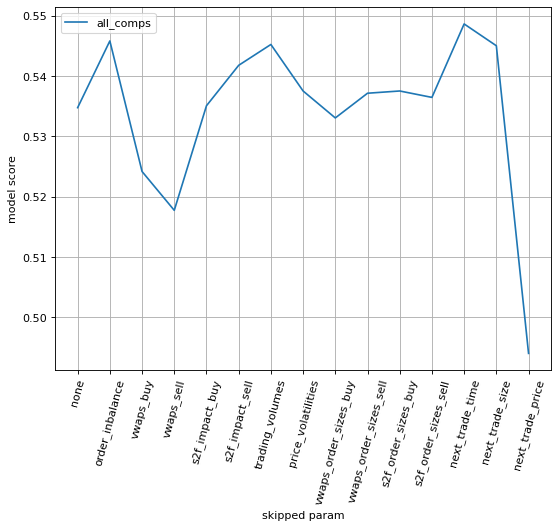

In [89]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
 ### DRZEWO

# find threshold for price swing

In [211]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=5
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names=[   
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    'next_trade_price',
    'true_price'
]
thresholds=np.geomspace(1e-3, 1e-10, num=8)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [146]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        print(y.shape)
        comp_ths[comp_id,th]=logistic_regr(X, y,split_percent, check_up_down=False, track_params=False)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -2.226298905535126
vwaps_buy   -0.15847753515344531
vwaps_sell   1.6977765079299565
next_trade_price   1.9757033535081434
threshold  0.0001
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.5139739362839775
vwaps_buy   -0.5861448294007612
vwaps_sell   -1.051185834087683
next_trade_price   2.141575048709088
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -2.006338021781292
vwaps_buy   -0.7068133047728501
vwaps_sell   -0.8852388281409201
next_trade_price   1.6405205187251715
threshold  1e-06
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.027243043790667
vwaps_buy   -0.7102589147133257
vwaps_sell   -0.6434459304098908
next_trade_price   1.4038115500892785
threshold  1e-07
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -1.735734185828877
vwaps_buy   -0.6410420910509359
vwaps_sell 

<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


  -0.7643065113423445
next_trade_price   1.6591198910027818
threshold  1e-08
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -2.1717609587180227
vwaps_buy   -0.6029472254899169
vwaps_sell   -0.8656578458260205
next_trade_price   1.5567789331149513
threshold  1e-09
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.2854420002617153
vwaps_buy   -0.6575042317744016
vwaps_sell   -0.9155280349826399
next_trade_price   1.5688116982308893
threshold  1e-10
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -1.8778733656421138
vwaps_buy   -0.5164609908069762
vwaps_sell   -0.4126176435519375
next_trade_price   1.4582432015635387
1
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.1347390897098006
vwaps_buy   0.8026456366011359
vwaps_sell   2.756805475187309
next_trade_price   0.46412745688943735
threshold  0.0001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.2128182401346669
vwaps_buy   0.0413369436807777
vwaps_sell   1.2127780977409477
next_trade_price   1.0882146639134933
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.0607587308717996
vwaps_buy   -0.31182692116773286
vwaps_sell   0.5646115988111013
next_trade_price   0.9179072044493711
threshold  1e-06
(4790, 4)
(4790,)
Coefficient impa

<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.9631094135478783
vwaps_buy   0.11050479442697383
vwaps_sell   -0.5045608500794748
next_trade_price   1.1594188185523149
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.8288665535798718
vwaps_buy   -0.1196635978771736
vwaps_sell   -0.05811008979629902
next_trade_price   0.3997085754715057
threshold  1e-06
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.1542906355354305
vwaps_buy   -0.8013907622376865
vwaps_sell   -0.9041386291759954
next_trade_price   1.1347757310586906
threshold  1e-07
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.4400212693248275
vwaps_buy   -0.7980266546537368
vwaps_sell   -0.9670617729141842
next_trade_price   1.2415484393315563
threshold  1e-08
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.68987187139088
vwaps_buy   -0.6878358317129053
vwaps_sell   -1.2838651652405644
next_trade_price   1.521819492925112
threshold  1e-09
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.1830202261475153
vwaps_buy   -0.9964933142338884
vwaps_sell   -0.18670905866080617
next_trade_price   0.440226104432729
threshold  1e-10
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.136681333211497
vwaps_buy   -0.9782927392717461
vwaps_sell   -0.07928474317328166
next_trade_price   0.309790736290058
4
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.2613686345666573
vwaps_buy   -1.1150571248842207
vwaps_sell   0.07642223160363652
next_trade_price   0.6497371833254981
threshold  0.0001
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4910401175879884
vwaps_buy   -1.2683740922205073
vwaps_sell   0.0541569007032167
next_trade_price   -0.3088205696889106
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.1594054088465433
vwaps_buy   -1.4345357883950107
vwaps_sell   -0.08196123712556823
next_trade_price   -0.4855297977665809
threshold  1e-06
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.27003609574329035
vwaps_buy   -1.173782790524619
vwaps_sell   -0.06375090529418966
next_trade_price   -0.22568017981919206
threshold  1e-07
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.10985110788835128
vwaps_buy   -1.2598237259822247
vwaps_sell   -0.05609390763984428
next_trade_price   -0.37229190333169354
threshold  1e-08
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.11034805950155514
vwaps_buy   -1.4181539483332741
vwaps_sell   -0.0538703502857378
next_trade_price   -0.46233963048460947
threshold  1e-09
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.2580088829582734
vwaps_buy   -1.4735617242036454
vwaps_sell   0.01971293390249313
next_trade_price   -0.6322592869993965
threshold  1e-10
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.13726979929643854
vwaps_buy   -1.2426708978175574
vwaps_sell   -0.06102180770092669
next_trade_price   -0.3869606097613668
5
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.16379604242467108
vwaps_buy   -0.18974778192429448
vwaps_sell   0.3274149265925394
next_trade_price   -0.08670520639453985
threshold  0.0001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.327337867073509
vwaps_buy   -0.9212771655189629
vwaps_sell   0.01589976027994265
next_trade_price   -0.13241501144558818
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.15910415337432224
vwaps_buy   -0.8020706981034298
vwaps_sell   -0.07435976761051842
next_trade_price   0.09649504136406577
threshold  1e-06
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.039160657501463844
vwaps_buy   -0.8298255341685236
vwaps_sell   -0.0978785083345924
next_trade_price   0.054294621252807075
threshold  1e-07
(4790, 4)
(4790

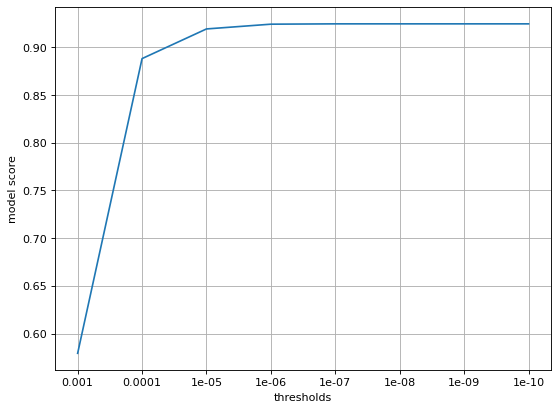

In [147]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), thresholds, rotation='0')
plt.grid()

plt.plot(np.sum(comp_ths, axis=0)/9)

In [212]:
thresholds=np.arange(5*1e-4,5*1e-4+1e-3, step=1e-4)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [265]:
np.arange(1e-4, 1e-3, step=1e-4)

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009])

In [215]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        print(y.shape)
        comp_ths[comp_id,th]=logistic_regr(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
threshold  0.0005
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -1.2195281973449006
vwaps_buy   -1.0311977671278376
vwaps_sell   0.2301893527310326
next_trade_price   0.16435409527610373
true_price   -0.2548969658164846
threshold  0.0006000000000000001
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -1.076200034601265
vwaps_buy   -1.3753784192322906
vwaps_sell   0.22326866231992917
next_trade_price   0.1948386542607708
true_price   -0.13150124251208103
threshold  0.0007000000000000001
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -1.5366117220257687
vwaps_buy   -1.06037460324396
vwaps_sell   0.5530208643063196
next_trade_price   0.4859421565721831
true_price   -0.35522722860866196
threshold  0.0008000000000000001
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -1.6268189317581765
vwaps_buy   -1.016695754217107
vwaps_sell   0.39668195588883703
next_trade_price   0.2584442502911617
true_price   -0.29646321983391927
threshold  0.0009000000000000002
(950, 5)
(

(950,)
Coefficient impact:
order_inbalance   0.8409859362849862
vwaps_buy   0.4540578566073995
vwaps_sell   0.9430381369701977
next_trade_price   0.0175171900463924
true_price   -0.18370898434783237
threshold  0.0012000000000000003
(950, 5)
(950,)
Coefficient impact:
order_inbalance   0.8838730148310601
vwaps_buy   0.4180510981005227
vwaps_sell   0.9042491383320412
next_trade_price   -0.1834461924142246
true_price   -0.23742949955561216
threshold  0.0013000000000000004
(950, 5)
(950,)
Coefficient impact:
order_inbalance   1.164320115122679
vwaps_buy   0.5818899594983639
vwaps_sell   0.6677042614391642
next_trade_price   0.32236298633809346
true_price   0.010070675112340726
threshold  0.0014000000000000004
(950, 5)
(950,)
Coefficient impact:
order_inbalance   1.0701293669174277
vwaps_buy   0.457494174739525
vwaps_sell   0.8052323053322719
next_trade_price   0.2252434917427231
true_price   -0.15611009985107424
4
threshold  0.0005
(950, 5)
true price at index 9,95 was zero!
(950,)
Coeffic

threshold  0.0005
(950, 5)
(950,)
Coefficient impact:
order_inbalance   0.3167104370920967
vwaps_buy   0.45160922593065694
vwaps_sell   1.5757044753438545
next_trade_price   -0.4698216377930753
true_price   -0.4359429546087434
threshold  0.0006000000000000001
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -0.2814133534613217
vwaps_buy   1.1005887021933902
vwaps_sell   1.9106882642569967
next_trade_price   -0.06372875120164438
true_price   -0.46721833287920067
threshold  0.0007000000000000001
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -0.4913438450905825
vwaps_buy   1.0543036385848132
vwaps_sell   2.0069127278564496
next_trade_price   -0.45290275831338905
true_price   -0.4939137221085197
threshold  0.0008000000000000001
(950, 5)
(950,)
Coefficient impact:
order_inbalance   -0.135359838589372
vwaps_buy   1.020333360748062
vwaps_sell   2.0852693281511425
next_trade_price   -0.11280927190903615
true_price   -0.37725725025425066
threshold  0.0009000000000000002
(950, 5)
(9

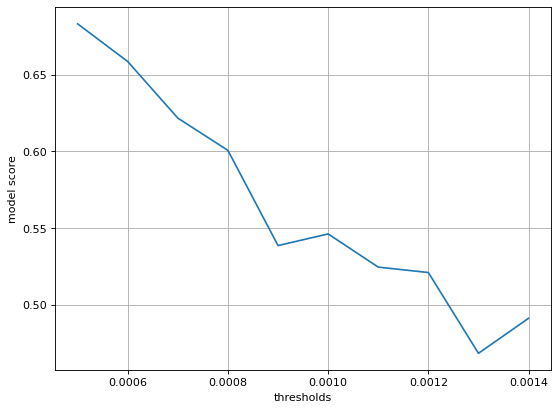

In [216]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
#plt.xticks(np.arange(len(thresholds)), thresholds, rotation='90')
plt.grid()

plt.plot(thresholds,np.sum(comp_ths, axis=0)/9)

# try different features for price swing

In [270]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
threshold=1e-3
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [274]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    scores[c,0]=logistic_regr(X, np.copy(y),split_percent, comps[c], True, check_up_down=False, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               comps[c], True, check_up_down=False, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


30.9375% of intervals were SELL empty
17.5% of intervals were BUY empty
0.3645833333333333% of intervals were set not filled
Coefficient impact:
true_price   -0.19419887232931313
order_inbalance   -1.2125624630588991
vwaps_buy   -0.6014050082171869
vwaps_sell   -0.05747992704939008
s2f_impact_buy   -0.3172306954207067
s2f_impact_sell   0.9007673852068177
trading_volumes   0.20026721710022205
price_volatilities   0.002343159798761344
vwaps_order_sizes_buy   0.06868156951360493
vwaps_order_sizes_sell   -0.09580012041851414
s2f_order_sizes_buy   0.06868156951360493
s2f_order_sizes_sell   -0.09580012041851414
next_trade_time   -0.3793673807765926
next_trade_size   -0.44680471952402256
next_trade_price   -0.039960850210735525
22.239583333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
1.40625% of intervals were set not filled
Coefficient impact:
true_price   -0.5621055538440026
order_inbalance   0.1995442171315912
vwaps_buy   -0.7911862576036682
vwaps_sell   -0.06

Coefficient impact:
true_price   0.3144326656895196
order_inbalance   0.2242183425332577
vwaps_buy   0.27657410061704074
vwaps_sell   0.923839614639853
s2f_impact_buy   -0.6050181575021037
s2f_impact_sell   -0.18828416377535406
trading_volumes   0.5744384598241609
price_volatilities   -0.14345832664123886
vwaps_order_sizes_buy   0.4126044857012361
vwaps_order_sizes_sell   -0.46742942791254205
s2f_order_sizes_buy   0.4126044857012361
s2f_order_sizes_sell   -0.46742942791254205
next_trade_time   -0.31994221487352337
next_trade_size   -0.21262356288487902
next_trade_price   -0.9977605985574964
25.364583333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
4.947916666666667% of intervals were set not filled
Coefficient impact:
true_price   -0.3618196187672141
order_inbalance   -0.3916468293945938
vwaps_buy   0.780276823556901
vwaps_sell   0.9375445748384621
s2f_impact_buy   -0.1387686003483231
s2f_impact_sell   0.6140969243826794
trading_volumes   -0.31154

24.583333333333332% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
0.8854166666666666% of intervals were set not filled
Coefficient impact:
true_price   -0.14507826197585577
order_inbalance   -0.4834525587487073
vwaps_buy   0.3781202951954254
vwaps_sell   1.2605932066390442
s2f_impact_buy   0.3628599476637046
s2f_impact_sell   -0.9796047592163493
trading_volumes   -0.6919028566067719
price_volatilities   0.19410424757653352
vwaps_order_sizes_buy   -0.743944607426628
vwaps_order_sizes_sell   0.3056276542019144
s2f_order_sizes_buy   -0.743944607426628
s2f_order_sizes_sell   0.3056276542019144
next_trade_time   0.2689639094784892
next_trade_size   -0.17787962818246386
next_trade_price   -0.20963206897072714
26.041666666666668% of intervals were SELL empty
17.395833333333332% of intervals were BUY empty
1.4583333333333333% of intervals were set not filled
Coefficient impact:
true_price   -0.3718066920497353
order_inbalance   -0.623947506903959
vwaps_buy   -1.2

Coefficient impact:
true_price   -0.6707832571925634
order_inbalance   0.10803927761750973
vwaps_buy   -0.07734107789200993
vwaps_sell   -0.14801859487942792
s2f_impact_buy   -0.2696590303623221
s2f_impact_sell   -0.2678679872424174
trading_volumes   -0.4550739476489692
price_volatilities   0.015587547829569205
vwaps_order_sizes_buy   -0.16821041368796802
vwaps_order_sizes_sell   0.40246360022116817
s2f_order_sizes_buy   -0.16821041368796802
s2f_order_sizes_sell   0.40246360022116817
next_trade_time   0.12072147044719933
next_trade_size   0.2656827533540982
next_trade_price   -0.07921173208969691
16.5625% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
0.5208333333333334% of intervals were set not filled
Coefficient impact:
true_price   0.10863806248213483
order_inbalance   -0.5514400716520051
vwaps_buy   -0.8250137027372283
vwaps_sell   0.2171586620305211
s2f_impact_buy   0.053044393145010846
s2f_impact_sell   0.2676998460202838
trading_volumes   -0.028986

18.802083333333332% of intervals were SELL empty
27.864583333333332% of intervals were BUY empty
0.5208333333333334% of intervals were set not filled
Coefficient impact:
true_price   -0.4090766699245382
order_inbalance   0.07409630500606595
vwaps_buy   0.5114866528211868
vwaps_sell   1.2745320680973578
s2f_impact_buy   1.0028166902454403
s2f_impact_sell   -0.2612284331724103
trading_volumes   0.7080878164199502
price_volatilities   -0.03935812806026553
vwaps_order_sizes_buy   -0.800114334908665
vwaps_order_sizes_sell   0.334545095679191
s2f_order_sizes_buy   -0.800114334908665
s2f_order_sizes_sell   0.334545095679191
next_trade_time   0.29728696952355776
next_trade_size   -0.20243880398915337
next_trade_price   -0.9928500123635409
16.458333333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
4.427083333333333% of intervals were set not filled
Coefficient impact:
true_price   -0.04693034413677145
order_inbalance   -0.002730448522094074
vwaps_buy   -0.99656802757

Coefficient impact:
true_price   -0.2758765930662576
order_inbalance   0.7099207095955036
vwaps_buy   0.5318110035475991
vwaps_sell   1.3166306106749557
s2f_impact_buy   -0.5133317090171512
s2f_impact_sell   0.9152331916218005
trading_volumes   0.30852773372113335
price_volatilities   0.6096050654907068
vwaps_order_sizes_buy   -0.30769625968439746
vwaps_order_sizes_sell   0.5028079877919887
s2f_order_sizes_buy   -0.30769625968439746
s2f_order_sizes_sell   0.5028079877919887
next_trade_time   0.057611370580523666
next_trade_size   0.5580043525536454
next_trade_price   0.8850018978554401
25.104166666666668% of intervals were SELL empty
15.260416666666666% of intervals were BUY empty
43.90625% of intervals were set not filled
Coefficient impact:
true_price   0.017156483891936785
order_inbalance   0.7428726254420962
vwaps_buy   0.365650745913883
vwaps_sell   1.13448996774777
s2f_impact_buy   0.12744604987110061
s2f_impact_sell   0.05759432978785642
trading_volumes   0.05570008055879291
pri

23.4375% of intervals were SELL empty
19.166666666666668% of intervals were BUY empty
2.34375% of intervals were set not filled
Coefficient impact:
true_price   -0.0973871610877414
order_inbalance   1.1239036335331303
vwaps_buy   0.42024672365648663
vwaps_sell   0.7630528130106707
s2f_impact_buy   -0.5605052113937684
s2f_impact_sell   0.20568691444312326
trading_volumes   -0.22878118342961487
price_volatilities   -0.29995985748010534
vwaps_order_sizes_buy   -0.0305630823356603
vwaps_order_sizes_sell   0.7775734273646306
s2f_order_sizes_buy   -0.0305630823356603
s2f_order_sizes_sell   0.7775734273646306
next_trade_time   -0.44468481846775415
next_trade_size   -0.12566382644971866
next_trade_price   -0.366123550343356
15.364583333333334% of intervals were SELL empty
28.59375% of intervals were BUY empty
2.1354166666666665% of intervals were set not filled
Coefficient impact:
true_price   0.09179768968826085
order_inbalance   0.028450156195508156
vwaps_buy   0.5643216870425123
vwaps_sell 

Coefficient impact:
true_price   -0.11852270455416172
order_inbalance   0.7047430498514379
vwaps_buy   0.0873032832977218
vwaps_sell   1.412701335035559
s2f_impact_buy   -0.5798212916343476
s2f_impact_sell   -0.07053860182336205
trading_volumes   0.49735231685445136
price_volatilities   -0.2823428816567815
vwaps_order_sizes_buy   0.2530105701240933
vwaps_order_sizes_sell   -0.25659343362742537
s2f_order_sizes_buy   0.2530105701240933
s2f_order_sizes_sell   -0.25659343362742537
next_trade_time   0.5767758240945247
next_trade_size   0.3608109538044123
next_trade_price   0.9133369695591114
26.5625% of intervals were SELL empty
19.947916666666668% of intervals were BUY empty
1.4583333333333333% of intervals were set not filled
Coefficient impact:
true_price   -0.46301427716610205
order_inbalance   0.17523838348214868
vwaps_buy   0.24319571688848882
vwaps_sell   0.6223768937676035
s2f_impact_buy   0.542783807577421
s2f_impact_sell   -0.14299648185576438
trading_volumes   -0.2086189518576260

25.729166666666668% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
4.791666666666667% of intervals were set not filled
Coefficient impact:
true_price   0.05331557679054895
order_inbalance   -0.2964001575406244
vwaps_buy   -0.07400236357188057
vwaps_sell   0.9932433534678736
s2f_impact_buy   -0.2864027308188478
s2f_impact_sell   -0.3133421630069794
trading_volumes   -0.908676256623673
price_volatilities   -0.3799574829447271
vwaps_order_sizes_buy   0.4806929523114714
vwaps_order_sizes_sell   -0.5533965862613268
s2f_order_sizes_buy   0.4806929523114714
s2f_order_sizes_sell   -0.5533965862613268
next_trade_time   -0.2089566295478726
next_trade_size   0.6262647711793057
next_trade_price   0.25631420523681575
16.25% of intervals were SELL empty
27.395833333333332% of intervals were BUY empty
3.1770833333333335% of intervals were set not filled
Coefficient impact:
true_price   -0.39973248999692795
order_inbalance   0.6236412618551204
vwaps_buy   0.5798641187152


skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.4895177456702013
s2f_impact_buy   0.4211557508843721
s2f_impact_sell   -0.4569274575196446
trading_volumes   -0.49877142408620073
price_volatilities   -0.3241156444350655
vwaps_order_sizes_buy   -0.34007245068688086
vwaps_order_sizes_sell   -0.7153631945797891
s2f_order_sizes_buy   -0.4502377017089164
s2f_order_sizes_sell   0.2831985976040123
next_trade_time   -0.4502377017089164
next_trade_size   0.2831985976040123
next_trade_price   -0.10440005277143846
true_price   -0.1379569911341878
order_inbalance   -0.535217050318107
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.5463241020207463
s2f_impact_sell   0.3324648008772268
trading_volumes   -0.7448963156085465
price_volatilities   -0.20874610233478724
vwaps_order_sizes_buy   -0.29833148141645144
vwaps_order_sizes_sell   -0.44431827490435716
s2f_order_sizes_buy   -0.5064844476789392
s2f_order_sizes_sell   -0.5162506752134194
next_trade_time   0.3477034701027939

Coefficient impact:
vwaps_sell   0.07425756522023531
s2f_impact_buy   -0.33164429055239475
s2f_impact_sell   0.7456704270103254
trading_volumes   0.4264695877014262
price_volatilities   -1.2286243454504888
vwaps_order_sizes_buy   0.10306520671592993
vwaps_order_sizes_sell   0.8462155922147377
s2f_order_sizes_buy   -0.4375539891225483
s2f_order_sizes_sell   0.38825614212045756
next_trade_time   -0.4375539891225483
next_trade_size   0.38825614212045756
next_trade_price   -0.45976265850843373
true_price   0.1529058237574299
order_inbalance   -0.44727987160399474
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.10981490004541446
s2f_impact_sell   -0.22537024163715577
trading_volumes   0.4847601083495268
price_volatilities   0.27700159354938914
vwaps_order_sizes_buy   -0.7692521529253192
vwaps_order_sizes_sell   -0.01975753271380048
s2f_order_sizes_buy   0.7708585880386242
s2f_order_sizes_sell   -0.312983590664068
next_trade_time   0.35206776065843515
next_trade_size   -0.3129835

Coefficient impact:
vwaps_sell   0.010409905888610248
s2f_impact_buy   0.49152301830396067
s2f_impact_sell   0.8173320285318544
trading_volumes   -0.05511129444761605
price_volatilities   -0.0943366815859396
vwaps_order_sizes_buy   -0.5699189393860918
vwaps_order_sizes_sell   -0.3236871700251648
s2f_order_sizes_buy   0.028623962143219536
s2f_order_sizes_sell   0.7296321456516428
next_trade_time   0.028623962143219536
next_trade_size   0.7296321456516428
next_trade_price   -0.4438406730990348
true_price   -0.6329207044374718
order_inbalance   -0.172667253091399
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.05716148088160405
s2f_impact_sell   0.6118865302648869
trading_volumes   0.16297386261639957
price_volatilities   0.15700736739204235
vwaps_order_sizes_buy   -0.33503000076601697
vwaps_order_sizes_sell   -0.33353445340246657
s2f_order_sizes_buy   -0.29141517505654824
s2f_order_sizes_sell   -0.0017072144604318685
next_trade_time   0.7349081177932748
next_trade_size   -0.

Coefficient impact:
next_trade_price   -0.39285396980694787
true_price   0.9762262117177679
order_inbalance   -0.5418420945373323
vwaps_buy   -0.14206767860581246
vwaps_sell   1.2982319940095284
s2f_impact_buy   0.16777596980886417
s2f_impact_sell   -0.30885383257371807
trading_volumes   -0.08251263514860555
price_volatilities   0.877458105156482
vwaps_order_sizes_buy   0.04003379137526678
vwaps_order_sizes_sell   0.877458105156482
s2f_order_sizes_buy   0.04003379137526678
s2f_order_sizes_sell   -0.5267375699735006
next_trade_time   -0.07033477202809675
skipped  next_trade_size 

Coefficient impact:
true_price   -0.39893904125098967
order_inbalance   0.7157599447234143
vwaps_buy   -0.7587019330394184
vwaps_sell   -0.30988403459383823
s2f_impact_buy   1.2178682013546456
s2f_impact_sell   0.08456212843108134
trading_volumes   -0.10255014575667447
price_volatilities   -0.019917111909585603
vwaps_order_sizes_buy   0.7333587208930336
vwaps_order_sizes_sell   0.037361295387071246
s2f_order_s

skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.19745671355153657
true_price   0.42200409345672496
order_inbalance   -1.2016715068598331
vwaps_buy   1.058211161992667
vwaps_sell   -0.10801954723480442
s2f_impact_buy   -0.6575175550186135
s2f_impact_sell   -0.8182278039728235
trading_volumes   -0.026922755922077855
price_volatilities   -0.6742857453470104
vwaps_order_sizes_buy   0.49076220968382134
vwaps_order_sizes_sell   -0.6742857453470104
s2f_order_sizes_buy   0.49076220968382134
s2f_order_sizes_sell   -0.5594963843563384
next_trade_time   -0.39389499848654375
skipped  next_trade_size 

Coefficient impact:
true_price   -0.4046962131508915
order_inbalance   0.5884402328760551
vwaps_buy   -1.147398748684869
vwaps_sell   0.8670289348479026
s2f_impact_buy   0.10550794321134202
s2f_impact_sell   -0.2765424604237677
trading_volumes   -0.793958125570636
price_volatilities   0.14500337133632912
vwaps_order_sizes_buy   -0.48228913848547933
vwaps_order_sizes_sell   0.3960

Coefficient impact:
true_price   -0.5599622164182638
order_inbalance   -0.545995570011992
vwaps_buy   0.5549683417536668
vwaps_sell   2.1048260402257633
s2f_impact_buy   -0.22475041998685574
s2f_impact_sell   -0.8346517382606267
trading_volumes   -0.6380720829937873
price_volatilities   -0.03190883260155217
vwaps_order_sizes_buy   -0.1949491116157282
vwaps_order_sizes_sell   0.18818651117094432
s2f_order_sizes_buy   -0.1949491116157282
s2f_order_sizes_sell   0.18818651117094432
next_trade_time   -1.1741150157659752
next_trade_size   -0.3619482900726063
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.5151257036768943
vwaps_buy   0.5345595685480422
vwaps_sell   0.9605096533566293
s2f_impact_buy   -0.4564309969783827
s2f_impact_sell   0.43129498333256994
trading_volumes   -0.6648030601689575
price_volatilities   -0.4252996212118638
vwaps_order_sizes_buy   -0.007424751795682285
vwaps_order_sizes_sell   0.4204249405439288
s2f_order_sizes_buy   -0.007424751795682285
s2f_

skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.4945463265222831
vwaps_buy   0.7265867400034631
vwaps_sell   1.0293881915041152
s2f_impact_buy   -0.5748388633353195
s2f_impact_sell   0.688733003462662
trading_volumes   0.9501595242219333
price_volatilities   0.17231207167058316
vwaps_order_sizes_buy   0.6023014189051584
vwaps_order_sizes_sell   0.5191509493344882
s2f_order_sizes_buy   0.6023014189051584
s2f_order_sizes_sell   0.5191509493344882
next_trade_time   -1.0133297079707395
next_trade_size   -0.15780840518585534
next_trade_price   -0.24124812538565768
skipped  true_price 

Coefficient impact:
vwaps_buy   0.024664888360777723
vwaps_sell   0.9022538747077771
s2f_impact_buy   1.1814866482642432
s2f_impact_sell   -0.8668222502109091
trading_volumes   0.9804694072765996
price_volatilities   1.0479895941597606
vwaps_order_sizes_buy   0.02621934187212159
vwaps_order_sizes_sell   0.6488206310770943
s2f_order_sizes_buy   0.5861667632248981
s2f_order_sizes_sell   0.64

Coefficient impact:
next_trade_time   -0.10081086831754721
next_trade_size   -0.04298819345220935
next_trade_price   0.3894108711885338
true_price   0.7967919599005477
order_inbalance   0.6244936461435073
vwaps_buy   0.8914677378263193
vwaps_sell   0.27138284246262695
s2f_impact_buy   -0.09714108467916784
s2f_impact_sell   -0.5838332037820724
trading_volumes   0.9396222746318366
price_volatilities   -0.5838332037820724
vwaps_order_sizes_buy   0.5761607937869552
vwaps_order_sizes_sell   0.5587817434094977
s2f_order_sizes_buy   -0.16823849831548648
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.12626548490307068
next_trade_price   -0.3566890651219818
true_price   0.23650153715337352
order_inbalance   0.7268164231908575
vwaps_buy   0.6475458934814754
vwaps_sell   0.7766531011014471
s2f_impact_buy   0.055261554430589346
s2f_impact_sell   -0.01687388218864192
trading_volumes   -0.5938681704353579
price_volatilities   0.38098145711414616
vwaps_order_sizes_buy   -0.5

Coefficient impact:
s2f_order_sizes_sell   0.2825361534730168
next_trade_time   0.046115294911906295
next_trade_size   0.24727018805111697
next_trade_price   0.9703816424887548
true_price   -0.8331510927456581
order_inbalance   -0.09325815914799548
vwaps_buy   0.6312690826074995
vwaps_sell   0.2714358035242906
s2f_impact_buy   0.49494515515211973
s2f_impact_sell   -0.34430049261864426
trading_volumes   -0.34430049261864426
price_volatilities   -0.2860210483190807
vwaps_order_sizes_buy   -0.13862724289771233
vwaps_order_sizes_sell   -1.0975196049159344
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.38441819509806757
next_trade_size   0.08497286338567038
next_trade_price   -0.05829557209534788
true_price   1.0163908984586691
order_inbalance   -0.5727217493311278
vwaps_buy   -0.1261268659890936
vwaps_sell   0.37898214847134204
s2f_impact_buy   0.03609663255742533
s2f_impact_sell   0.6491053878658889
trading_volumes   -0.2939931313361368
price_volatilities   0.64910

Coefficient impact:
true_price   -0.3463691027038299
order_inbalance   -0.5618444182478396
vwaps_buy   0.6978091868013943
vwaps_sell   0.9234609860168153
s2f_impact_buy   -0.29399789067615306
s2f_impact_sell   0.6524144478368855
trading_volumes   -0.11403241367104877
price_volatilities   0.05533095748029524
vwaps_order_sizes_buy   -0.5372359769438702
vwaps_order_sizes_sell   0.29986782187226163
s2f_order_sizes_buy   -0.5372359769438702
s2f_order_sizes_sell   0.29986782187226163
next_trade_time   -0.42074284780044496
next_trade_size   -0.2817182821012453
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.15302148357546994
vwaps_buy   0.30716863428486985
vwaps_sell   0.5319159808602323
s2f_impact_buy   -0.4850637792611032
s2f_impact_sell   0.13716748161923603
trading_volumes   0.16307055478019006
price_volatilities   -0.04239915989505704
vwaps_order_sizes_buy   0.8706327436908509
vwaps_order_sizes_sell   0.04129081854463148
s2f_order_sizes_buy   0.8706327436908509
s2f_o

Coefficient impact:
next_trade_size   0.004113184754218105
next_trade_price   0.7467610614989224
true_price   1.7162651858745577
order_inbalance   -0.1185758936691042
vwaps_buy   -0.11948081713335817
vwaps_sell   0.4604971609141319
s2f_impact_buy   -0.15333921022668132
s2f_impact_sell   0.23147015058797063
trading_volumes   0.1667370997349734
price_volatilities   -0.11055187096456763
vwaps_order_sizes_buy   0.1667370997349734
vwaps_order_sizes_sell   -0.11055187096456763
s2f_order_sizes_buy   -0.7606204822256082
s2f_order_sizes_sell   -0.06796314026327811
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.06250457242379906
true_price   1.157546751498615
order_inbalance   1.8831124280246938
vwaps_buy   -0.48630130559530105
vwaps_sell   0.11317764569990989
s2f_impact_buy   0.3801818136391129
s2f_impact_sell   -0.6104865817447384
trading_volumes   0.2688243162701149
price_volatilities   0.027223967492606613
vwaps_order_sizes_buy   0.27299554663298015
vwaps_order_sizes_se

Coefficient impact:
next_trade_time   -0.037146971155888726
next_trade_size   0.883665113705609
next_trade_price   0.4959363166568244
true_price   1.4957500763332985
order_inbalance   0.03377143030662949
vwaps_buy   -1.3711983728395847
vwaps_sell   -1.0634001503365402
s2f_impact_buy   0.09625572942964374
s2f_impact_sell   -0.2547361979334015
trading_volumes   -0.5977185433131403
price_volatilities   -0.2547361979334015
vwaps_order_sizes_buy   0.3175720000857648
vwaps_order_sizes_sell   -0.26317969952938636
s2f_order_sizes_buy   0.05337789161517193
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.14928863295161132
next_trade_price   0.8741535703405545
true_price   0.607345342091601
order_inbalance   1.4256935699262028
vwaps_buy   -0.3183207726804479
vwaps_sell   -1.2855573368294348
s2f_impact_buy   -0.8241035760142774
s2f_impact_sell   0.11171583169955084
trading_volumes   -0.49130561273346096
price_volatilities   -0.5219911051649925
vwaps_order_sizes_buy   -0.49

Coefficient impact:
s2f_order_sizes_buy   -0.47165673679449255
s2f_order_sizes_sell   -0.899577801825651
next_trade_time   0.05388270942734213
next_trade_size   0.610431282131025
next_trade_price   0.41146230259970334
true_price   -0.5392172461026267
order_inbalance   0.19876783353306549
vwaps_buy   0.9258348388350714
vwaps_sell   -0.03757141449860681
s2f_impact_buy   -0.03757141449860681
s2f_impact_sell   -0.05048899701427097
trading_volumes   -0.5469506246284969
price_volatilities   0.6913910206214311
vwaps_order_sizes_buy   -0.5808653546236887
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.3986182280382118
next_trade_time   -0.5920806728908838
next_trade_size   0.016113591106225914
next_trade_price   0.724650381183754
true_price   0.5329009028990866
order_inbalance   -0.3876757683810059
vwaps_buy   0.12207318300745958
vwaps_sell   0.9355198582360167
s2f_impact_buy   0.03207753676049947
s2f_impact_sell   -0.10993006351232108
trading_volumes   -0.10993

Coefficient impact:
s2f_order_sizes_sell   0.10891921672308137
next_trade_time   0.098451591005012
next_trade_size   -1.396110100920185
next_trade_price   -0.004113947315666837
true_price   0.8337051841671091
order_inbalance   0.2798805925999696
vwaps_buy   -0.5296503938825491
vwaps_sell   -0.1500172250820975
s2f_impact_buy   0.04084697512421266
s2f_impact_sell   -0.5656827446112688
trading_volumes   -0.5656827446112688
price_volatilities   -0.2234532757789118
vwaps_order_sizes_buy   0.17462521011046922
vwaps_order_sizes_sell   -0.7975863568170223
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.20249314278199027
next_trade_size   0.403519832114698
next_trade_price   -1.3509072122594805
true_price   0.013672993510708529
order_inbalance   0.6235234481488033
vwaps_buy   0.2982520170004732
vwaps_sell   -0.19138115861720278
s2f_impact_buy   -0.13118503390124353
s2f_impact_sell   0.20067738970356122
trading_volumes   -0.6819658764215722
price_volatilities   0.200677389

next_trade_time   -0.40874251889193175
skipped  next_trade_size 

Coefficient impact:
true_price   -0.11706193848107546
order_inbalance   0.25972188588754186
vwaps_buy   -0.13760117795866733
vwaps_sell   0.40832726692091803
s2f_impact_buy   -1.377857764604809
s2f_impact_sell   -0.5801124874974553
trading_volumes   0.6650400031109085
price_volatilities   -0.3503803507592453
vwaps_order_sizes_buy   0.3461433825455379
vwaps_order_sizes_sell   0.5490573988571986
s2f_order_sizes_buy   0.3461433825455379
s2f_order_sizes_sell   0.5490573988571986
next_trade_time   0.25133375730457613
next_trade_size   -0.7560800226822004
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.5590170407444953
vwaps_buy   -0.6167200133239531
vwaps_sell   -0.03790474648277904
s2f_impact_buy   -0.5967668160120633
s2f_impact_sell   -0.19696282761440534
trading_volumes   0.34653278456425185
price_volatilities   -1.0777951179778447
vwaps_order_sizes_buy   0.20232856318988662
vwaps_order_sizes_sell   0.

Coefficient impact:
vwaps_buy   0.032942881691663574
vwaps_sell   -0.38057937329892444
s2f_impact_buy   -0.06834947717274718
s2f_impact_sell   1.6659897456963895
trading_volumes   0.024110496942076728
price_volatilities   0.0939019663388737
vwaps_order_sizes_buy   0.6774336688789316
vwaps_order_sizes_sell   0.27991876369204255
s2f_order_sizes_buy   1.0076965534484514
s2f_order_sizes_sell   0.27991876369204255
next_trade_time   1.0076965534484514
next_trade_size   -0.3702937563555589
next_trade_price   0.310967984107906
true_price   -0.19593639805150473
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.05726302350686749
s2f_impact_buy   -0.05326052684789281
s2f_impact_sell   -0.3629450976708699
trading_volumes   1.7331914303647078
price_volatilities   -0.16056643078122645
vwaps_order_sizes_buy   0.3951709312106182
vwaps_order_sizes_sell   0.7739028241267623
s2f_order_sizes_buy   0.48314967544703974
s2f_order_sizes_sell   1.090781174408561
next_trade_time   0.483149675447039

Coefficient impact:
vwaps_sell   -0.1804280026595827
s2f_impact_buy   -0.3378379227695989
s2f_impact_sell   1.3794761353369698
trading_volumes   0.3880521922933628
price_volatilities   -0.8349981992761842
vwaps_order_sizes_buy   -0.7704492159007275
vwaps_order_sizes_sell   0.1948828307622768
s2f_order_sizes_buy   -0.7528546947296824
s2f_order_sizes_sell   0.37744003070190163
next_trade_time   -0.7528546947296824
next_trade_size   0.37744003070190163
next_trade_price   0.20149144499443128
true_price   0.028643326365253106
order_inbalance   0.013438032239748779
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.20729469246614407
s2f_impact_sell   -0.5412262426544812
trading_volumes   0.8309276385441903
price_volatilities   0.10700051441847834
vwaps_order_sizes_buy   -0.963157129848476
vwaps_order_sizes_sell   -0.6027626844927165
s2f_order_sizes_buy   0.41234209001571986
s2f_order_sizes_sell   -0.7252162720647825
next_trade_time   0.37287102790626864
next_trade_size   -0.7252162

Coefficient impact:
trading_volumes   -0.5591783245573877
price_volatilities   -0.6259855521137642
vwaps_order_sizes_buy   -1.1125620261149691
vwaps_order_sizes_sell   0.778382499598036
s2f_order_sizes_buy   0.11955484169880985
s2f_order_sizes_sell   -0.3377818146924731
next_trade_time   -0.26697204114022094
next_trade_size   -0.0502340299865232
next_trade_price   -0.22010413885349897
true_price   -0.0502340299865232
order_inbalance   -0.22010413885349897
vwaps_buy   -0.5727055832701621
vwaps_sell   -0.7522115792593873
s2f_impact_buy   -0.26808735108292026
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.36706226810213094
vwaps_order_sizes_buy   -0.69161290480889
vwaps_order_sizes_sell   -0.8953185802225784
s2f_order_sizes_buy   0.4940463052323326
s2f_order_sizes_sell   0.1113847853699371
next_trade_time   -0.6554398611522151
next_trade_size   -0.11173756888966202
next_trade_price   -0.09507349086758862
true_price   -0.0311938804023173
order_inbalance   -0.0950734

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.12773466606336484
vwaps_order_sizes_sell   -0.47770492146502924
s2f_order_sizes_buy   -0.5188866312891826
s2f_order_sizes_sell   0.15916247105980003
next_trade_time   -0.5580209256695738
next_trade_size   -0.1436724311110491
next_trade_price   0.1716586709777988
true_price   -0.05968055217818449
order_inbalance   0.633302387528047
vwaps_buy   -0.05968055217818449
vwaps_sell   0.633302387528047
s2f_impact_buy   -0.43739015047809
s2f_impact_sell   0.10348213021063152
trading_volumes   -0.1600670805430192
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.07216967444546613
s2f_order_sizes_buy   -0.8575054315014602
s2f_order_sizes_sell   -0.29653813365350634
next_trade_time   0.24780685921748638
next_trade_size   -0.4875455893978756
next_trade_price   -0.2623349535264706
true_price   0.1610755949507339
order_inbalance   -0.12389526724144938
vwaps_buy   0.48078570394964004
vwaps_sell   -0.1638

vwaps_buy   0.3525396618425247
vwaps_sell   -0.2241086625645671
s2f_impact_buy   -0.20601417488336687
s2f_impact_sell   -0.2950447408756597
trading_volumes   -0.5436599578602712
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.32100931047917836
s2f_order_sizes_buy   0.15000202687878675
s2f_order_sizes_sell   0.3483037180980288
next_trade_time   1.1343972086533443
next_trade_size   0.059593497146024264
next_trade_price   -0.34415951177553367
true_price   0.21962596022231726
order_inbalance   0.36062780941423617
vwaps_buy   -0.23108189703364473
vwaps_sell   0.5206755912467892
s2f_impact_buy   -0.23108189703364473
s2f_impact_sell   0.10755380679807056
trading_volumes   -0.24889355912888814
price_volatilities   -0.5636693597495376
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.44048797918336885
s2f_order_sizes_sell   0.3937148173587878
next_trade_time   0.4296703746297653
next_trade_size   1.1219489052163782
next_trade_price   0.0

Coefficient impact:
vwaps_order_sizes_sell   -0.405014887846203
s2f_order_sizes_buy   -0.003198163987263085
s2f_order_sizes_sell   -0.10673064174166569
next_trade_time   -0.03644481463754349
next_trade_size   0.06645121624412717
next_trade_price   0.8767861792634674
true_price   0.053803797408081826
order_inbalance   -0.4035506942032955
vwaps_buy   0.3238290059540448
vwaps_sell   -0.42459454229907484
s2f_impact_buy   0.3238290059540448
s2f_impact_sell   0.8131467500308454
trading_volumes   -0.48389382410886167
price_volatilities   0.024192141220649884
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.5402497544532601
s2f_order_sizes_sell   -0.03706185801569788
next_trade_time   0.08609641876719919
next_trade_size   0.026459725811885222
next_trade_price   0.6201830370807467
true_price   0.5277482879822434
order_inbalance   0.1844932236711784
vwaps_buy   -0.40605319820458985
vwaps_sell   -0.22760954952670331
s2f_impact_buy   -0.22760954952670331
s2f_impact_sel

Coefficient impact:
next_trade_size   -0.23189509568381367
next_trade_price   0.7314133529446241
true_price   0.640522145876283
order_inbalance   0.230393487630061
vwaps_buy   0.7911824558213852
vwaps_sell   0.06769189380732313
s2f_impact_buy   0.31690201602565937
s2f_impact_sell   0.12641264758527135
trading_volumes   -0.2422964168437982
price_volatilities   0.4212793482636844
vwaps_order_sizes_buy   -0.2422964168437982
vwaps_order_sizes_sell   0.4212793482636844
s2f_order_sizes_buy   0.17458096864545938
s2f_order_sizes_sell   -0.47125590631660447
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.1569563415927348
true_price   0.8152101238124259
order_inbalance   0.601831020065558
vwaps_buy   0.020330939380929395
vwaps_sell   1.2886488105229699
s2f_impact_buy   0.13697137111341817
s2f_impact_sell   0.5471994647226621
trading_volumes   0.22195144976679237
price_volatilities   -0.12601903241540163
vwaps_order_sizes_buy   0.5239617797043928
vwaps_order_sizes_sell   -0.1

vwaps_order_sizes_buy   -0.9452197515852947
vwaps_order_sizes_sell   -0.3695131230606888
s2f_order_sizes_buy   -0.24930814948339905
s2f_order_sizes_sell   0.32528162845965386
next_trade_time   -0.24930814948339905
next_trade_size   0.32528162845965386
next_trade_price   0.7159156730308286
true_price   -0.3518714036541467
order_inbalance   -1.0152623808989871
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.003983455494846693
s2f_impact_sell   -0.1898342256420682
trading_volumes   1.9330968762263587
price_volatilities   0.21723114035921903
vwaps_order_sizes_buy   0.14278268314506892
vwaps_order_sizes_sell   -0.7052631316964176
s2f_order_sizes_buy   -0.6414683983179884
s2f_order_sizes_sell   -0.18200687713335037
next_trade_time   0.4387939376011492
next_trade_size   -0.18200687713335037
next_trade_price   0.4387939376011492
true_price   0.7561192398782086
order_inbalance   -0.7829717885314905
vwaps_buy   -1.3398635085929298
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_

Coefficient impact:
vwaps_sell   -0.3204624745752196
s2f_impact_buy   -0.2544683498806166
s2f_impact_sell   0.10154837415236723
trading_volumes   0.19610299569221026
price_volatilities   -0.17704743817840227
vwaps_order_sizes_buy   0.0017686278126587658
vwaps_order_sizes_sell   -0.047167659516932775
s2f_order_sizes_buy   -0.3660829318848557
s2f_order_sizes_sell   0.3727345225667368
next_trade_time   -0.3660829318848557
next_trade_size   0.3727345225667368
next_trade_price   0.12069483038930266
true_price   -0.7568467738279459
order_inbalance   -1.3631837038263726
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.22846794392516656
s2f_impact_sell   -0.49954374071125485
trading_volumes   -0.10141954740064765
price_volatilities   0.0030374030142683527
vwaps_order_sizes_buy   -0.5413020710772672
vwaps_order_sizes_sell   -0.03583337787505085
s2f_order_sizes_buy   -0.14669259091436238
s2f_order_sizes_sell   -0.4623495505639248
next_trade_time   0.23413104726337722
next_trade_size 

skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.274111751068533
vwaps_order_sizes_buy   0.35988977137945716
vwaps_order_sizes_sell   1.715412164625791
s2f_order_sizes_buy   1.1455167734329232
s2f_order_sizes_sell   0.7308304652340301
next_trade_time   0.0497835620568373
next_trade_size   -0.47284377363692165
next_trade_price   -0.10097235752374029
true_price   -0.26718845455814766
order_inbalance   -0.10097235752374029
vwaps_buy   -0.26718845455814766
vwaps_sell   1.147300837631746
s2f_impact_buy   0.6701732234528254
s2f_impact_sell   -0.5162920221576052
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.36129873041657673
vwaps_order_sizes_sell   -0.0036307867669355723
s2f_order_sizes_buy   1.7053244988416123
s2f_order_sizes_sell   1.4907199162922453
next_trade_time   0.6571563504162028
next_trade_size   0.36291439282639887
next_trade_price   -0.9778795246018671
true_price   -0.27245383215440816
order_inbalance   -0.4257429112435991
vwaps_b

Coefficient impact:
vwaps_order_sizes_buy   -0.19127704235739615
vwaps_order_sizes_sell   -0.42862245410264643
s2f_order_sizes_buy   -0.0052901268341705426
s2f_order_sizes_sell   1.1117792810436895
next_trade_time   1.3718605913207476
next_trade_size   -0.02651918934046187
next_trade_price   0.35817102192091155
true_price   -0.04044241968767013
order_inbalance   -0.5734017238942081
vwaps_buy   -0.04044241968767013
vwaps_sell   -0.5734017238942081
s2f_impact_buy   0.14496714014092618
s2f_impact_sell   -0.24009607837199906
trading_volumes   -0.7230639683397823
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.24663653199128494
s2f_order_sizes_buy   -0.38199320406634435
s2f_order_sizes_sell   -0.0362637139387118
next_trade_time   1.132781431384792
next_trade_size   1.1444048329046899
next_trade_price   0.08154755748061518
true_price   0.6891238936542166
order_inbalance   -1.6053486258433751
vwaps_buy   -0.48624691276700754
vwaps_sell   -0.07449851704218115
s2f_

Coefficient impact:
vwaps_order_sizes_sell   -0.7131215555161345
s2f_order_sizes_buy   0.1994578011939122
s2f_order_sizes_sell   -0.272088909802128
next_trade_time   -0.14257555890157744
next_trade_size   -0.32500206713275953
next_trade_price   -0.3636405923736102
true_price   -0.4589306102766468
order_inbalance   -0.014284382164865312
vwaps_buy   0.43001549076044376
vwaps_sell   -0.3078217831962322
s2f_impact_buy   0.43001549076044376
s2f_impact_sell   0.010413116744456124
trading_volumes   0.12110242460634513
price_volatilities   -0.19239249185345753
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.7406106379671152
s2f_order_sizes_sell   0.28490783835096023
next_trade_time   -0.16170824396741942
next_trade_size   -0.2899978484846349
next_trade_price   -0.32918364448255755
true_price   -0.27462918553575183
order_inbalance   -0.43884107892949925
vwaps_buy   0.053678463202725374
vwaps_sell   -0.11351698209012552
s2f_impact_buy   -0.11351698209012552
s2f_impa

Coefficient impact:
s2f_order_sizes_sell   0.007012210756985207
next_trade_time   -0.6130105656207983
next_trade_size   -0.7401580137820873
next_trade_price   0.1531455287849518
true_price   0.04216641291792899
order_inbalance   0.1935088061849717
vwaps_buy   -0.08680004127138494
vwaps_sell   0.3588540422739688
s2f_impact_buy   0.672530616669994
s2f_impact_sell   -0.05033178583065848
trading_volumes   -0.05033178583065848
price_volatilities   -0.2979601387366116
vwaps_order_sizes_buy   -0.3829595119426555
vwaps_order_sizes_sell   -0.721617697855237
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -0.06317068283040929
next_trade_size   -0.64231696638896
next_trade_price   -0.6740221188956993
true_price   0.24658356167023554
order_inbalance   -0.04050715352523401
vwaps_buy   0.12423288309741162
vwaps_sell   -0.016698911198682526
s2f_impact_buy   0.38670149504356943
s2f_impact_sell   0.4387054088825265
trading_volumes   -0.04977491638626524
price_volatilities   0.43870

skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.02216669258924028
true_price   0.2745763617197958
order_inbalance   -0.6449077423224265
vwaps_buy   0.17537260893544712
vwaps_sell   1.136539493321419
s2f_impact_buy   -0.5959218985992196
s2f_impact_sell   0.19713668317298147
trading_volumes   -0.008099329004494763
price_volatilities   -0.09363986684165032
vwaps_order_sizes_buy   -0.3956869407486897
vwaps_order_sizes_sell   -0.09363986684165032
s2f_order_sizes_buy   -0.3956869407486897
s2f_order_sizes_sell   0.30198634764334126
next_trade_time   -1.059999199265921
skipped  next_trade_size 

Coefficient impact:
true_price   0.04403927320501773
order_inbalance   -0.019270293992324276
vwaps_buy   -0.917558519809155
vwaps_sell   0.9153877862573561
s2f_impact_buy   1.0107456242150947
s2f_impact_sell   -0.5389969665081129
trading_volumes   -0.05864468043763079
price_volatilities   0.00877017936388252
vwaps_order_sizes_buy   0.18669245995663916
vwaps_order_sizes_sell   -0.48

Coefficient impact:
order_inbalance   -0.033967041004068464
vwaps_buy   -0.25715755320757805
vwaps_sell   0.09938808180936909
s2f_impact_buy   0.5304326420048011
s2f_impact_sell   0.4091133402578715
trading_volumes   0.2530938831295349
price_volatilities   -0.07122085190857505
vwaps_order_sizes_buy   0.4134811341835487
vwaps_order_sizes_sell   0.5676628579647119
s2f_order_sizes_buy   0.4134811341835487
s2f_order_sizes_sell   0.5676628579647119
next_trade_time   -0.16091309188163422
next_trade_size   0.6845217217443148
next_trade_price   -0.38288250536259166
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.001699825194381382
vwaps_sell   -0.22867015343158265
s2f_impact_buy   0.22395729652444596
s2f_impact_sell   0.5469486833807261
trading_volumes   0.2610735683259963
price_volatilities   0.2686597458907683
vwaps_order_sizes_buy   -0.15803710966186094
vwaps_order_sizes_sell   0.4819831166633119
s2f_order_sizes_buy   0.5618524243648214
s2f_order_sizes_sell   0.4819831166633119
nex

Coefficient impact:
vwaps_buy   -0.5113744516893841
vwaps_sell   0.6605285111068556
s2f_impact_buy   1.2588040194904488
s2f_impact_sell   -0.24929333280736993
trading_volumes   0.2012609973610638
price_volatilities   -0.2699784718098981
vwaps_order_sizes_buy   0.4782370472712314
vwaps_order_sizes_sell   0.10504649376871826
s2f_order_sizes_buy   0.40296163499186255
s2f_order_sizes_sell   0.10504649376871826
next_trade_time   0.40296163499186255
next_trade_size   -0.1261020095697506
next_trade_price   -0.33201173322695005
true_price   -0.647557324887844
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.5359922785613421
s2f_impact_buy   0.344803878546415
s2f_impact_sell   1.5813383992819094
trading_volumes   -0.48306204412981457
price_volatilities   0.10092154878161781
vwaps_order_sizes_buy   -0.5044736052736452
vwaps_order_sizes_sell   0.563972474114825
s2f_order_sizes_buy   0.023494070279422314
s2f_order_sizes_sell   0.38705555113259804
next_trade_time   0.02349407027942231

Coefficient impact:
s2f_impact_sell   -0.532384970970012
trading_volumes   -0.024236432331837438
price_volatilities   -0.350992101679827
vwaps_order_sizes_buy   1.4518527429855492
vwaps_order_sizes_sell   -0.4635549190910718
s2f_order_sizes_buy   -0.5816828515602077
s2f_order_sizes_sell   -0.13824117203294814
next_trade_time   -0.12955597723249332
next_trade_size   0.22026111496495332
next_trade_price   -0.12955597723249332
true_price   0.22026111496495332
order_inbalance   0.6450641093451418
vwaps_buy   0.07393912065012298
vwaps_sell   0.2913658997008904
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.09482077746721021
price_volatilities   0.1071344376500866
vwaps_order_sizes_buy   -0.2831167554676513
vwaps_order_sizes_sell   1.1354427424601636
s2f_order_sizes_buy   0.05112803838936503
s2f_order_sizes_sell   -0.11270053202741216
next_trade_time   -0.017700801676236107
next_trade_size   -0.3670556913304364
next_trade_price   -0.2709502065104858
true_price   -0.367055

Coefficient impact:
vwaps_order_sizes_buy   -0.2049358958557826
vwaps_order_sizes_sell   0.4091156853258501
s2f_order_sizes_buy   0.7011402675144012
s2f_order_sizes_sell   0.8695002025490745
next_trade_time   -0.7237129915081549
next_trade_size   -0.1961300134476287
next_trade_price   -0.5463704430802394
true_price   -0.0970980004412903
order_inbalance   -0.3382327160102076
vwaps_buy   -0.0970980004412903
vwaps_sell   -0.3382327160102076
s2f_impact_buy   0.7258404191740448
s2f_impact_sell   0.25960062062839945
trading_volumes   0.10175327855656402
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.15270363188555833
s2f_order_sizes_buy   0.37138975564393556
s2f_order_sizes_sell   0.6294026357557981
next_trade_time   0.8444619995883896
next_trade_size   -0.5820788761770298
next_trade_price   -0.36454810687129224
true_price   -0.3294793021190609
order_inbalance   -0.6272884526116129
vwaps_buy   -0.21886572090671375
vwaps_sell   -0.08778145891944422
s2f_impact_bu

Coefficient impact:
s2f_order_sizes_buy   -0.4016133928362992
s2f_order_sizes_sell   0.16085134830078013
next_trade_time   0.04905299141960698
next_trade_size   -0.19013895641225845
next_trade_price   0.11767869416003364
true_price   -0.6161476669375267
order_inbalance   -0.5242569913354765
vwaps_buy   0.15889451560114673
vwaps_sell   0.12536349540349076
s2f_impact_buy   0.12536349540349076
s2f_impact_sell   -0.4781297478539384
trading_volumes   0.686422012622653
price_volatilities   -0.03126392954790881
vwaps_order_sizes_buy   -0.9467672871217885
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.2580734736441058
next_trade_time   0.02842272386396335
next_trade_size   -0.06719387318067463
next_trade_price   -0.19286028990055157
true_price   0.1512958337487014
order_inbalance   -0.42458993832910996
vwaps_buy   -0.3568186358457546
vwaps_sell   0.06755826558513689
s2f_impact_buy   0.12495036051060666
s2f_impact_sell   -0.30827851787564703
trading_volumes   -0

s2f_order_sizes_sell   0.05284643534834585
next_trade_time   -0.15706233376377876
next_trade_size   -0.4075647689920185
next_trade_price   0.1708834936553142
true_price   -0.2314260242289645
order_inbalance   0.14238961966666755
vwaps_buy   0.6854581487769386
vwaps_sell   -0.4071838890479322
s2f_impact_buy   0.3780220129055539
s2f_impact_sell   1.0067220147593985
trading_volumes   1.0067220147593985
price_volatilities   -0.22109806509604155
vwaps_order_sizes_buy   0.5561162307011359
vwaps_order_sizes_sell   -0.8974226670299015
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -0.06269378322858388
next_trade_size   -0.17241766295620123
next_trade_price   -0.5065225021267283
true_price   0.28165030026782206
order_inbalance   -0.19850934504563855
vwaps_buy   0.2384465769733714
vwaps_sell   0.8139297084751869
s2f_impact_buy   -0.1932224893086134
s2f_impact_sell   0.1696509270283483
trading_volumes   1.4980771404654016
price_volatilities   0.1696509270283483
vwaps_order_s

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.3285597922132812
s2f_impact_buy   0.32083812121788663
s2f_impact_sell   1.5839085023647281
trading_volumes   1.404877846650654
price_volatilities   -0.4547634092479711
vwaps_order_sizes_buy   0.8116745031100633
vwaps_order_sizes_sell   0.0031047856030461713
s2f_order_sizes_buy   -0.5280339068041955
s2f_order_sizes_sell   0.5331971685735287
next_trade_time   -0.5280339068041955
next_trade_size   0.5331971685735287
next_trade_price   -0.07144969060115888
true_price   -0.25795243516525984
order_inbalance   -0.20641502788844943
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.20599667756009132
s2f_impact_sell   0.04256996713699992
trading_volumes   1.9255373356711407
price_volatilities   1.3141197387952868
vwaps_order_sizes_buy   0.4058161434869014
vwaps_order_sizes_sell   1.4680545244288754
s2f_order_sizes_buy   -0.14657018524074975
s2f_order_sizes_sell   -1.145682687217107
next_trade_time   0.40799208919991126
nex

s2f_impact_sell   -0.3825515544328653
trading_volumes   0.1106589008669617
price_volatilities   -0.9999982568748372
vwaps_order_sizes_buy   -0.22892870033304652
vwaps_order_sizes_sell   -0.21998144656626512
s2f_order_sizes_buy   0.037676870242580596
s2f_order_sizes_sell   -0.8977653495659211
next_trade_time   -0.030517812695009843
next_trade_size   0.8112381010107929
next_trade_price   -0.030517812695009843
true_price   0.8112381010107929
order_inbalance   0.6925494774330659
vwaps_buy   -0.2622688031734484
vwaps_sell   0.5138267350056487
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.19581119606512556
price_volatilities   0.14581967279629757
vwaps_order_sizes_buy   -0.8298141762081043
vwaps_order_sizes_sell   -0.27103012949621286
s2f_order_sizes_buy   -0.2672163220410897
s2f_order_sizes_sell   0.10022256634925776
next_trade_time   -0.8707112659944258
next_trade_size   -0.03392626754417633
next_trade_price   0.7017676878166628
true_price   -0.03392626754417633
order_

Coefficient impact:
price_volatilities   -0.1834534876183744
vwaps_order_sizes_buy   0.1770693139388849
vwaps_order_sizes_sell   0.9418981297574234
s2f_order_sizes_buy   1.7589575945571851
s2f_order_sizes_sell   -0.4823789278917343
next_trade_time   -0.03625924089662092
next_trade_size   1.0743777910998649
next_trade_price   -0.5671263013711524
true_price   -0.19459072163815097
order_inbalance   -0.5671263013711524
vwaps_buy   -0.19459072163815097
vwaps_sell   0.09554380375194561
s2f_impact_buy   -0.6982430111897431
s2f_impact_sell   0.06999715958994349
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.32704054205919303
vwaps_order_sizes_sell   0.43996066939100054
s2f_order_sizes_buy   0.9971418876637089
s2f_order_sizes_sell   1.5735263001660105
next_trade_time   -0.6661448414592482
next_trade_size   0.2827804976701469
next_trade_price   -0.16846120448571764
true_price   -0.719957616439151
order_inbalance   -0.27201713239767705
vwaps_buy   -0.719957616439151
vwa

skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.48145684506281183
s2f_order_sizes_buy   -1.1629716232079146
s2f_order_sizes_sell   0.6938273811117476
next_trade_time   0.4596732994313511
next_trade_size   0.15746751910979648
next_trade_price   0.11768251651236593
true_price   0.41572819705075
order_inbalance   0.1875302929566796
vwaps_buy   0.1783377099970735
vwaps_sell   -0.5317073563008818
s2f_impact_buy   0.1783377099970735
s2f_impact_sell   -1.1641975772748567
trading_volumes   -0.3719991372137256
price_volatilities   -0.08017881439298745
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.319291994355211
s2f_order_sizes_sell   -1.1944486631155937
next_trade_time   0.4622970088881765
next_trade_size   0.5157786306796847
next_trade_price   -0.10073198000412122
true_price   0.21258641838685094
order_inbalance   0.08524931918228762
vwaps_buy   -0.00782692796103479
vwaps_sell   -0.2749070772895292
s2f_impact_buy   -0.2749070772895

Coefficient impact:
vwaps_order_sizes_buy   0.10147918636055592
vwaps_order_sizes_sell   0.2949629500764653
s2f_order_sizes_buy   -0.4040274955856418
s2f_order_sizes_sell   0.996659828976049
next_trade_time   0.7252738645989641
next_trade_size   -0.7251458565857386
next_trade_price   0.40518384781737543
true_price   -0.18212953888516445
order_inbalance   -0.01295850927373667
vwaps_buy   -0.18212953888516445
vwaps_sell   -0.01295850927373667
s2f_impact_buy   -0.35076970308064664
s2f_impact_sell   -0.5289339519340241
trading_volumes   -1.059158652387461
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.3238619495990834
s2f_order_sizes_buy   0.36081168002702124
s2f_order_sizes_sell   -0.7671375725680766
next_trade_time   0.9449887007770269
next_trade_size   0.6789714628455722
next_trade_price   -0.5167433465237864
true_price   -0.015827372837148714
order_inbalance   0.49044185524528505
vwaps_buy   0.09295893960591986
vwaps_sell   -0.616480016167841
s2f_impact_bu

Coefficient impact:
s2f_order_sizes_sell   -0.05946569737593871
next_trade_time   0.5169634224832174
next_trade_size   0.08219743817251693
next_trade_price   0.09490902509847297
true_price   0.36519122711969026
order_inbalance   1.1227314074422903
vwaps_buy   -0.31266026530098945
vwaps_sell   -0.10161901884038481
s2f_impact_buy   0.21650558240014192
s2f_impact_sell   0.43236431249994256
trading_volumes   0.43236431249994256
price_volatilities   0.38807926666070425
vwaps_order_sizes_buy   0.8794583456160086
vwaps_order_sizes_sell   0.31942234754575577
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.11983137777534364
next_trade_size   0.400179233641511
next_trade_price   -0.22870956997649988
true_price   -0.2390492352608622
order_inbalance   0.07230925171224475
vwaps_buy   1.2533679768473518
vwaps_sell   -0.24427762319480897
s2f_impact_buy   -0.18594646584771604
s2f_impact_sell   0.07606047900962179
trading_volumes   0.31673914581643
price_volatilities   0.07606047

Coefficient impact:
order_inbalance   -0.06490586597001705
vwaps_buy   0.39656438754729734
vwaps_sell   0.6588467902941441
s2f_impact_buy   -0.19183997740531292
s2f_impact_sell   -1.09148316209379
trading_volumes   0.33687536368818505
price_volatilities   -0.6578623496803362
vwaps_order_sizes_buy   0.4758196672446062
vwaps_order_sizes_sell   -0.45801166736567916
s2f_order_sizes_buy   0.4758196672446062
s2f_order_sizes_sell   -0.45801166736567916
next_trade_time   0.6080177705710037
next_trade_size   -0.03246537000500525
next_trade_price   -0.11771547308416366
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.5892458617890806
vwaps_sell   0.4105678997174044
s2f_impact_buy   0.4633605413236485
s2f_impact_sell   -0.1821384645863458
trading_volumes   -1.184308590101059
price_volatilities   0.30490977263621116
vwaps_order_sizes_buy   -0.5754878304731356
vwaps_order_sizes_sell   0.2115735575518242
s2f_order_sizes_buy   -0.6167221829996805
s2f_order_sizes_sell   0.2115735575518242
next

skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.5668351299123474
trading_volumes   -0.07645595354730511
price_volatilities   -0.47432158213575876
vwaps_order_sizes_buy   -0.47166501172122155
vwaps_order_sizes_sell   0.12740625593313187
s2f_order_sizes_buy   -0.24923178953196662
s2f_order_sizes_sell   -0.7505474303461196
next_trade_time   -0.4228498741421051
next_trade_size   -0.05523239757521934
next_trade_price   -0.4228498741421051
true_price   -0.05523239757521934
order_inbalance   -0.5018099670287435
vwaps_buy   -1.2167674729994324
vwaps_sell   -0.18908916840146262
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.6475569828306632
price_volatilities   -0.041577652213674564
vwaps_order_sizes_buy   -0.5234003888681507
vwaps_order_sizes_sell   -0.40467832061414055
s2f_order_sizes_buy   1.0066070036278676
s2f_order_sizes_sell   -0.4533581813679364
next_trade_time   -0.9790635765231521
next_trade_size   -0.2900845621160212
next_trade_price   -0.0316570483

Coefficient impact:
trading_volumes   0.17219067422821188
price_volatilities   0.4879032364797187
vwaps_order_sizes_buy   -0.16635252838376252
vwaps_order_sizes_sell   1.3922552081354724
s2f_order_sizes_buy   -0.19472090566539763
s2f_order_sizes_sell   -0.5702758710609276
next_trade_time   0.1089989502285865
next_trade_size   0.5913601024554805
next_trade_price   0.18746403968501238
true_price   0.5913601024554805
order_inbalance   0.18746403968501238
vwaps_buy   0.018531163977212932
vwaps_sell   0.5566809580479983
s2f_impact_buy   -0.2709412886524357
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.11932477110478856
vwaps_order_sizes_buy   0.4116427434657257
vwaps_order_sizes_sell   -0.15909515539894858
s2f_order_sizes_buy   1.2375943903384707
s2f_order_sizes_sell   -0.07290462206829773
next_trade_time   -0.08541735129973278
next_trade_size   0.20876936227639145
next_trade_price   0.6727712110281695
true_price   0.005964932317541371
order_inbalance   0.67277121102

skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.6425022607526993
true_price   -0.07278346757396431
order_inbalance   -0.670149657140861
vwaps_buy   -0.11119325560136264
vwaps_sell   -0.7708040555028964
s2f_impact_buy   -0.5087745594905024
s2f_impact_sell   0.2921510279179717
trading_volumes   -1.3034584438491792
price_volatilities   1.2424784996645086
vwaps_order_sizes_buy   0.20135265112478787
vwaps_order_sizes_sell   1.2424784996645086
s2f_order_sizes_buy   0.20135265112478787
s2f_order_sizes_sell   1.4503427161934186
next_trade_time   -0.6153176782760161
skipped  next_trade_size 

Coefficient impact:
true_price   -0.8758596334264088
order_inbalance   0.12976717483861722
vwaps_buy   -1.107052260728299
vwaps_sell   -0.01789972836382916
s2f_impact_buy   -0.37855147621581864
s2f_impact_sell   -0.8377811726393698
trading_volumes   0.3328918030540025
price_volatilities   -1.0636030412652713
vwaps_order_sizes_buy   1.0494423644409019
vwaps_order_sizes_sell   0.03650795

vwaps_buy   -0.21777312083668754
vwaps_sell   -0.3469048394939517
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.2775950149352061
price_volatilities   0.5956025853113017
vwaps_order_sizes_buy   0.5126964503164617
vwaps_order_sizes_sell   0.919194603073246
s2f_order_sizes_buy   0.2834649798497255
s2f_order_sizes_sell   0.2978999129816064
next_trade_time   -1.1126225692018012
next_trade_size   -0.10554899616829506
next_trade_price   -0.3881351070464076
true_price   -0.10554899616829506
order_inbalance   -0.3881351070464076
vwaps_buy   -0.8454582607272177
vwaps_sell   0.3963533148313194
s2f_impact_buy   -0.042328625821832125
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.2278948815282151
vwaps_order_sizes_buy   0.6939481659035804
vwaps_order_sizes_sell   0.5022180844010267
s2f_order_sizes_buy   1.0131481210209456
s2f_order_sizes_sell   -0.009793850521103662
next_trade_time   0.05503581398645276
next_trade_size   -0.8458767494394267
next_trade_pr

Coefficient impact:
s2f_impact_buy   -0.19698454781486563
s2f_impact_sell   -1.2083707343066639
trading_volumes   0.8900341777489252
price_volatilities   -0.3473726559126958
vwaps_order_sizes_buy   0.13087863858866977
vwaps_order_sizes_sell   0.03910916767043979
s2f_order_sizes_buy   -0.32721390435589814
s2f_order_sizes_sell   0.2133343054191745
next_trade_time   -0.19022480349897408
next_trade_size   0.2133343054191745
next_trade_price   -0.19022480349897408
true_price   0.7244546288164028
order_inbalance   -0.24942159580348747
vwaps_buy   -0.5255734007761441
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.2187871138605221
trading_volumes   -1.1406395641081983
price_volatilities   0.39959947680485053
vwaps_order_sizes_buy   1.050332747871321
vwaps_order_sizes_sell   0.4257355055326142
s2f_order_sizes_buy   -0.05387443621584021
s2f_order_sizes_sell   -0.16359975224821724
next_trade_time   0.5498264880409072
next_trade_size   -0.017225486107807726
next_trade_price   0.549

skipped  next_trade_price 

Coefficient impact:
order_inbalance   -1.0764813449827566
vwaps_buy   -0.6201825943239766
vwaps_sell   0.584181534471901
s2f_impact_buy   0.14290035734864162
s2f_impact_sell   -1.3176636487719862
trading_volumes   -0.16677417267311914
price_volatilities   0.3952313569001213
vwaps_order_sizes_buy   0.1884525428816713
vwaps_order_sizes_sell   0.4131560735337219
s2f_order_sizes_buy   0.1884525428816713
s2f_order_sizes_sell   0.4131560735337219
next_trade_time   -0.7305524078094344
next_trade_size   -0.3633501868975247
next_trade_price   -0.8441789521684123
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.04627562823600584
vwaps_sell   -0.500103361508699
s2f_impact_buy   0.8663894350971595
s2f_impact_sell   -0.05000634260629662
trading_volumes   -0.9899286034565477
price_volatilities   -0.3285390445424225
vwaps_order_sizes_buy   0.2586529364540626
vwaps_order_sizes_sell   0.23962013117608533
s2f_order_sizes_buy   0.3858085900682566
s2f_order_sizes_sell  

skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.37553485418460975
vwaps_buy   -0.6293867288384302
vwaps_sell   0.49490498281198625
s2f_impact_buy   0.20570648203008104
s2f_impact_sell   -0.24415982798283098
trading_volumes   0.3830017706173526
price_volatilities   -1.4259889854521561
vwaps_order_sizes_buy   -0.11655808335932633
vwaps_order_sizes_sell   0.7573830604835641
s2f_order_sizes_buy   -0.11655808335932633
s2f_order_sizes_sell   0.7573830604835641
next_trade_time   -0.8771137118138416
next_trade_size   -0.6874088448366766
next_trade_price   0.035410422270030384
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.05731617903761117
vwaps_sell   -0.43535788969417855
s2f_impact_buy   0.709406498631615
s2f_impact_sell   -0.022422232835339007
trading_volumes   -0.3210075599439701
price_volatilities   0.4477170733059273
vwaps_order_sizes_buy   -1.0997959833423356
vwaps_order_sizes_sell   -0.12041133523101336
s2f_order_sizes_buy   0.46218804955057186
s2f_order_s

Coefficient impact:
vwaps_buy   -0.9309995623811677
vwaps_sell   -0.3807558672335588
s2f_impact_buy   0.23180022750377155
s2f_impact_sell   0.19620584458767787
trading_volumes   0.03826323188809502
price_volatilities   -0.7765895981720824
vwaps_order_sizes_buy   -0.41338253532115504
vwaps_order_sizes_sell   0.20258876313479762
s2f_order_sizes_buy   0.13736291410496898
s2f_order_sizes_sell   0.20258876313479762
next_trade_time   0.13736291410496898
next_trade_size   0.27733083946504605
next_trade_price   -0.5504820384819211
true_price   -0.052217776658112135
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.8204928233188413
s2f_impact_buy   -0.9321565999886625
s2f_impact_sell   -0.2341049230146114
trading_volumes   0.29190678720207347
price_volatilities   0.0011297518848896492
vwaps_order_sizes_buy   -0.7435387899670649
vwaps_order_sizes_sell   -0.43826055663000246
s2f_order_sizes_buy   0.08693315388943691
s2f_order_sizes_sell   -0.03957046699497584
next_trade_time   0.0869

skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.3564296814191422
price_volatilities   -0.36214178854113765
vwaps_order_sizes_buy   -0.04789795949284472
vwaps_order_sizes_sell   0.5075835080578843
s2f_order_sizes_buy   0.25777974626636424
s2f_order_sizes_sell   -0.2378456255866744
next_trade_time   -0.3424290037771184
next_trade_size   -0.28268686088093875
next_trade_price   -0.17800315096157704
true_price   -0.28268686088093875
order_inbalance   -0.17800315096157704
vwaps_buy   0.5195406845303339
vwaps_sell   -0.2808067249506062
s2f_impact_buy   -0.9878508924259968
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.3017329682163856
vwaps_order_sizes_buy   -0.3931623456189976
vwaps_order_sizes_sell   -0.23295391148785027
s2f_order_sizes_buy   0.5152246923583583
s2f_order_sizes_sell   0.4846255148926648
next_trade_time   -0.08831571741462206
next_trade_size   -0.5501824349905236
next_trade_price   -0.16431225749371117
true_price   -0.234923348946862

Coefficient impact:
price_volatilities   0.3641859013514812
vwaps_order_sizes_buy   -0.8750758195491656
vwaps_order_sizes_sell   -0.009003213114523421
s2f_order_sizes_buy   0.7371008270849138
s2f_order_sizes_sell   0.35702974664434456
next_trade_time   0.12338127977781345
next_trade_size   -2.5658622276340437
next_trade_price   0.3902460260865902
true_price   -0.45116830605792596
order_inbalance   0.3902460260865902
vwaps_buy   -0.45116830605792596
vwaps_sell   1.0761095578427635
s2f_impact_buy   -0.6445188067371076
s2f_impact_sell   -0.6858475560169324
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.49613015961567575
vwaps_order_sizes_sell   -0.4422904800305024
s2f_order_sizes_buy   0.21606315996549555
s2f_order_sizes_sell   0.5068551184738087
next_trade_time   0.3443059246966589
next_trade_size   0.22610317615577366
next_trade_price   -0.6564749940080188
true_price   0.41349597882257183
order_inbalance   -0.42777961403073766
vwaps_buy   0.41349597882257183
vw

Coefficient impact:
vwaps_order_sizes_sell   -0.25212232442518395
s2f_order_sizes_buy   0.17120633217516612
s2f_order_sizes_sell   0.4008244156710953
next_trade_time   0.2757787346684118
next_trade_size   0.29598354618959855
next_trade_price   1.1873574934524531
true_price   -0.5673792533935146
order_inbalance   0.3658795141122743
vwaps_buy   -0.16229721311900763
vwaps_sell   -0.6420683400039128
s2f_impact_buy   -0.16229721311900763
s2f_impact_sell   0.3973694767603481
trading_volumes   0.07099614408109255
price_volatilities   0.5285978445907807
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.02599300359784132
s2f_order_sizes_sell   0.2835960843074684
next_trade_time   0.513549188901033
next_trade_size   0.5842533275802819
next_trade_price   0.4659050029881421
true_price   1.0272668035198027
order_inbalance   -0.49855994066034093
vwaps_buy   0.36199804209645225
vwaps_sell   -0.5304161444263555
s2f_impact_buy   -0.5304161444263555
s2f_impact_sell   -0.12840

skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.28899140202002765
s2f_order_sizes_sell   0.4966777492783771
next_trade_time   0.24351424406236608
next_trade_size   0.8523693711683152
next_trade_price   -0.0781804105012237
true_price   -0.035815894556836855
order_inbalance   0.6123806201629463
vwaps_buy   -0.20348163178780806
vwaps_sell   0.4361822786962415
s2f_impact_buy   0.4361822786962415
s2f_impact_sell   0.42362350060390497
trading_volumes   0.3397174237929642
price_volatilities   0.2042296580421071
vwaps_order_sizes_buy   -0.725583651537252
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.34456491398685274
next_trade_time   0.645099699333342
next_trade_size   0.22877182363120935
next_trade_price   0.8377656122255063
true_price   0.014537818296641815
order_inbalance   -0.17666949732305082
vwaps_buy   0.6400394295234723
vwaps_sell   -0.10400248812332372
s2f_impact_buy   0.9152992449698693
s2f_impact_sell   0.2831431618087

Coefficient impact:
vwaps_order_sizes_buy   0.04955421888061953
vwaps_order_sizes_sell   0.10534727815671908
s2f_order_sizes_buy   0.57468809596552
s2f_order_sizes_sell   0.7384097783763699
next_trade_time   -0.010957826702875966
next_trade_size   -0.048334803104794426
next_trade_price   0.3561036435320166
true_price   0.28086543663179636
order_inbalance   0.1985972506161309
vwaps_buy   0.28086543663179636
vwaps_sell   0.1985972506161309
s2f_impact_buy   0.4614520344275939
s2f_impact_sell   -0.26715972827244333
trading_volumes   -0.14671881701688616
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.03458701602074035
s2f_order_sizes_buy   0.012066400982335482
s2f_order_sizes_sell   0.5323054625260598
next_trade_time   0.7851207625774769
next_trade_size   0.2624719058632438
next_trade_price   -0.17936061995164762
true_price   0.42781963351728813
order_inbalance   -0.000818891327298828
vwaps_buy   0.28354180048481065
vwaps_sell   0.20541114325736248
s2f_impact_

Coefficient impact:
next_trade_time   0.17580288741241426
next_trade_size   -0.1886735495684825
next_trade_price   -0.062028162653819253
true_price   0.3962397934326857
order_inbalance   -0.15650614117630154
vwaps_buy   -0.26343143292990007
vwaps_sell   -0.1641847553276851
s2f_impact_buy   0.5715090843063758
s2f_impact_sell   -0.2751029753866498
trading_volumes   0.31460905254050203
price_volatilities   -0.2751029753866498
vwaps_order_sizes_buy   -0.6124247323198949
vwaps_order_sizes_sell   -1.2211841595440402
s2f_order_sizes_buy   -0.5886562278106384
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.019694457806703983
next_trade_price   0.07553724429695322
true_price   0.23466018740611608
order_inbalance   0.1779944929469995
vwaps_buy   -0.0999920231864629
vwaps_sell   -0.26546584219254316
s2f_impact_buy   -0.2531046217544484
s2f_impact_sell   0.706852243097531
trading_volumes   -0.17630777037717382
price_volatilities   0.14178483334497516
vwaps_order_sizes_buy  

Coefficient impact:
true_price   -0.6828242556782077
order_inbalance   0.03797421020595462
vwaps_buy   1.3980430711869218
vwaps_sell   1.5512325221673522
s2f_impact_buy   0.6234113887813993
s2f_impact_sell   1.0405246831303585
trading_volumes   0.03448707236308119
price_volatilities   -0.03967943706055498
vwaps_order_sizes_buy   -0.22532023655648603
vwaps_order_sizes_sell   0.0135105270521256
s2f_order_sizes_buy   -0.22532023655648603
s2f_order_sizes_sell   0.0135105270521256
next_trade_time   0.04385457092723763
next_trade_size   -0.23093297348560685
skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.469707458831504
vwaps_buy   -0.652268021039095
vwaps_sell   0.291795115993412
s2f_impact_buy   -0.052778452270546686
s2f_impact_sell   -0.5191903980143445
trading_volumes   -0.49647734124222975
price_volatilities   -0.2533760645748293
vwaps_order_sizes_buy   -0.0495005594942069
vwaps_order_sizes_sell   0.052379660934410474
s2f_order_sizes_buy   -0.0495005594942069
s2f_ord

skipped  true_price 

Coefficient impact:
vwaps_buy   -1.336484755248323
vwaps_sell   0.5708471746943168
s2f_impact_buy   0.8401893005207438
s2f_impact_sell   0.1496105322425119
trading_volumes   -0.10123108355121453
price_volatilities   -0.6300595833274141
vwaps_order_sizes_buy   0.6708966407527326
vwaps_order_sizes_sell   -0.1251637409898681
s2f_order_sizes_buy   -0.24250256685690952
s2f_order_sizes_sell   -0.1251637409898681
next_trade_time   -0.24250256685690952
next_trade_size   -0.12553093126466044
next_trade_price   0.9544838074243079
true_price   0.0583879466021103
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -1.2243058522261805
s2f_impact_buy   -0.7146127970364892
s2f_impact_sell   1.1976071375859154
trading_volumes   0.4157941631390124
price_volatilities   -0.13316420625367095
vwaps_order_sizes_buy   -0.48897247173903496
vwaps_order_sizes_sell   0.5926639951397936
s2f_order_sizes_buy   -0.14564122848503105
s2f_order_sizes_sell   -0.07390423128064824
next_trade_

Coefficient impact:
s2f_impact_buy   -0.6211365971209403
s2f_impact_sell   0.14792732276913925
trading_volumes   0.10357897070520161
price_volatilities   -0.15544079401175848
vwaps_order_sizes_buy   -0.2497907023530482
vwaps_order_sizes_sell   -0.1603051677705182
s2f_order_sizes_buy   0.28825782948226847
s2f_order_sizes_sell   -0.002914465989860923
next_trade_time   -0.31659833102725293
next_trade_size   -0.002914465989860923
next_trade_price   -0.31659833102725293
true_price   -0.021372790876988134
order_inbalance   -1.0114860461974808
vwaps_buy   -0.8404190491405138
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.6219337129349161
trading_volumes   0.15485539366992898
price_volatilities   -0.5784647971918073
vwaps_order_sizes_buy   0.9786897962259171
vwaps_order_sizes_sell   -0.40774749835426355
s2f_order_sizes_buy   -0.3243866942838652
s2f_order_sizes_sell   0.29920958653447105
next_trade_time   -0.0939918491438392
next_trade_size   -0.26671258603841813
next_trade_pric

Coefficient impact:
trading_volumes   -1.4489242500720152
price_volatilities   0.2813509181962849
vwaps_order_sizes_buy   -0.16671695709614615
vwaps_order_sizes_sell   -0.266217229403624
s2f_order_sizes_buy   -0.09746254477445958
s2f_order_sizes_sell   -1.165652795556345
next_trade_time   -0.5532770737461715
next_trade_size   -0.3178876112723352
next_trade_price   -0.029497368809450947
true_price   -0.3178876112723352
order_inbalance   -0.029497368809450947
vwaps_buy   0.28611735114602665
vwaps_sell   -0.5964176138818341
s2f_impact_buy   0.46300588010302834
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -1.569815574674463
vwaps_order_sizes_buy   0.07298003548651387
vwaps_order_sizes_sell   0.05002569908154693
s2f_order_sizes_buy   -0.22758228167684125
s2f_order_sizes_sell   -0.1870402853645675
next_trade_time   0.575890865170164
next_trade_size   -0.9406916707685936
next_trade_price   -0.43840423118247085
true_price   0.13239559400213494
order_inbalance   -0.438404

skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.1947157371299712
s2f_order_sizes_buy   0.41843813978139516
s2f_order_sizes_sell   -0.11611090993591126
next_trade_time   0.7939251408096559
next_trade_size   0.5103233899307142
next_trade_price   -0.050812234383149135
true_price   -0.03947157696548693
order_inbalance   0.06553681229120635
vwaps_buy   -0.02345970174904424
vwaps_sell   -0.034768541649083176
s2f_impact_buy   -0.02345970174904424
s2f_impact_sell   0.12459042034493031
trading_volumes   -0.5701690328392494
price_volatilities   -0.2623604873476013
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.32486516792631487
s2f_order_sizes_sell   0.4066090513774951
next_trade_time   -0.07304102209005149
next_trade_size   0.9505614781956984
next_trade_price   0.3417507050681919
true_price   -0.15302309673746406
order_inbalance   0.011527062246135955
vwaps_buy   -0.12018313818628733
vwaps_sell   0.010027452323014273
s2f_impact_buy   

Coefficient impact:
vwaps_order_sizes_buy   -0.4575386664054623
vwaps_order_sizes_sell   -0.5034358267014379
s2f_order_sizes_buy   0.3073708807703623
s2f_order_sizes_sell   -0.5000826372044997
next_trade_time   -0.5588230565455059
next_trade_size   1.3509184356976702
next_trade_price   -0.2709943904850051
true_price   -0.23452749078727853
order_inbalance   -0.2066638166689107
vwaps_buy   -0.23452749078727853
vwaps_sell   -0.2066638166689107
s2f_impact_buy   0.9586261333462076
s2f_impact_sell   0.6369359171367764
trading_volumes   -0.3572354899032651
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.36544792426058553
s2f_order_sizes_buy   -0.9475594306645744
s2f_order_sizes_sell   0.701341868255119
next_trade_time   -0.3440913746634423
next_trade_size   -0.6108130727017426
next_trade_price   1.4207138495113196
true_price   0.17323023952653435
order_inbalance   -0.682836759480644
vwaps_buy   -0.14742576879818006
vwaps_sell   -0.18417317571947034
s2f_impact_buy

vwaps_buy   0.18919657731931283
vwaps_sell   -0.4367409178278722
s2f_impact_buy   0.9702857936656912
s2f_impact_sell   0.3537878134037668
trading_volumes   0.8064718722654336
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.1669116172124343
s2f_order_sizes_buy   1.0586291299884432
s2f_order_sizes_sell   -0.6670182349077614
next_trade_time   1.9703833374561721
next_trade_size   -0.35633762791462326
next_trade_price   -0.19799926582604677
true_price   0.6949013064454413
order_inbalance   0.03630905717113226
vwaps_buy   -0.6855495278271007
vwaps_sell   0.8000743275854469
s2f_impact_buy   -0.6855495278271007
s2f_impact_sell   0.7641719651375896
trading_volumes   0.6498807744538543
price_volatilities   0.47688182678242097
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.23275832354779055
s2f_order_sizes_sell   0.6478097625986913
next_trade_time   -0.31915174819447906
next_trade_size   1.182540248782463
next_trade_price   -0.6006328959

s2f_order_sizes_buy   -0.22654971611027133
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.3351483461575052
next_trade_price   0.19339422534909406
true_price   0.2286824269251012
order_inbalance   0.6177863886723116
vwaps_buy   0.4903588871562004
vwaps_sell   -0.014653000297257832
s2f_impact_buy   -0.06305865346832781
s2f_impact_sell   0.4317054030570399
trading_volumes   -0.479215298847958
price_volatilities   -0.479265154036893
vwaps_order_sizes_buy   -0.479215298847958
vwaps_order_sizes_sell   -0.479265154036893
s2f_order_sizes_buy   0.20972306616801564
s2f_order_sizes_sell   -0.5169189284169947
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.41048684713435857
true_price   0.1817431001970873
order_inbalance   0.23280812073102689
vwaps_buy   0.40796564630199705
vwaps_sell   0.3589559034576567
s2f_impact_buy   -0.2749300968022773
s2f_impact_sell   0.21114337542774272
trading_volumes   0.4121874552181679
price_volatilities   -0.509020962227

Coefficient impact:
true_price   -0.3127495249366822
order_inbalance   0.05956380577086776
vwaps_buy   0.8755609831994196
vwaps_sell   1.6719751957867974
s2f_impact_buy   0.05529499398658092
s2f_impact_sell   0.07602994466629465
trading_volumes   -0.34014419806990837
price_volatilities   -4.015825904280301e-06
vwaps_order_sizes_buy   0.3990244451838388
vwaps_order_sizes_sell   -0.6411906121280673
s2f_order_sizes_buy   0.3990244451838388
s2f_order_sizes_sell   -0.6411906121280673
next_trade_time   -0.33600024638336773
next_trade_size   0.3059746600808925
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.1955330932720754
vwaps_buy   1.2697746197282473
vwaps_sell   0.7606886029217137
s2f_impact_buy   -0.35966538146452937
s2f_impact_sell   0.35155471540998995
trading_volumes   -0.007555498528892841
price_volatilities   0.3501479163870267
vwaps_order_sizes_buy   0.09362288392701841
vwaps_order_sizes_sell   0.44838041824315306
s2f_order_sizes_buy   0.09362288392701841
s2f_

Coefficient impact:
vwaps_sell   0.43504108124865826
s2f_impact_buy   0.3176861006669119
s2f_impact_sell   0.6841961603523973
trading_volumes   0.3103142081610013
price_volatilities   -0.26365049753483216
vwaps_order_sizes_buy   0.3564846153267544
vwaps_order_sizes_sell   0.4328540143196024
s2f_order_sizes_buy   -0.8475618259557676
s2f_order_sizes_sell   0.4536027759035786
next_trade_time   -0.8475618259557676
next_trade_size   0.4536027759035786
next_trade_price   0.44839051910760497
true_price   0.08879063192719597
order_inbalance   -0.6197120387716242
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.17343204988280128
s2f_impact_sell   0.49560686325469067
trading_volumes   0.041867499124444686
price_volatilities   0.3022009150853775
vwaps_order_sizes_buy   -0.198313850105969
vwaps_order_sizes_sell   0.695092473421591
s2f_order_sizes_buy   0.28042551254569265
s2f_order_sizes_sell   -0.3292784997077415
next_trade_time   0.5822535165279327
next_trade_size   -0.329278499707741

Coefficient impact:
vwaps_sell   -0.38096015022987123
s2f_impact_buy   0.747472288492693
s2f_impact_sell   0.6482461173750848
trading_volumes   0.6272125762997693
price_volatilities   -0.10850562418946058
vwaps_order_sizes_buy   -0.6638977559487504
vwaps_order_sizes_sell   0.2686975227174599
s2f_order_sizes_buy   0.5897316689095752
s2f_order_sizes_sell   -0.0440227603573161
next_trade_time   0.5897316689095752
next_trade_size   -0.0440227603573161
next_trade_price   -0.39072650811225923
true_price   0.5240222470588406
order_inbalance   0.005438307115237082
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.5598067304526774
s2f_impact_sell   0.7707600380390044
trading_volumes   0.4414211971894426
price_volatilities   0.3797654878989641
vwaps_order_sizes_buy   -0.17665488693452663
vwaps_order_sizes_sell   -0.5581609650752354
s2f_order_sizes_buy   0.4011006752101973
s2f_order_sizes_sell   0.6382836705346802
next_trade_time   0.056361863233894464
next_trade_size   0.6382836705346

Coefficient impact:
trading_volumes   -0.1606041576166623
price_volatilities   0.22938719060982574
vwaps_order_sizes_buy   -0.18335474432210125
vwaps_order_sizes_sell   -0.04697416231474016
s2f_order_sizes_buy   -1.0798395924246784
s2f_order_sizes_sell   0.03931951159830566
next_trade_time   0.3926005112617928
next_trade_size   -0.22642907915359423
next_trade_price   0.18365642385666098
true_price   -0.22642907915359423
order_inbalance   0.18365642385666098
vwaps_buy   -0.29949902462210704
vwaps_sell   0.39835971717543067
s2f_impact_buy   0.43119616693352425
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.09859105354965547
vwaps_order_sizes_buy   0.10895381055292797
vwaps_order_sizes_sell   -0.4137048585611472
s2f_order_sizes_buy   0.004479852521557287
s2f_order_sizes_sell   -1.1375673933259678
next_trade_time   -0.31144325585936733
next_trade_size   0.4010724465098135
next_trade_price   -0.2483996498351392
true_price   0.16639261719555984
order_inbalance   -0.24

Coefficient impact:
vwaps_order_sizes_buy   -0.2710916712118657
vwaps_order_sizes_sell   0.21401431153911143
s2f_order_sizes_buy   0.8371848129896492
s2f_order_sizes_sell   0.09895353573026965
next_trade_time   -0.13449798964649945
next_trade_size   -0.3895210141977147
next_trade_price   0.05432745084457335
true_price   -0.19151841867914085
order_inbalance   0.2965197703095617
vwaps_buy   -0.19151841867914085
vwaps_sell   0.2965197703095617
s2f_impact_buy   -0.5018802381726635
s2f_impact_sell   -1.055329838898099
trading_volumes   -1.314162410107094
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.2824542355361276
s2f_order_sizes_buy   0.32301860973247626
s2f_order_sizes_sell   1.009750661900312
next_trade_time   0.17407650129497002
next_trade_size   -0.14272183186599466
next_trade_price   0.14334328344989947
true_price   0.22466634814116818
order_inbalance   -0.0674404295289251
vwaps_buy   0.36985331356581924
vwaps_sell   -0.2746561459490381
s2f_impact_buy

Coefficient impact:
s2f_order_sizes_buy   0.500015545106839
s2f_order_sizes_sell   0.8036919353449411
next_trade_time   0.5069613659006141
next_trade_size   -0.5163480313791233
next_trade_price   0.6773635582172259
true_price   -0.21281187038535399
order_inbalance   0.11739925154660759
vwaps_buy   0.3365952023709158
vwaps_sell   -0.13849871656275792
s2f_impact_buy   -0.13849871656275792
s2f_impact_sell   0.1460777626481769
trading_volumes   -0.23823338976695063
price_volatilities   0.33451432776904166
vwaps_order_sizes_buy   -0.4327607181757742
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.6050403127695242
next_trade_time   0.988932643158717
next_trade_size   0.44298658633893745
next_trade_price   -0.3903415674516742
true_price   0.7045968836995382
order_inbalance   -0.255730790026755
vwaps_buy   0.13208024746304747
vwaps_sell   0.23262445880493915
s2f_impact_buy   -0.036937271409167076
s2f_impact_sell   0.0496490345240839
trading_volumes   0.0496490345

Coefficient impact:
next_trade_time   -0.6976756959922201
next_trade_size   0.09170954417782028
next_trade_price   0.18472233524860593
true_price   0.7083386654564698
order_inbalance   1.010313077609749
vwaps_buy   0.011009250037136703
vwaps_sell   -0.5501581304966328
s2f_impact_buy   0.11311261442427957
s2f_impact_sell   -0.9243177290147362
trading_volumes   -0.0008144063875960704
price_volatilities   -0.9243177290147362
vwaps_order_sizes_buy   0.7637079003942736
vwaps_order_sizes_sell   0.46690781941460924
s2f_order_sizes_buy   0.02355561275910643
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.7019775396466547
next_trade_price   0.08520643948501516
true_price   0.13845470811277363
order_inbalance   0.6433365304382763
vwaps_buy   0.8318460431811234
vwaps_sell   -0.054346211330946095
s2f_impact_buy   -0.5917667001680682
s2f_impact_sell   -0.11096265476158956
trading_volumes   -0.9243046157587524
price_volatilities   -0.16154936787496119
vwaps_order_sizes_buy  

s2f_order_sizes_sell   -0.36863700666972543
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.357915534055051
true_price   0.2936841602999641
order_inbalance   0.9681562563843932
vwaps_buy   0.07511660915800622
vwaps_sell   0.45036651332055244
s2f_impact_buy   0.9637362328268646
s2f_impact_sell   0.38902986607801626
trading_volumes   -0.19175981934501274
price_volatilities   0.5665184052431912
vwaps_order_sizes_buy   0.4599658699132634
vwaps_order_sizes_sell   0.5665184052431912
s2f_order_sizes_buy   0.4599658699132634
s2f_order_sizes_sell   0.2271126611440707
next_trade_time   -0.07517174427354223
skipped  next_trade_size 

Coefficient impact:
true_price   -0.5133099215838425
order_inbalance   0.11736910562030867
vwaps_buy   0.5692544021843943
vwaps_sell   0.4535977049964469
s2f_impact_buy   0.40750601112980867
s2f_impact_sell   0.997869578615369
trading_volumes   0.2918663170943201
price_volatilities   -0.1657268530753027
vwaps_order_sizes_buy   0.6381825286924714


Coefficient impact:
true_price   -0.29950607337055474
order_inbalance   0.6682368311133793
vwaps_buy   -0.07873922325638522
vwaps_sell   0.5073885737535974
s2f_impact_buy   -0.18052673515240508
s2f_impact_sell   0.05122654895368242
trading_volumes   -0.10514172322950767
price_volatilities   0.06298312885693447
vwaps_order_sizes_buy   -0.1546847340740536
vwaps_order_sizes_sell   0.1598669321561551
s2f_order_sizes_buy   -0.1546847340740536
s2f_order_sizes_sell   0.1598669321561551
next_trade_time   -0.32669154864126526
next_trade_size   0.463401080948005
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.22105937579731827
vwaps_buy   -0.15745986115361826
vwaps_sell   0.921583632789803
s2f_impact_buy   -0.41641966632318883
s2f_impact_sell   -0.05221189354288754
trading_volumes   -0.9372492446734617
price_volatilities   -0.48170313169885376
vwaps_order_sizes_buy   0.4507446998685875
vwaps_order_sizes_sell   -0.48808540174235676
s2f_order_sizes_buy   0.4507446998685875
s2f

skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.6421325931954677
vwaps_buy   0.6687806594271638
vwaps_sell   1.0093827239717472
s2f_impact_buy   -0.12224600428869667
s2f_impact_sell   -0.5579212239505793
trading_volumes   -0.5064777505123899
price_volatilities   -0.6800713200064628
vwaps_order_sizes_buy   -0.18847927968673553
vwaps_order_sizes_sell   0.48052685696355146
s2f_order_sizes_buy   -0.18847927968673553
s2f_order_sizes_sell   0.48052685696355146
next_trade_time   0.2782926930928915
next_trade_size   -0.13221548673554653
next_trade_price   0.5332797953533284
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.5701921673902051
vwaps_sell   0.6482871950551307
s2f_impact_buy   1.0708715128693866
s2f_impact_sell   -0.015231817313507558
trading_volumes   -0.34325559189036253
price_volatilities   -0.514208339036958
vwaps_order_sizes_buy   -0.6554929335755109
vwaps_order_sizes_sell   -0.3171361898961949
s2f_order_sizes_buy   0.442859998352127
s2f_order_sizes_s

Coefficient impact:
vwaps_order_sizes_buy   -0.007402592043439265
vwaps_order_sizes_sell   -0.5915245124420468
s2f_order_sizes_buy   0.19065223488239583
s2f_order_sizes_sell   0.5682311744741967
next_trade_time   -0.36748783955038883
next_trade_size   -0.23768924693959448
next_trade_price   0.18150309388967778
true_price   0.20157964301229422
order_inbalance   -0.007390989885919454
vwaps_buy   0.20157964301229422
vwaps_sell   -0.007390989885919454
s2f_impact_buy   -0.12036624465934292
s2f_impact_sell   0.6671649518775303
trading_volumes   0.29610453616372207
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.056046609001133375
s2f_order_sizes_buy   -0.5050519831284254
s2f_order_sizes_sell   0.1382161542179341
next_trade_time   0.7833768757658323
next_trade_size   -0.6268699727067427
next_trade_price   -0.23479078634523334
true_price   0.2976278170979066
order_inbalance   -0.5571558124016984
vwaps_buy   0.03282581699518179
vwaps_sell   0.5549073484005462
s2f_im

Coefficient impact:
s2f_order_sizes_buy   -0.34724370496850204
s2f_order_sizes_sell   0.39110059075932835
next_trade_time   -0.47620745856231866
next_trade_size   0.4392427997594243
next_trade_price   1.2911856353023101
true_price   -0.9981552902296618
order_inbalance   -0.2663593928220327
vwaps_buy   0.8856216481734717
vwaps_sell   -0.31537815382390505
s2f_impact_buy   -0.31537815382390505
s2f_impact_sell   1.1402288841292774
trading_volumes   -0.04772918030375437
price_volatilities   -0.10766331549766468
vwaps_order_sizes_buy   -0.31393319435345274
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.3853770295433002
next_trade_time   0.5958171398659423
next_trade_size   -0.5444621959209722
next_trade_price   0.3727056361356631
true_price   1.4940306988672498
order_inbalance   -1.0529649538680226
vwaps_buy   -0.4395675970251613
vwaps_sell   1.0682237939382297
s2f_impact_buy   -0.37694492201283947
s2f_impact_sell   0.644411866281065
trading_volumes   0.64441

trading_volumes   -0.3141809078101748
price_volatilities   -0.050982105889345763
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.32384175193656667
s2f_order_sizes_sell   0.04439738968744972
next_trade_time   0.1915802717457566
next_trade_size   0.4374352684336018
next_trade_price   0.43859561850252027
true_price   0.037479212560412985
order_inbalance   -0.8718304132449098
vwaps_buy   0.5642058122509157
vwaps_sell   0.5080671479232485
s2f_impact_buy   0.5080671479232485
s2f_impact_sell   -0.9295756108795143
trading_volumes   0.4483511903656009
price_volatilities   -0.5079396449055809
vwaps_order_sizes_buy   -0.08885614573085553
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.3442784334248128
next_trade_time   -0.15196499731697252
next_trade_size   0.11702324931924823
next_trade_price   0.6294800625055532
true_price   0.35620940737707024
order_inbalance   -0.1626599310357692
vwaps_buy   -0.8306175029234387
vwaps_sell   0.53145

true_price   0.24358718595259216
order_inbalance   0.08326509039770065
vwaps_buy   -0.21981146564877233
vwaps_sell   -0.58697471074916
s2f_impact_buy   -0.19804026611962125
s2f_impact_sell   0.3718598998136238
trading_volumes   0.3718598998136238
price_volatilities   0.18263214176801829
vwaps_order_sizes_buy   0.2801366309052657
vwaps_order_sizes_sell   -0.7243813616620572
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.05694322040116649
next_trade_size   0.12308051153086759
next_trade_price   0.8073975470097782
true_price   -0.3536059874956422
order_inbalance   0.47947715583748957
vwaps_buy   0.03916309412968218
vwaps_sell   -0.173152512958698
s2f_impact_buy   -0.4432782943933103
s2f_impact_sell   -0.047553388854382726
trading_volumes   0.5006781256141112
price_volatilities   -0.047553388854382726
vwaps_order_sizes_buy   0.14689043770745808
vwaps_order_sizes_sell   0.4818608760775918
s2f_order_sizes_buy   -0.4800444844839082
skipped  s2f_order_sizes_sell 

Coeff

Coefficient impact:
next_trade_price   -0.4454639689993563
true_price   -0.12399916158061479
order_inbalance   0.09726744359764712
vwaps_buy   0.7070345411933913
vwaps_sell   -0.5143636710598959
s2f_impact_buy   -0.17202028978201714
s2f_impact_sell   0.3640720716042791
trading_volumes   0.010426649203342055
price_volatilities   0.2777001077503031
vwaps_order_sizes_buy   0.3656253660479669
vwaps_order_sizes_sell   0.2777001077503031
s2f_order_sizes_buy   0.3656253660479669
s2f_order_sizes_sell   -0.22772339965651378
next_trade_time   0.5964989265125176
skipped  next_trade_size 

Coefficient impact:
true_price   -0.4556908045244183
order_inbalance   -0.1590895376623815
vwaps_buy   0.7497157216528855
vwaps_sell   0.1348309077890608
s2f_impact_buy   -0.3140325376542461
s2f_impact_sell   -0.28081161130692844
trading_volumes   0.3730370155155453
price_volatilities   -0.03380625686224034
vwaps_order_sizes_buy   0.26859048084941994
vwaps_order_sizes_sell   0.3755885229142709
s2f_order_sizes_bu

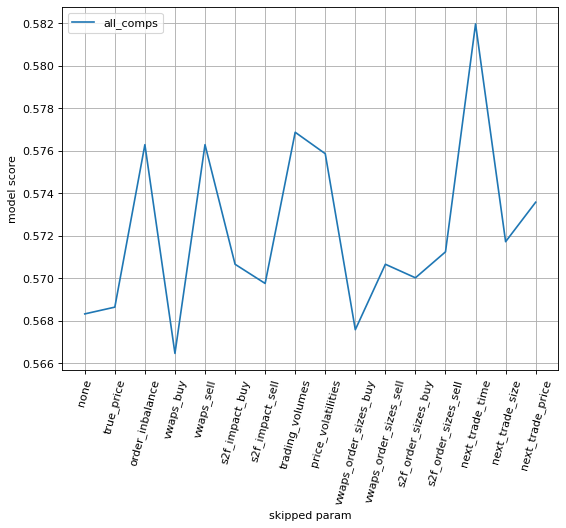

In [276]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
#plt.legend(comps)
 ### LOG REg

# compare models

In [106]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=5
names=[   
  #  'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    'next_trade_price',
   # 'true_price'
]
threshold=1e-3
comp_ths=np.zeros((len(list_of_companies_number),3))

In [107]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    comp_ths[comp_id,0]=logistic_regr(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
    comp_ths[comp_id,1]=decision_tree(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
    comp_ths[comp_id,2],_,_=xgb_model(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   -1.5311396536989856
vwaps_sell   0.14182023286811138
next_trade_price   0.16994541977714772
Coefficient impact:
vwaps_buy   0.2837273564427843
vwaps_sell   0.1719957850458683
next_trade_price   0.5442768585113473
[11:55:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.5157894736842106
Confusion matrix:
[[59 48]
 [44 39]]
Precision:
0.5514018691588785
Recall:
0.5728155339805825
1
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   -0.950922109695078
vwaps_sell   -0.44919812425653177
next_trade_price   -0.03514326470603109
Coefficient impact:
vwaps_buy   0.2821775766373771
vwaps_sell   0.2156782338658256
next_trade_price   0.5021441894967974
[11:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.5421052631578948
Confusion matrix:
[[72 39]
 [48 31]]
Precision:
0.6486486486486487
Recall:
0.6
2
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   0.4592207598587281
vwaps_sell   0.7103989661741866
next_trade_price   -0.659666250728565
Coefficient impact:
vwaps_buy   0.30979812148185915
vwaps_sell   0.26510955283477555
next_trade_price   0.4250923256833653
[11:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.531578947368421
Confusion matrix:
[[62 55]
 [34 39]]
Precision:
0.5299145299145299
Recall:
0.6458333333333334
3
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   0.06604196690462663
vwaps_sell   0.8592676172423402
next_trade_price   0.039185629223045505
Coefficient impact:
vwaps_buy   0.29757806427302
vwaps_sell   0.19139597821733442
next_trade_price   0.5110259575096455
[11:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.46842105263157896
Confusion matrix:
[[63 43]
 [58 26]]
Precision:
0.5943396226415094
Recall:
0.5206611570247934
4
(950, 3)
true price at index 9,95 was zero!
(950,)
Coefficient impact:
vwaps_buy   -0.14298243455862952
vwaps_sell   -0.3593014233260497
next_trade_price   -0.09133473236829943
Coefficient impact:
vwaps_buy   0.22195475238459325
vwaps_sell   0.29005930913361383
next_trade_price   0.48798593848179284
[11:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.45789473684210524
Confusion matrix:
[[64 30]
 [73 23]]
Precision:
0.6808510638297872
Recall:
0.46715328467153283
5
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   0.9150379785847418
vwaps_sell   1.7179752964257557
next_trade_price   -0.9955982071951135
Coefficient impact:
vwaps_buy   0.29812742729229813
vwaps_sell   0.2828877543033387
next_trade_price   0.4189848184043632
[11:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.5789473684210527
Confusion matrix:
[[77 50]
 [30 33]]
Precision:
0.6062992125984252
Recall:
0.719626168224299
6
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   -0.6241428129514527
vwaps_sell   -0.044165915783964706
next_trade_price   -0.16933048799027067
Coefficient impact:
vwaps_buy   0.27755754934031834
vwaps_sell   0.18637856734467925
next_trade_price   0.5360638833150024
[11:55:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.5157894736842106
Confusion matrix:
[[72 37]
 [55 26]]
Precision:
0.6605504587155964
Recall:
0.5669291338582677
7
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   1.5287236773729018
vwaps_sell   2.1925963594688604
next_trade_price   -0.6742100268050193
Coefficient impact:
vwaps_buy   0.24399986524046807
vwaps_sell   0.2747649254759085
next_trade_price   0.4812352092836235
[11:55:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[70 43]
 [31 46]]
Precision:
0.6194690265486725
Recall:
0.693069306930693
8
(950, 3)
(950,)
Coefficient impact:
vwaps_buy   0.3266443172610281
vwaps_sell   1.1956980022207886
next_trade_price   0.7131615688852821
Coefficient impact:
vwaps_buy   0.22486063204868253
vwaps_sell   0.24075143088722956
next_trade_price   0.5343879370640879
[11:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jacek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percent of correct classification:
0.37894736842105264
Confusion matrix:
[[49 64]
 [54 23]]
Precision:
0.4336283185840708
Recall:
0.47572815533980584
calculations took: 5.006856918334961 seconds


In [108]:
comp_summed=np.sum(comp_ths, axis=0)/9
print("logreg ", comp_summed[0], ", dec tree ", comp_summed[1], ", xgb ", comp_summed[2])

logreg  0.5719298245614035 , dec tree  0.5093567251461989 , xgb  0.5111111111111112


In [45]:
import torch

In [151]:
import tensorflow as tf
